In [215]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.signal import stft 
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
import statistics
import saxpy 
# from sklearn.preprocessing import StandardScaler
# from scipy.spatial.distance import cdist

Read Data

In [2]:


# Define the folder path
folder_path = "Substation_Data/"

# Create an empty dictionary to store the dataframes
dataframes = {}

# Iterate through all files in the folder
for file_name in os.listdir(folder_path):
    # Check if the file is a CSV file
    if file_name.endswith(".csv"):
        # Extract the substation name from the file name
        substation_name = file_name.split(" ")[2:]
        substation_name = substation_name[:substation_name.index("POWER")]
        substation_name = " ".join(substation_name)
        
        # Read the CSV file into a pandas dataframe
        df = pd.read_csv(os.path.join(folder_path, file_name))
        # Convert date column to datetime -- using this as opportunity to skip over empty dataframes (if you don't want this, add "errors = 'ignore'" to the to_datetime command)
        try:
            df['Datetime'] = pd.to_datetime(df['Date (Dublin. Edinburgh. Lisbon. London)']) 
        except:
            continue
        # Drop old date column 
        df.drop('Date (Dublin. Edinburgh. Lisbon. London)', axis=1, inplace=True)
        # Add the dataframe to the dictionary with the substation ID as the key
        dataframes[substation_name] = df

# Print the dataframe keys to check that the IDs processed appropriately
print(dataframes.keys())


dict_keys(['banjo road tx2', 'medawar centre ', 'chepstow drive', 'priory rd 1', 'hempton road duns tew', 'henley avenue', 'texas homecare', 'Ferry hinksey road', 'queens lane telephone exchange', 'Thames View Road', 'Fiennes Road', 'Danvers Road', 'Hillsborough Close', '76 Church Road', 'henry road T1', 'Church Way Iffley', 'littlemore pk', 'Osney local', 'Drake Avenue', 'quintan avenue ', 'Desborough crescent', 'Hockmore Street', 'banjo road tx1 ', 'campbell road', 'Tappins Coaches', 'Wellington square ', 'Rivermead Road SS', 'kennington church (cow lane)', 'church road fieldside', 'osney mead pylon ', 'rose hill community centre', 'mill street SS', 'hopcraft lane', 'newman road', 'regal industrial', 'heyford hill Lane', 'blackwells hythe bridge st', 'St Thomas Street', 'retail park unit 27', 'osney bridge street', 'southern by pass', 'ashmolean museum ', 'garsington village hall', 'priory Road 2', 'Bridge View Watlington Road', 'woodcroft', 'seacourt road', 'Neolithic', 'croft avenu

# 19/01/2023

### Feature extraction and analysis

In [265]:
columns = ["mean", "max", "min", "std", 'median', 'var', 'sum']
dict_Features = {"Active Power [kW]": pd.DataFrame(columns=columns, index = dataframes.keys()),
               "Reactive Power [kVAr]": pd.DataFrame(columns=columns, index = dataframes.keys()),
               "Apparent Power [kVA]": pd.DataFrame(columns=columns, index = dataframes.keys()),
               "Power Factor": pd.DataFrame(columns=columns, index = dataframes.keys())}

# Loop through dictionary of substation dataframes
for substation, substation_df in dataframes.items():
    # Extract features
    for feature in dict_Features:
        dict_Features[feature].loc[substation] = substation_df[feature].describe().loc[['mean','max','min','std']]
        dict_Features[feature].loc[substation]['median'] = substation_df[feature].median()
        dict_Features[feature].loc[substation]['var'] = substation_df[feature].var()
        dict_Features[feature].loc[substation]['sum'] = substation_df[feature].sum()
        
dict_Features['Active Power [kW]'].head(5)
#dict_Features['Reactive Power [kVAr]'].head(5)
#dict_Features['Apparent Power [kVA]'].head(5)
#dict_Features['Power Factor'].head(5)

mean         max        min        std  \
banjo road tx2          34.893939   58.891667     6.7515  15.887261   
medawar centre         138.248651  229.841667  98.046667  22.418721   
chepstow drive          50.568099  106.348333    21.9535  17.904417   
priory rd 1              8.652692   24.121667   3.131667   3.445617   
hempton road duns tew   32.415102   65.261667  16.886667   9.028619   

                          median         var           sum  
banjo road tx2         42.076917  252.405058  25961.090965  
medawar centre           133.105  502.599063    102995.245  
chepstow drive           46.8305  320.568166  37673.233805  
priory rd 1                8.255   11.872279   6359.728667  
hempton road duns tew  31.370833   81.515965     24116.836

#### Active Power [kW]: Classify substations as based on amount of Active Power they are generating </br>


In [220]:
# Define thresholds
high_kW_threshold = 50 # kW
medium_kW_threshold = 25 # kW

#Initialize empty lists
high_kW  = []
med_kW = []
low_kW = []

#Loop through dictionary of substation dataframes to categorize substations -- this example uses 'mean'
for key in dataframes.keys():
    if dict_Features['Active Power [kW]'].loc[key]['mean'] > high_kW_threshold:
        high_kW.append(key)
    elif dict_Features['Active Power [kW]'].loc[key]['mean'] > medium_kW_threshold:
        med_kW.append(key)
    else:
        low_kW.append(key)
        
#Check how many substations are in each list
print('High:', len(high_kW), '\n',
      'Med:', len(med_kW), '\n',
      'Low:', len(low_kW))

High: 12 
 Med: 22 
 Low: 44


#### Reactive Power [kVAr]: Classify substations based on amount of Reactive Power they are generating </br>

In [221]:
high_kVar_threshold = 1
medium_kVar_threshold = -1

high_kVAr  = []
med_kVAr = []
low_kVAr = []

for key in dataframes.keys():
    if dict_Features['Reactive Power [kVAr]'].loc[key]['mean'] > high_kVar_threshold:
        high_kVAr.append(key)
    elif dict_Features['Reactive Power [kVAr]'].loc[key]['mean'] > medium_kVar_threshold:
        med_kVAr.append(key)
    else:
        low_kVAr.append(key)
        
print('High:', len(high_kVAr), '\n',
      'Med:', len(med_kVAr), '\n',
      'Low:', len(low_kVAr))

High: 13 
 Med: 16 
 Low: 49


#### Power Factor: Ratio of Apparent power to Active power (kVA/kW)) 


In [222]:
high_PF_threshold = 0.95
medium_PF_threshold = 0.8

high_PF  = []
med_PF = []
low_PF = []

for key in dataframes.keys():
    if dict_Features['Power Factor'].loc[key]['mean'] > high_PF_threshold:
        high_PF.append(key)
    elif dict_Features['Power Factor'].loc[key]['mean'] > medium_PF_threshold:
        med_PF.append(key)
    else:
        low_PF.append(key)
        
print('High:', len(high_PF), '\n',
      'Med:', len(med_PF), '\n',
      'Low:', len(low_PF))

High: 36 
 Med: 14 
 Low: 28


#### Look at substations that are high or low in both kW and kVAr 

In [227]:
high_performance = []
low_performance = []
for key in dataframes.keys():
    if key in high_kW and key in high_kVAr:
        high_performance.append(key)
    if key in low_kW and key in low_kVAr:
        low_performance.append(key)
print('High performance substations', high_performance, '\n',
      'Low performance substations', low_performance)

High performance substations ['4618006200', '4911006040', '4600006670', '4606001020'] 
 Low performance substations ['4618007040', '4618006140', '4626001020', '4614005070', '4626003020', '4618002030', '4904022150', '4618002100', '4618001020', '4626004340', '4911006100', '4602003070', '4911006020', '4011002280', '4006003015', '4618003160', '4605017240', '4606001120', '4618002060', '4606004340', '4618007100', '4600015150', '4626001500', '4618003120', '4626006170', '4626002020']


Next steps:

Ientify leading, lagging, and unity substations: </br>
Leading - generating more reactive power than consuming </br>
Lagging - consuming more reactive power than generating </br>
Unity - generating and consuming same amount of reactive power 

Brainstorm further summary statistics with Elnaz

### Explore time usage

In [8]:
'''
Given a dictionary of substation dataframes, returns a dictionary of the peak hour (kW) for each substation
'''
def extract_peak_hours(dataframes):
    # Create an empty dictionary to store the peak hour for each substation 

    
    for substation, substation_df in dataframes.items():
        
        # Group the data by hour
        hourly_data = substation_df.groupby(substation_df['Datetime'].dt.hour)['Active Power [kW]'].sum()

        # Normalize the data to get probability
        hourly_data = hourly_data / hourly_data.sum()
        
        # Store the peak hour for this substation in the dictionary 
        peak_hours[substation] = hourly_data[hourly_data == hourly_data.max()].index.tolist()
    
    return peak_hours

Plot histogram of peak hours

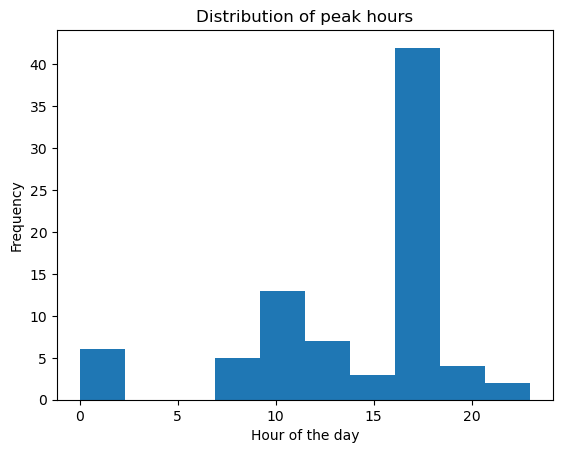

In [9]:
peak_hours = extract_peak_hours(dataframes)
all_peak_hours = [item for sublist in peak_hours.values() for item in sublist]
plt.hist(all_peak_hours)
plt.xlabel("Hour of the day")
plt.ylabel("Frequency")
plt.title("Distribution of peak hours")
plt.show()




def extract_peak_hours_reactive

Average daily profile: Aggregate the load from all substations in each hour over the past month, and plot

/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_30112/4270879519.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_data = all_data.groupby('hour').mean()


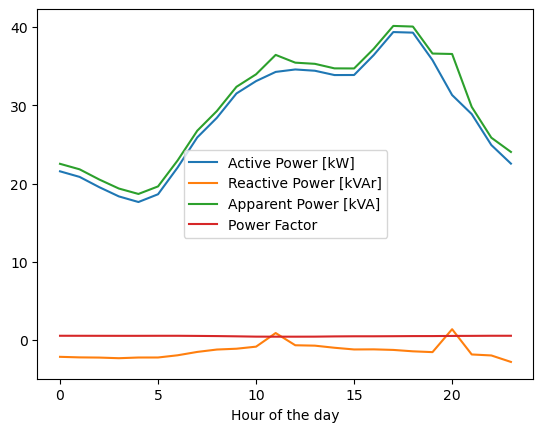

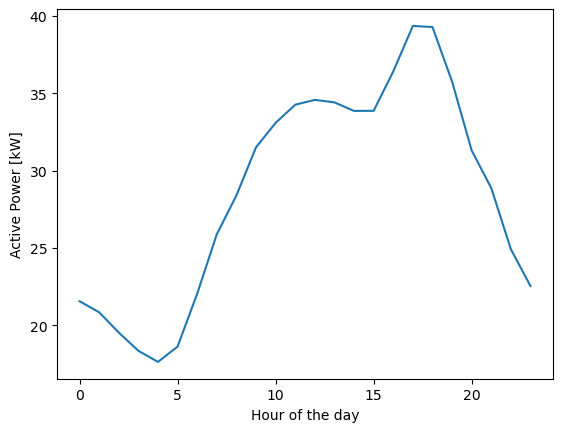

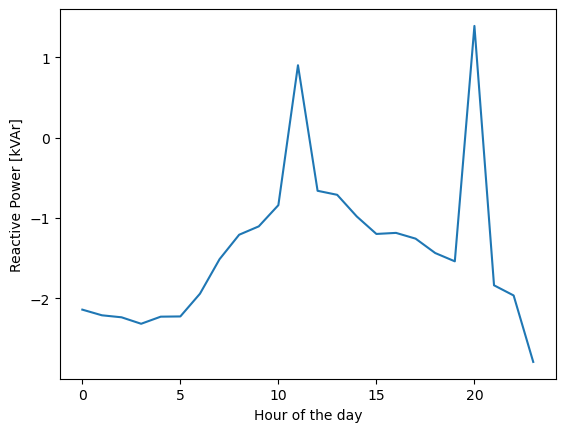

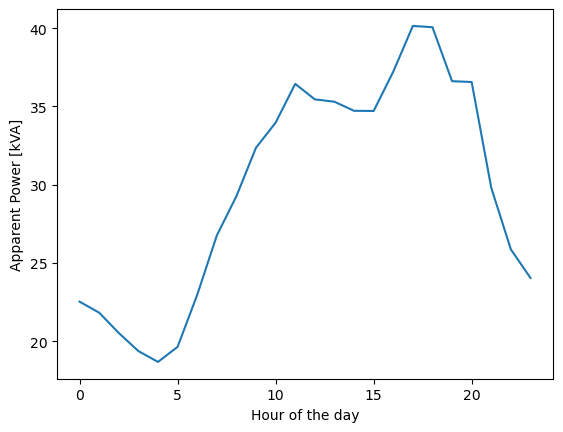

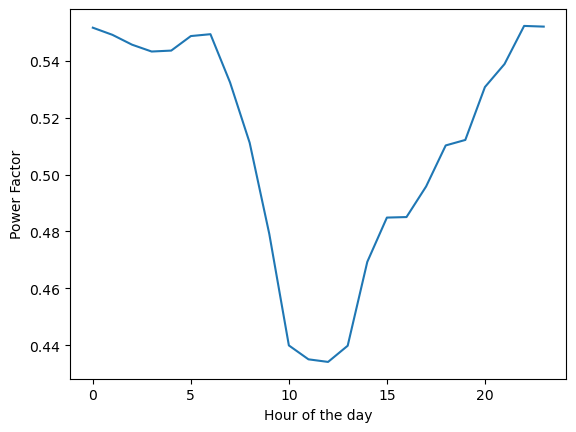

In [230]:
# List of features
features = ['Active Power [kW]', 'Reactive Power [kVAr]', 'Apparent Power [kVA]', 'Power Factor']


# Concatenate all dataframes into one
all_data = pd.concat(list(dataframes.values()))

# Extract the hour of the day from the datetime
all_data['hour'] = all_data['Datetime'].dt.hour

# Group the data by hour of the day
grouped_data = all_data.groupby('hour').mean()

# Plot the average daily load profile -- all features on one plot
grouped_data[features].plot()
plt.xlabel("Hour of the day")
plt.show()

# Create function to plot the average daily load profile for a single feature
def plot_power(dataframe, feature):
    plt.plot(dataframe[feature])
    plt.ylabel(feature)
    plt.xlabel("Hour of the day")
    plt.show()

#Plot features solo 
for feature in features:
    plot_power(grouped_data, feature)







# 21/01/2023

### Ratio analysis of daily load high and low periods



Ratio of peak/valley to average daily load (Active Power)

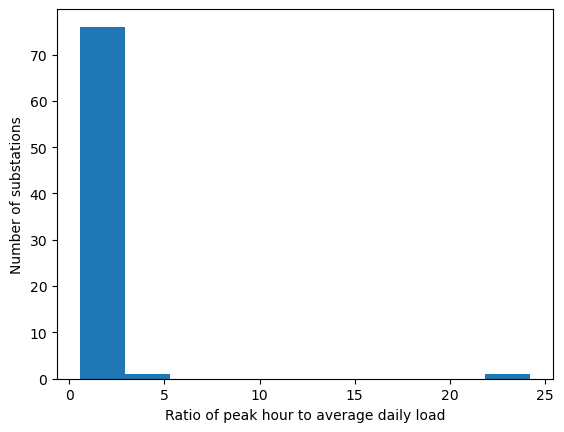

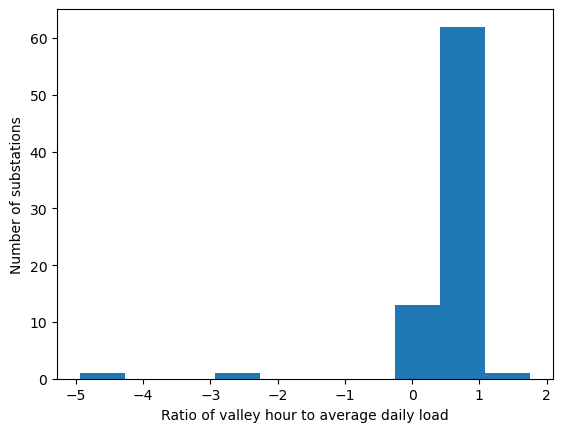

In [28]:
'''
This function takes in a dictionary of substation dataframes and finds the ratio of the peak and valley hours to the average daily load (amplitudes)
'''
def extract_amplitudes(dataframes):
    #Dictionaries to store the peak and valley ratios for each substation
    peak_ratios = {}
    valley_ratios = {}
    
    for substation, substation_df in dataframes.items():
    
        # Group the data by hour
        hourly_data = substation_df.groupby(substation_df['Datetime'].dt.hour)['Active Power [kW]'].sum()

        # Get the ratio of the peak hour to the average daily load and store in the dictionary
        peak_ratios[substation] = hourly_data.max() / hourly_data.mean()
        
        # Get the ratio of the valley hour to the average daily load and store in the dictionary
        valley_ratios[substation] = hourly_data.min() / hourly_data.mean()
    
    return peak_ratios, valley_ratios

peak_ratios, valley_ratios = extract_amplitudes(dataframes)

#Plot the distribution of peak ratios
plt.hist(list(peak_ratios.values()))
plt.xlabel("Ratio of peak hour to average daily load")
plt.ylabel("Number of substations")
plt.show()

#Plot the distribution of valley ratios
plt.hist(list(valley_ratios.values()))
plt.xlabel("Ratio of valley hour to average daily load")
plt.ylabel("Number of substations")
plt.show()



         

How long Active Power > (1.5 * average daily load) per day </br>
How long Active Power < (0.75 * average daily load) per day 

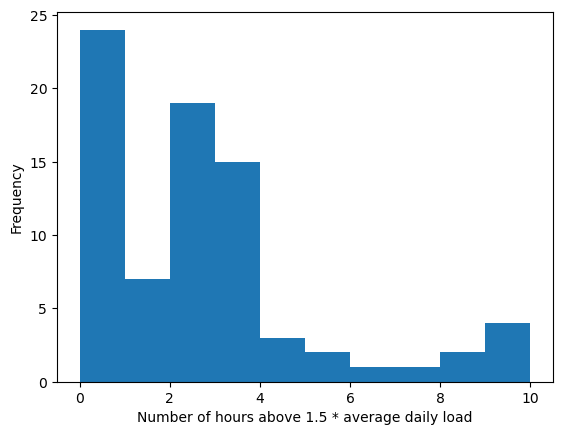

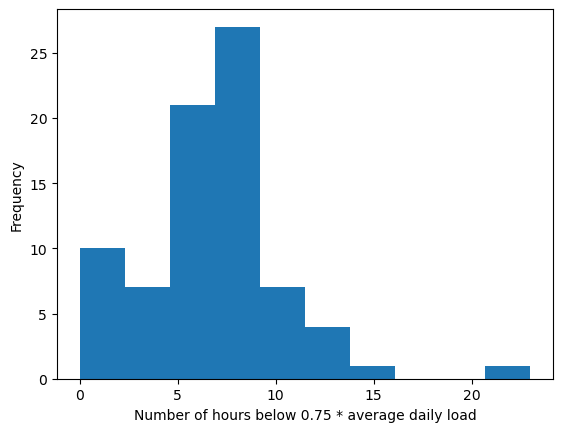

In [27]:
'''
This function takes in a dictionary of substation dataframes and finds:
on average how long the active power is more than 1.5 * average daily load
on average how long the active power is less than 0.75 * average daily load

NOTE: For whatever time frame we end up looking at, we may not want to compare the average of each hour to the average daily load, but rather the actual value in each hour over the entire time frame to avareage daily load, and then divide that by the number of days in the time period. Let me know. 
'''
def estimate_hot_or_cold(dataframes):
    #Dictionaries to store the peak and valley ratios for each substation
    hot_times = {}
    cold_times = {}
    
    for substation, substation_df in dataframes.items():
    
        # Group the data by hour
        hourly_data = substation_df.groupby(substation_df['Datetime'].dt.hour)['Active Power [kW]'].sum()
        
        # Get ratio of each hour to the mean
        hourly_data = hourly_data / hourly_data.mean()
        
        # Get the number of hours per day that the active power is more than 1.5 * average daily load
        hot_times[substation] = hourly_data[hourly_data > 1.5].count() 
        
        # Get the number of hours per day that the active power is less than 0.75 * average daily load
        cold_times[substation] = hourly_data[hourly_data < 0.75].count() 
    
    return hot_times, cold_times

hot_times, cold_times = estimate_hot_or_cold(dataframes)

#Plot the distribution of how many hours per day each substation is 'running hot' on average
plt.hist(list(hot_times.values()))
plt.xlabel("Number of hours above 1.5 * average daily load")
plt.ylabel("Number of substations")
plt.show()

#Plot the distribution of how many hours per day each substation is 'running cold' on average
plt.hist(list(cold_times.values()))
plt.xlabel("Number of hours below 0.75 * average daily load")
plt.ylabel("Number of substations")
plt.show()



### Smoothness of signal

Root mean square (RMS) deviation: </br>
Measure of average deviation of the signal from its mean value. 
Lower RMS = smoother, Higher RMS = more fluctuations.

Variance: Low variance = more consistent, and therefore smooth and flat signal 

Kurtosis: Signal with high kurtosis has heavy-tailed distribution and therefore greater fluctations than signal with low kurtosis

Short-Time Fourier Transform (STFT): Extract the frequency component of the signal, and the smoothness can be estimated by observing the frequency component. Using standard deviation of the fluctuation in active power, a signal with less fluctuation in frequency component is smoother. 

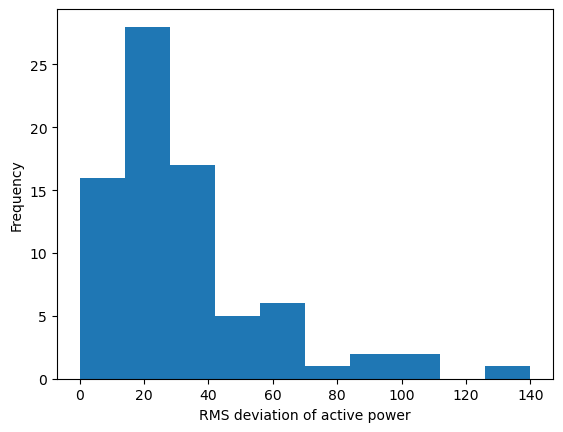

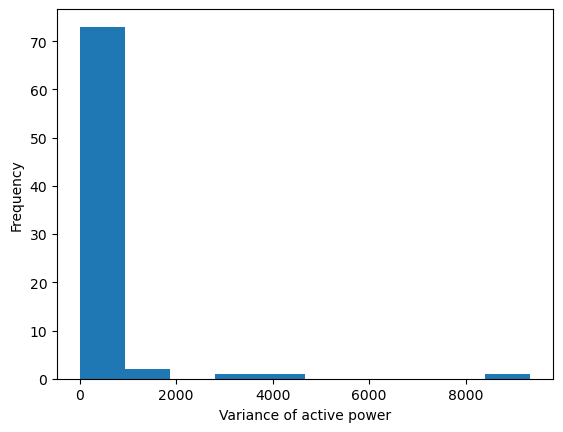

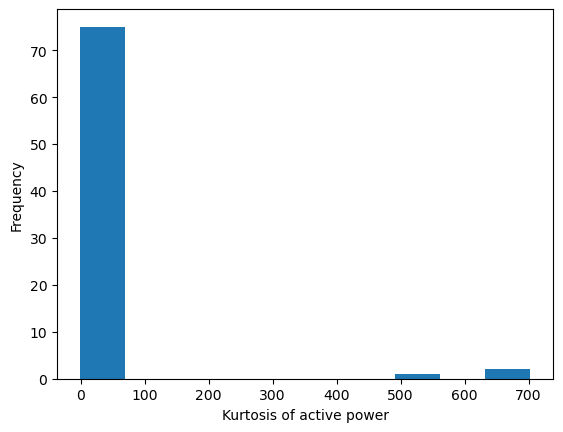

count    78.000000
mean      1.615699
std       2.762939
min       0.000000
25%       0.191174
50%       0.543722
75%       1.517620
max      15.462529
dtype: object


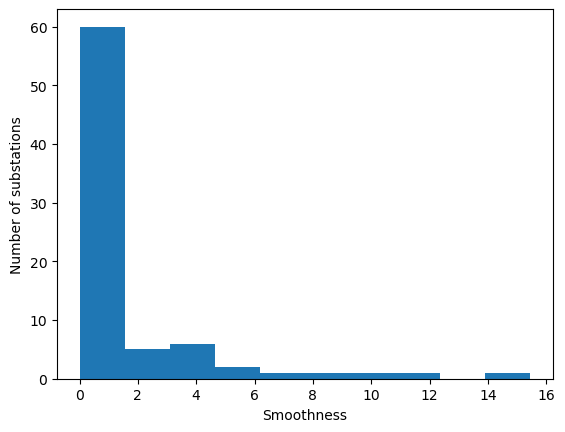

In [177]:
'''
This function takes in a dictionary of substation dataframes and returns a dictionary of RMS deviation and variance for each substation
'''

def compute_smoothness_metrics(dataframes):
    #Dictionaries to store the peak and valley ratios for each substation
    rms = {}
    variance = {}
    kurtosis = {}
    stft_smoothness = {}
    
    for substation, substation_df in dataframes.items():
    
        # Root-mean square
        rms[substation] = np.sqrt(np.mean(substation_df['Active Power [kW]']**2))
    
        # Variance
        variance[substation] = np.var(substation_df['Active Power [kW]'])
        
        # Kurtosis
        kurtosis[substation] = substation_df['Active Power [kW]'].kurtosis()
        
        # Short Time Fourier Transform (STFT) 
        # Apply STFT to the active power signal (f = array of sample frequencies, t = array of segment times, Zxx is ndarray of STFT coefficients of Active Power signal)
        f,t, Zxx = stft(substation_df['Active Power [kW]'].values, fs=1, window='hann', nperseg=len(substation_df['Active Power [kW]'].values))

        # Calculate the average power of the STFT coefficients
        avg_power = np.mean(np.abs(Zxx) ** 2, axis=0)

        # Calculate the standard deviation of the average power
        std_dev = np.std(avg_power)
        
        stft_smoothness[substation] = std_dev

    return rms, variance, kurtosis, stft_smoothness

rms, var, kur, stft_smoothness = compute_smoothness_metrics(dataframes)


#Plot the distribution of RMS deviation for each substation
plt.hist(list(rms.values()))
plt.xlabel("RMS deviation of active power")
plt.ylabel("Frequency")    
plt.show() 

#Plot the distribution of Variance for each substation
plt.hist(list(var.values()))
plt.xlabel("Variance of active power")
plt.ylabel("Frequency")    
plt.show() 

#Plot the distribution of Kurtosis for each substation
plt.hist(list(kur.values()))
plt.xlabel("Kurtosis of active power")
plt.ylabel("Frequency")    
plt.show() 

#Plot the distribution of smoothness based on stft coefficient std dev for each substation
plt.hist(list(stft_smoothness.values()))
plt.xlabel("Smoothness")
plt.ylabel("Number of substations")

#Descriptive statistics of smoothness
print(pd.Series(stft_smoothness.values()).describe().apply(lambda x: format(x, 'f')))



### Boxplot of consumption per hour for each substation

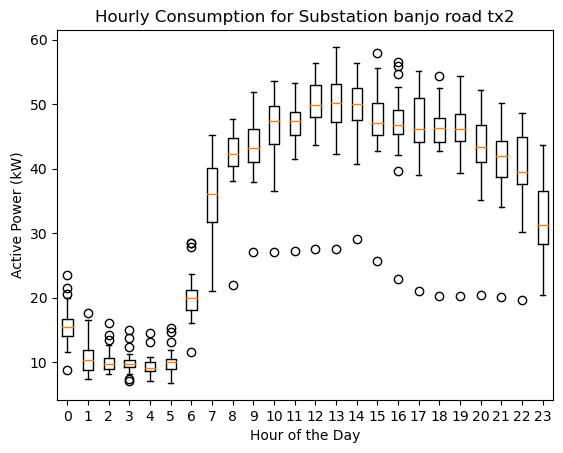

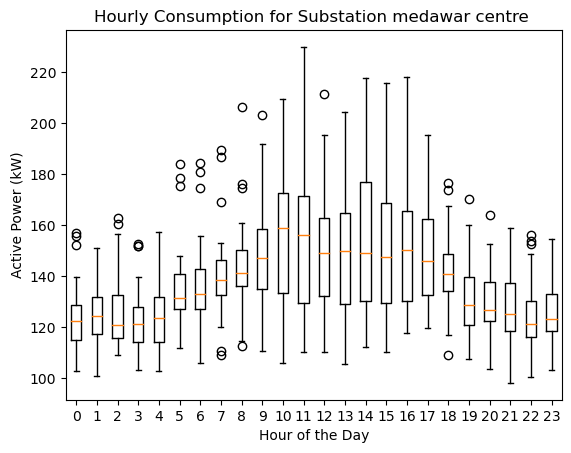

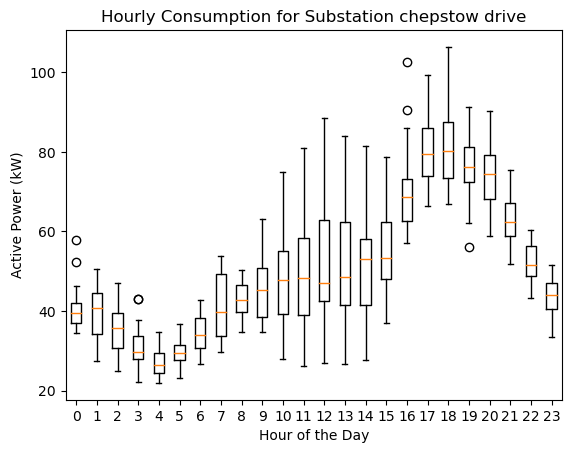

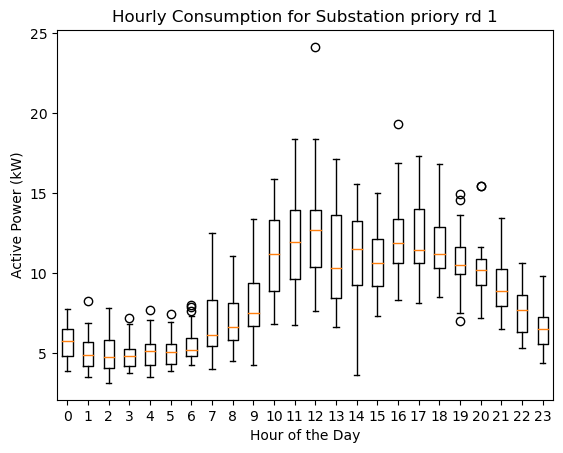

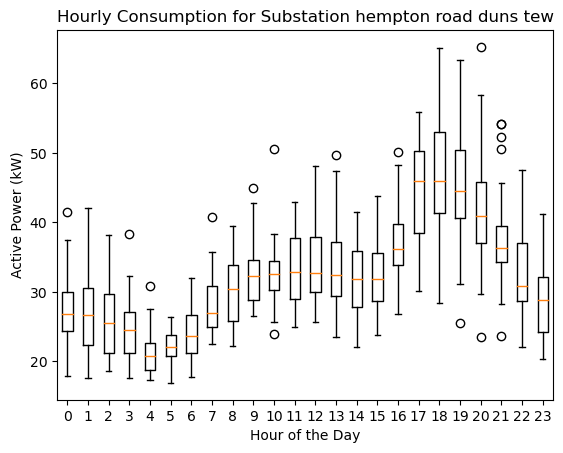

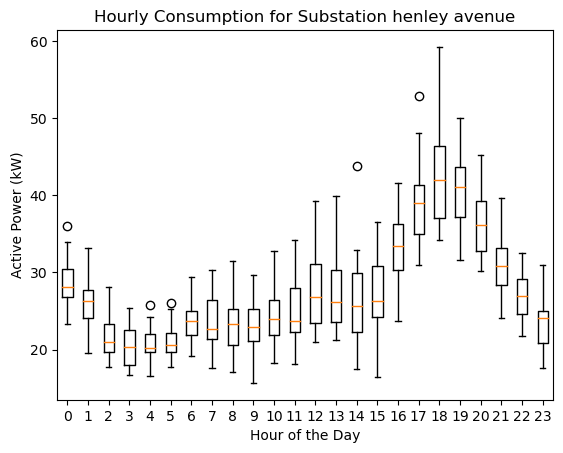

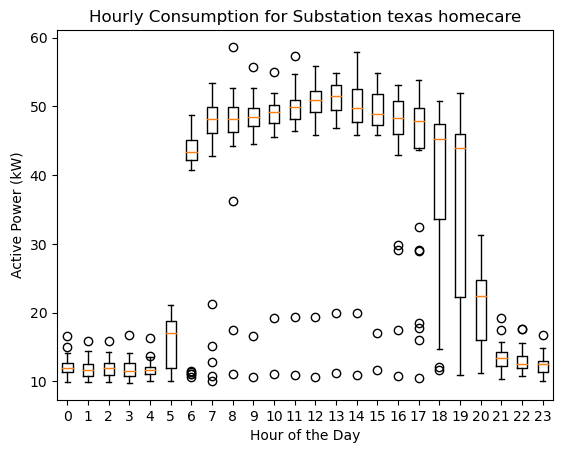

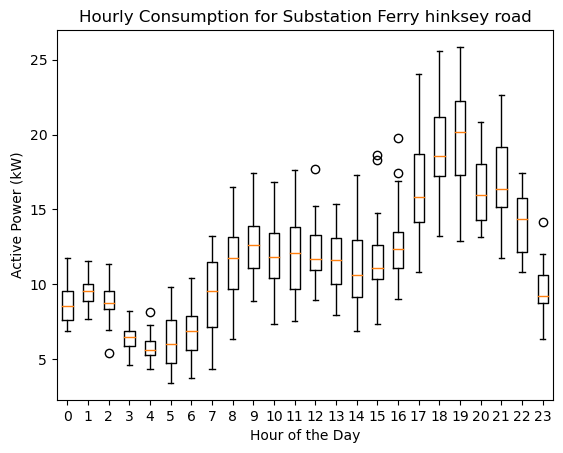

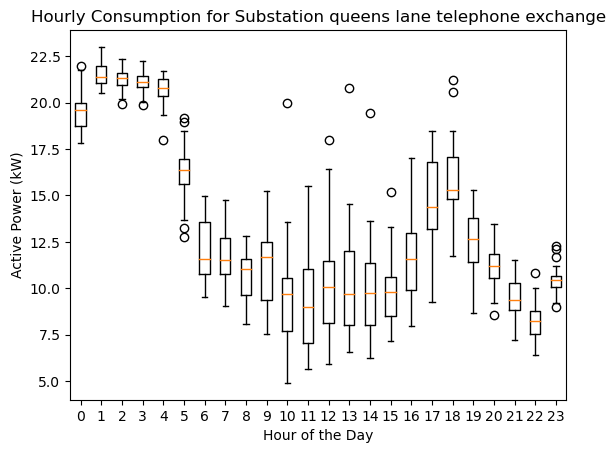

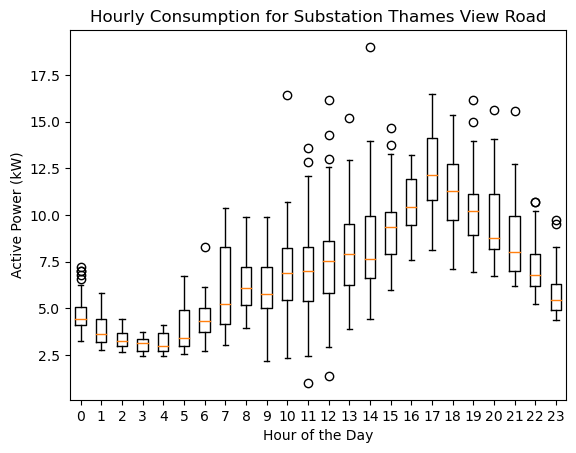

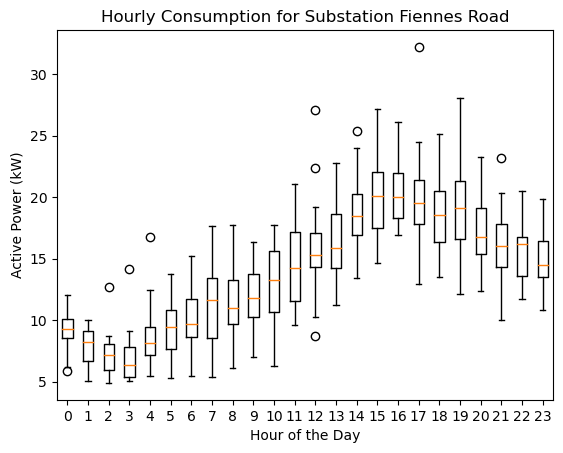

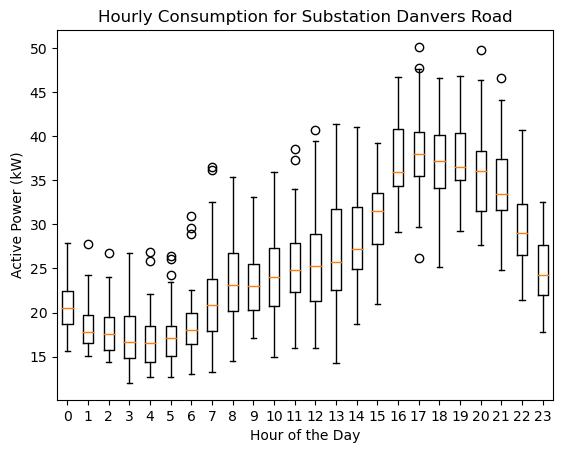

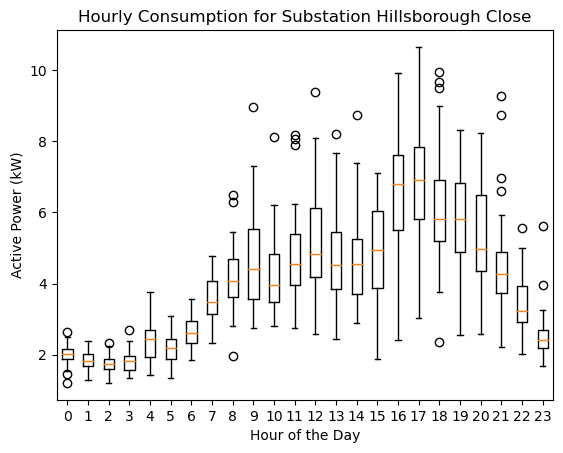

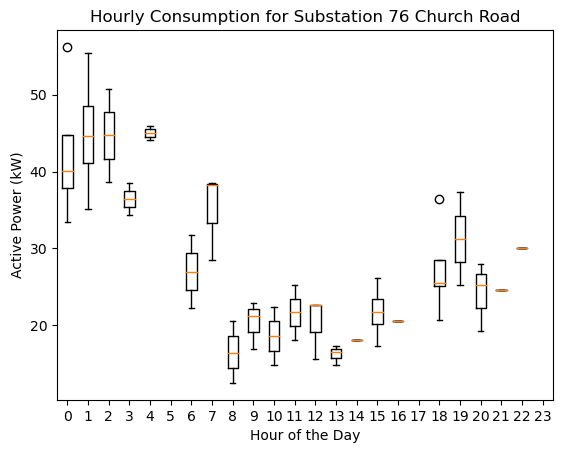

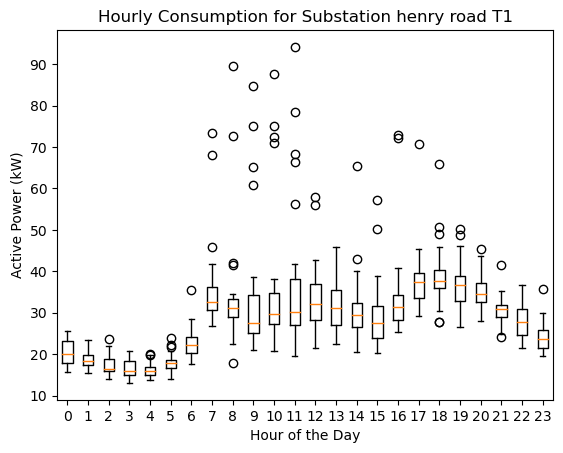

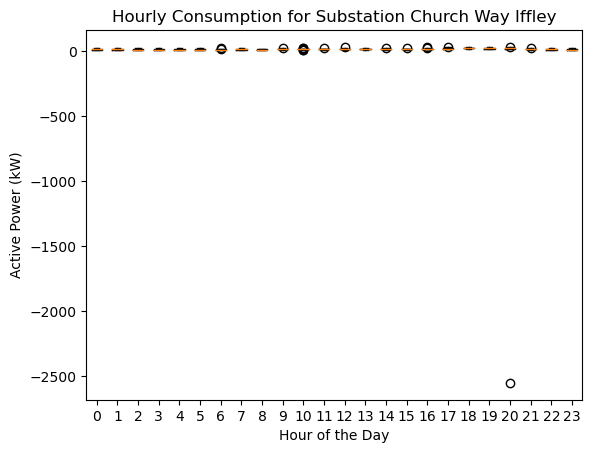

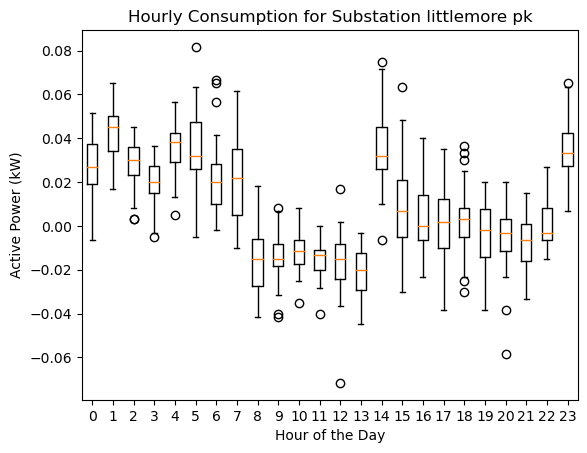

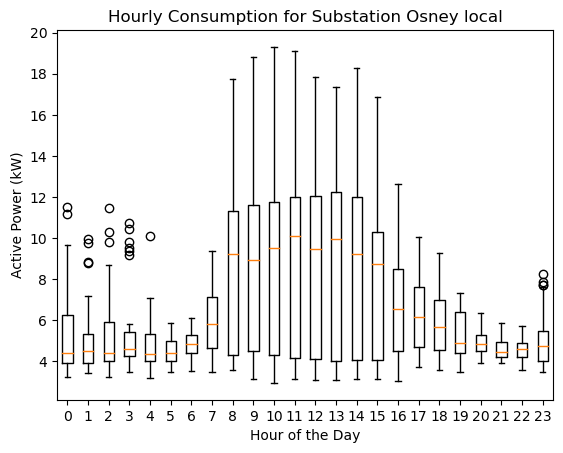

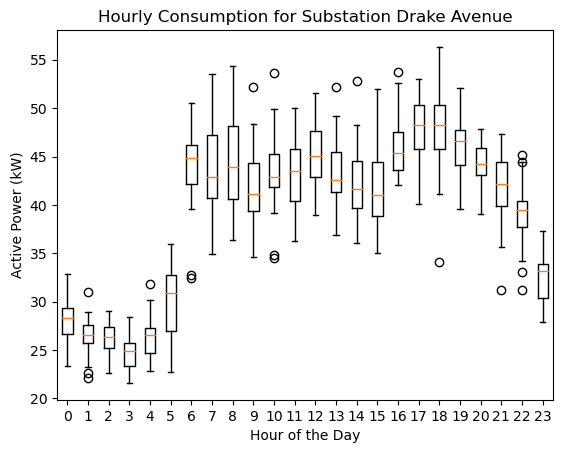

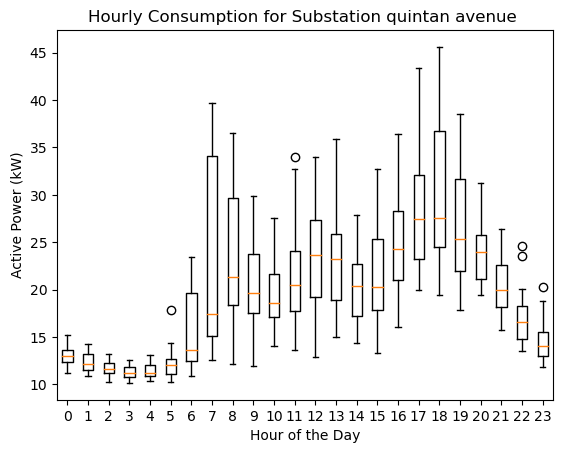

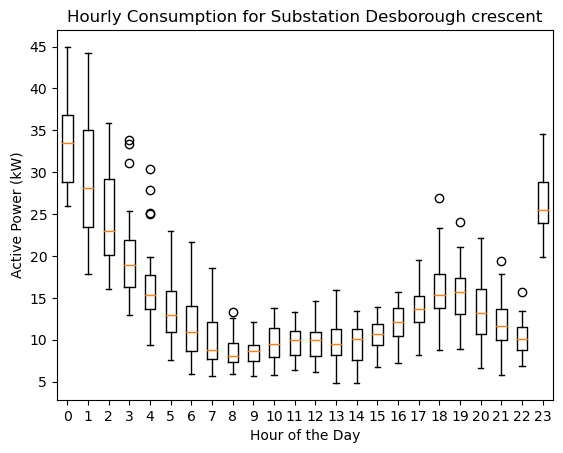

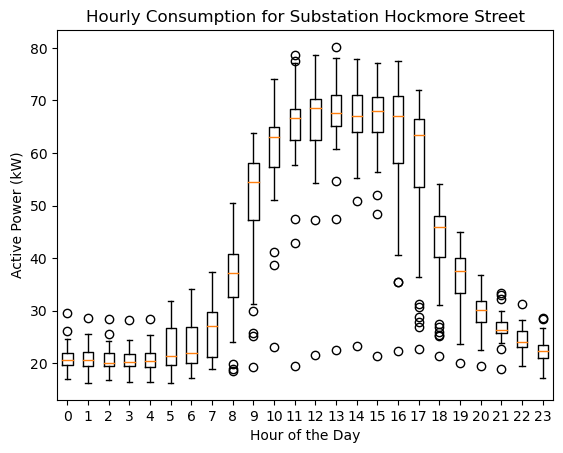

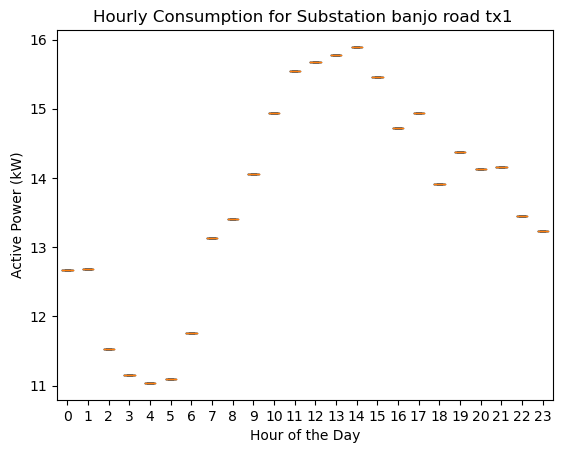

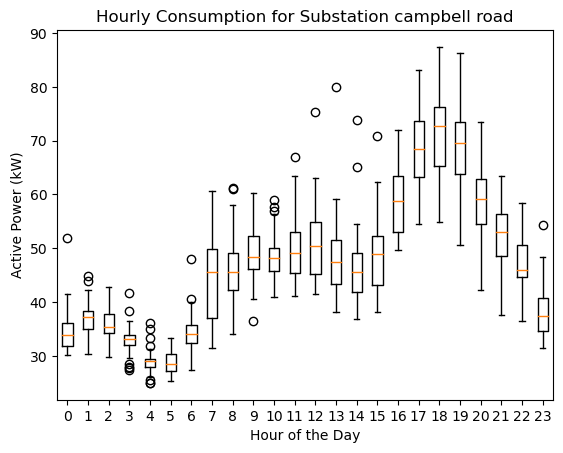

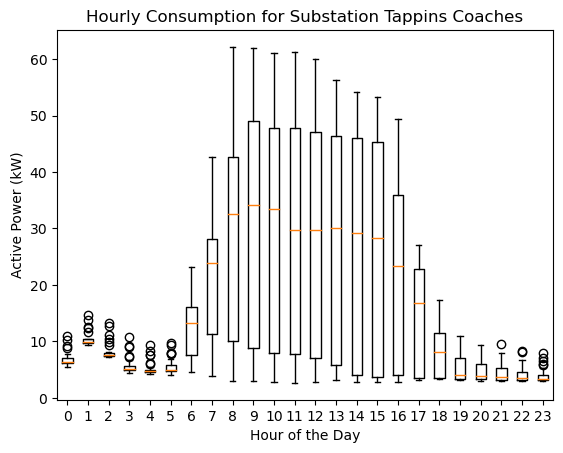

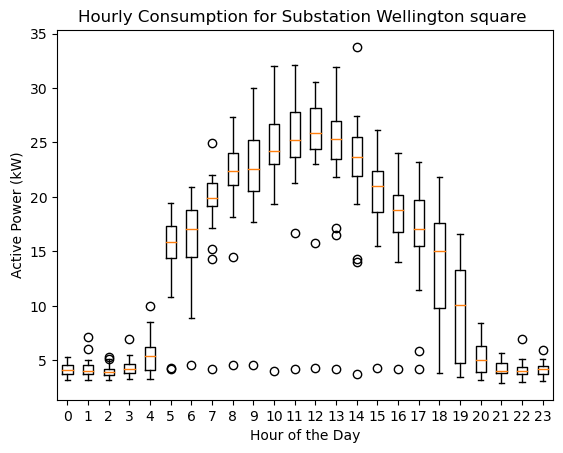

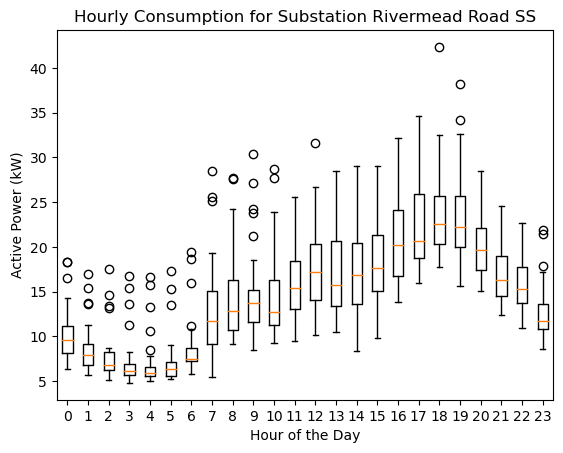

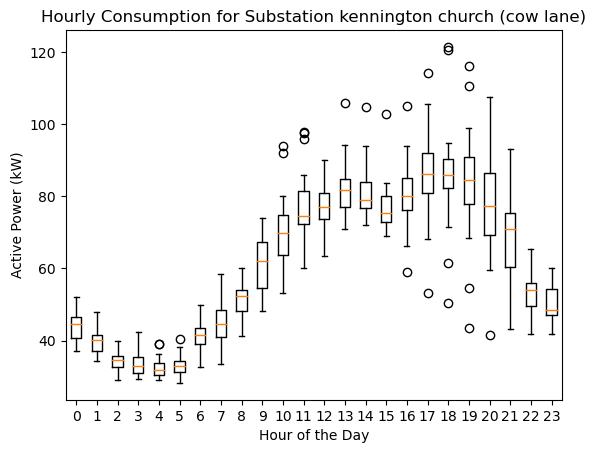

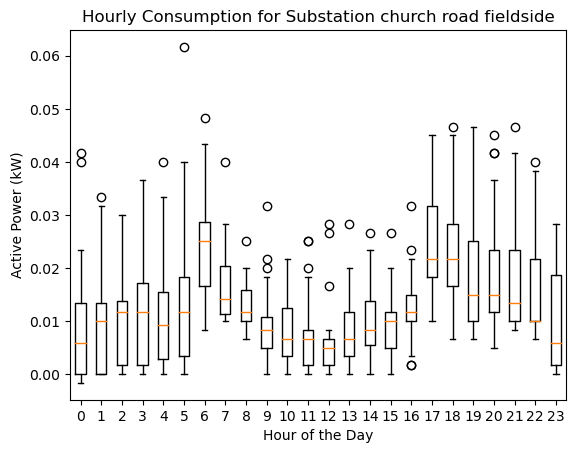

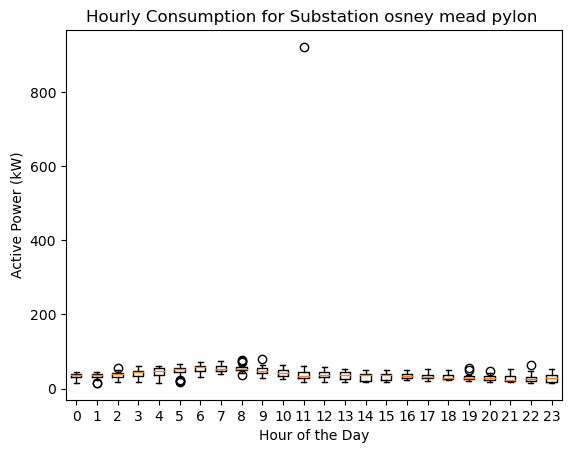

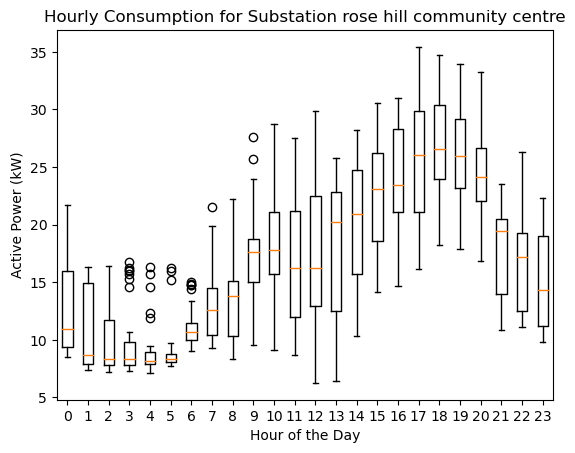

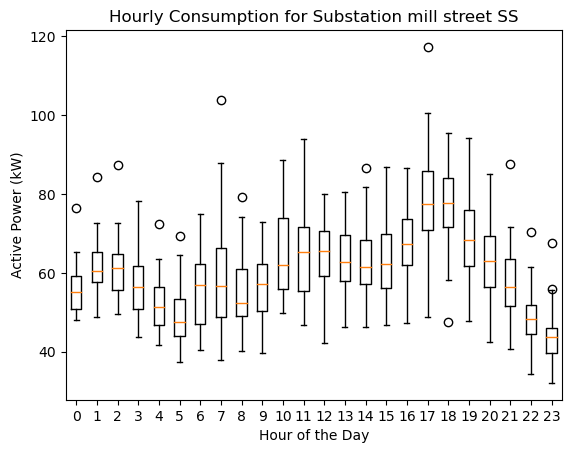

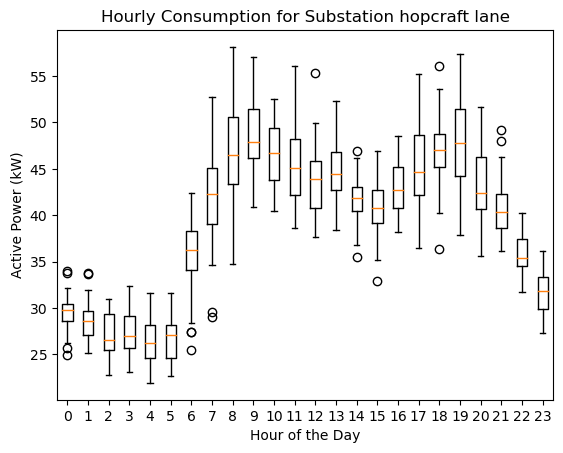

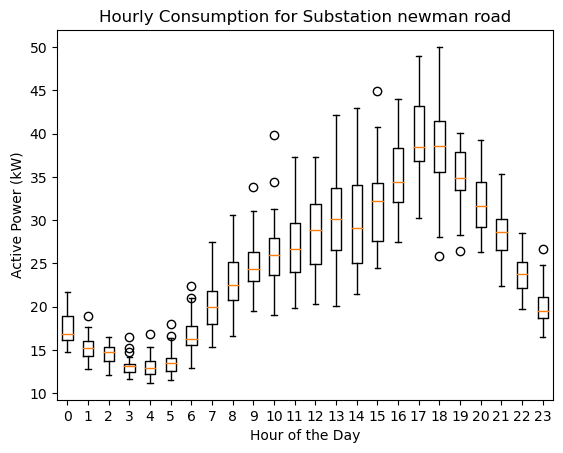

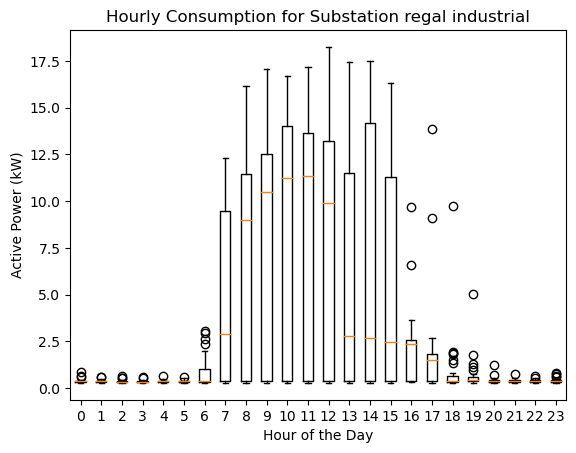

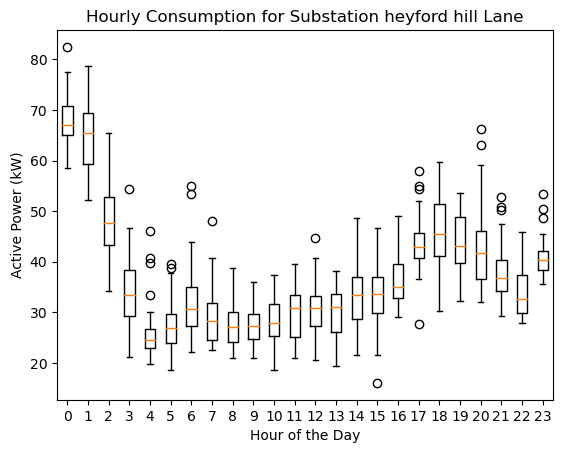

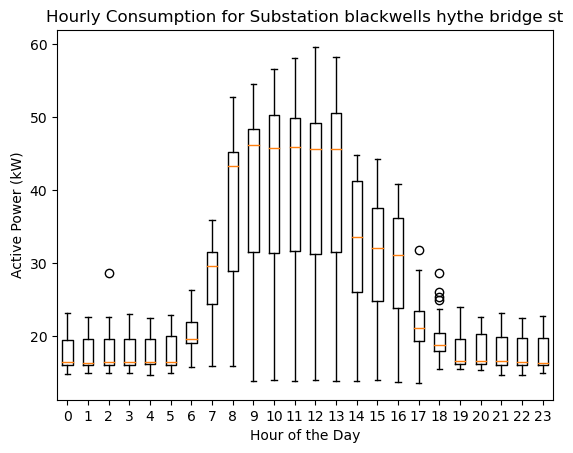

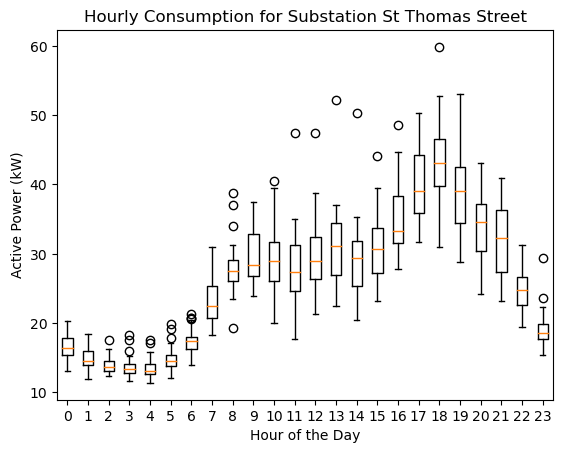

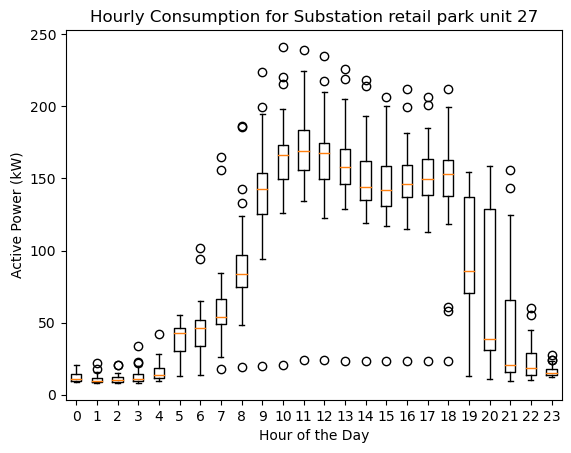

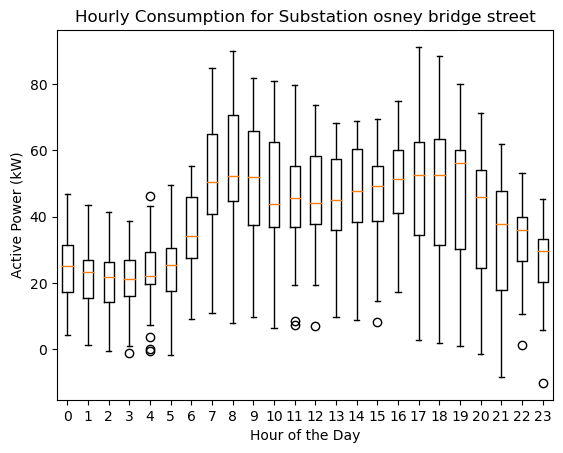

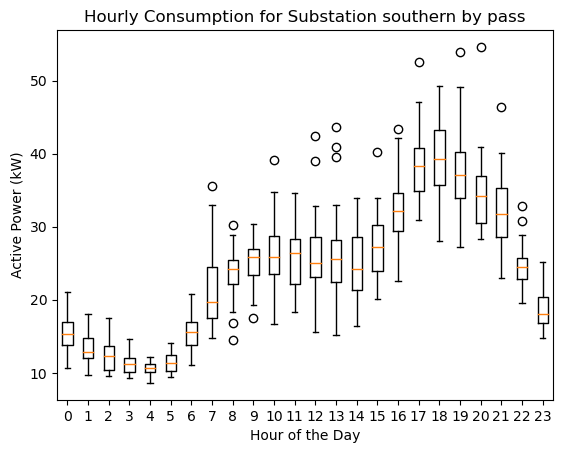

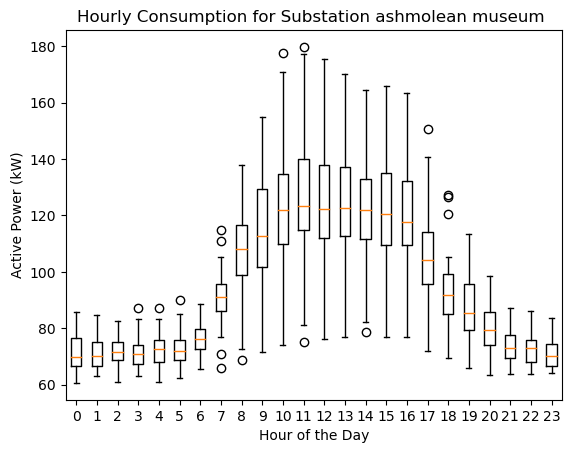

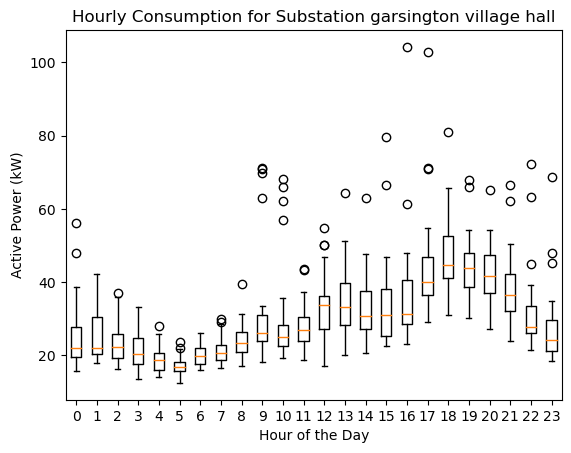

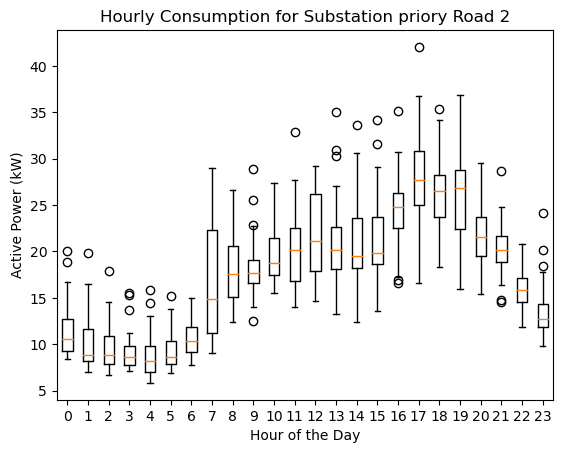

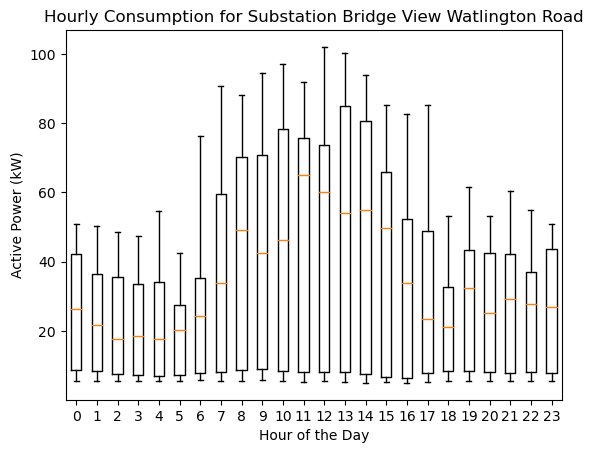

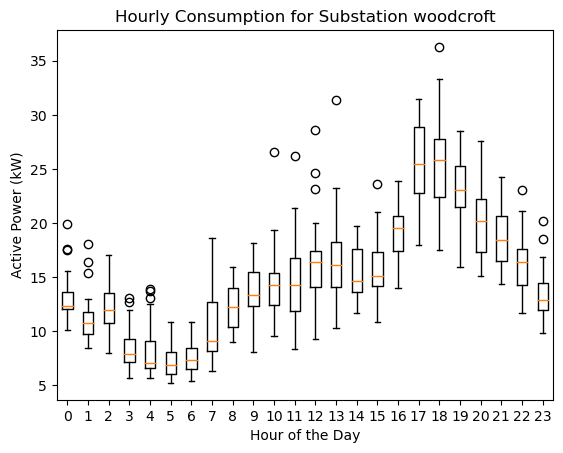

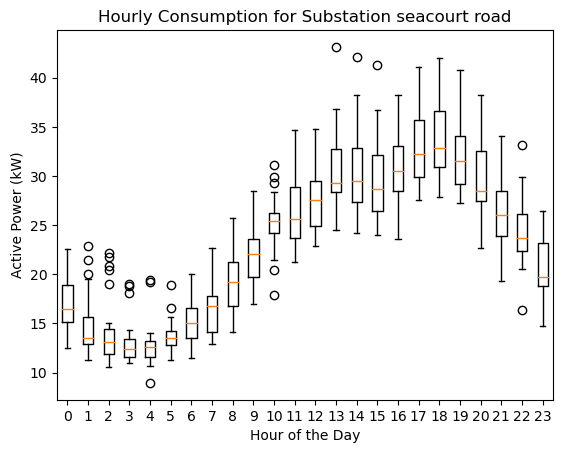

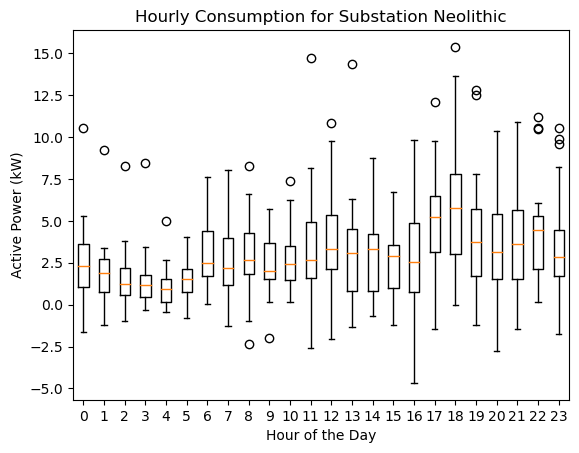

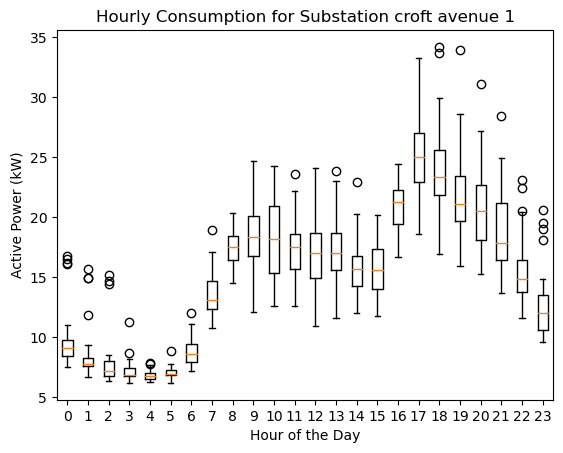

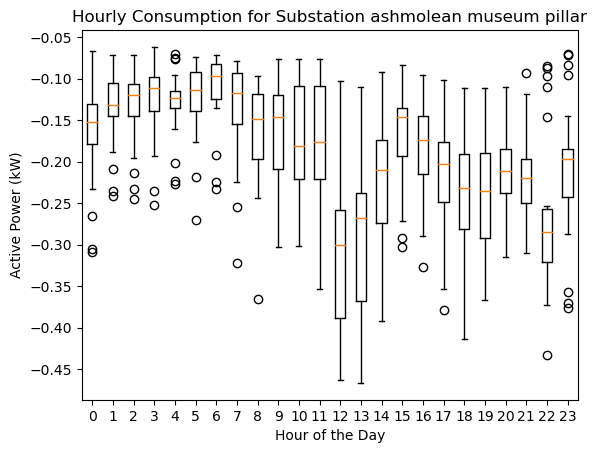

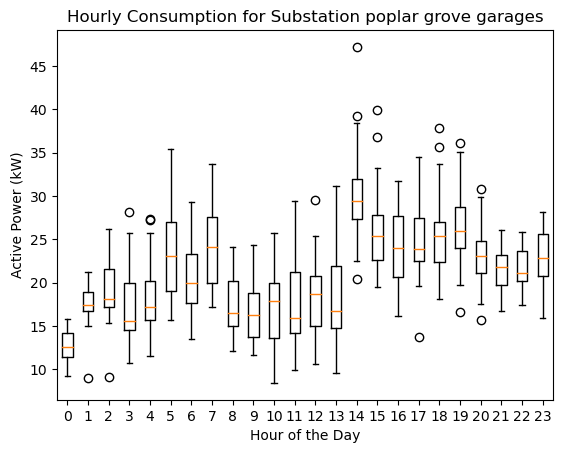

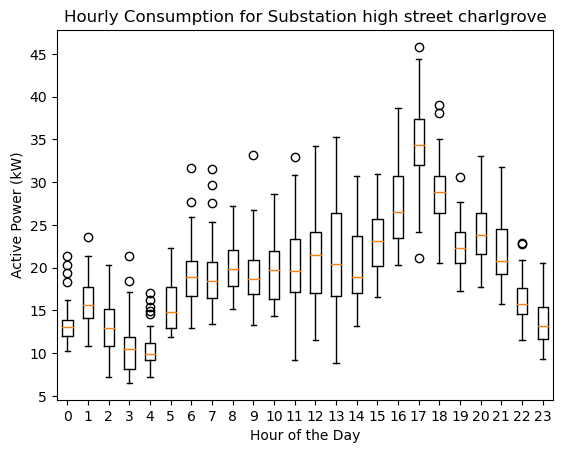

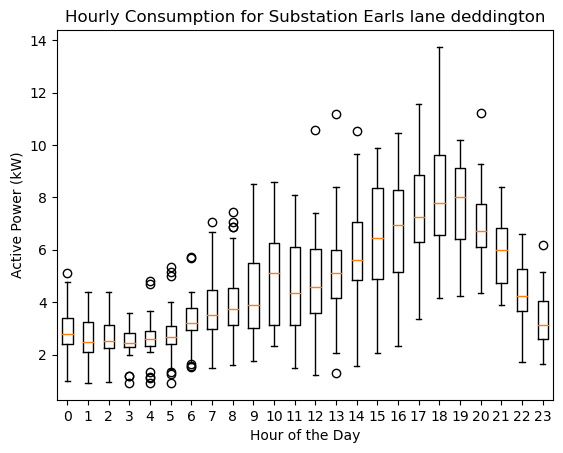

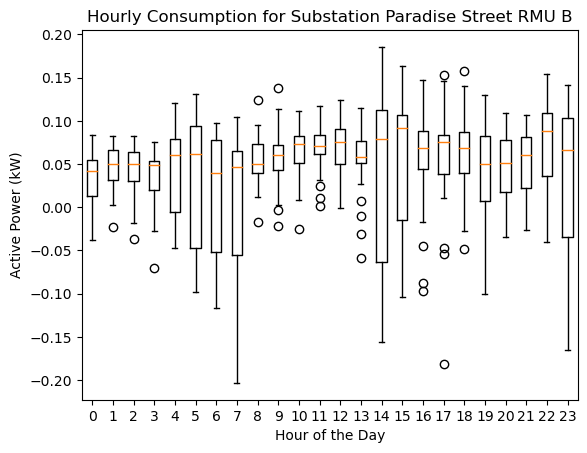

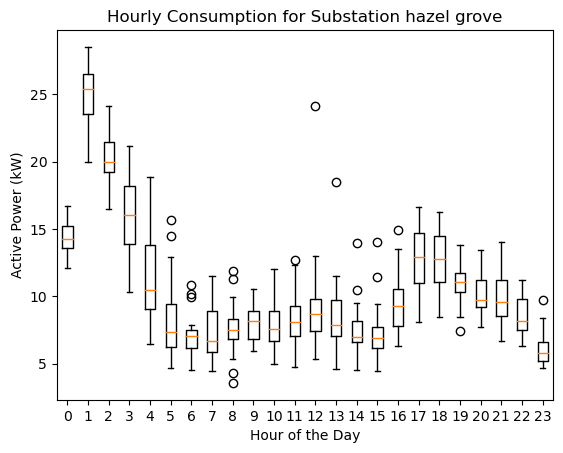

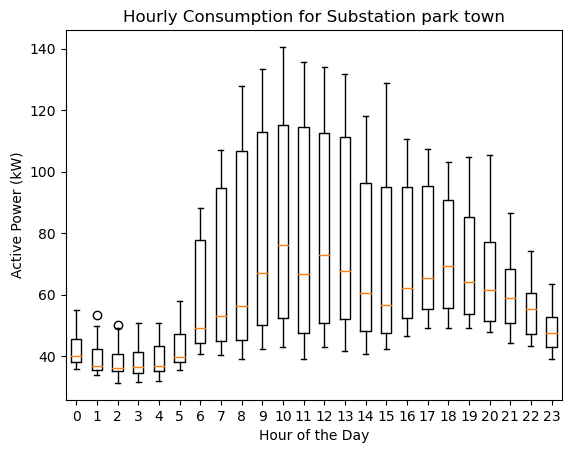

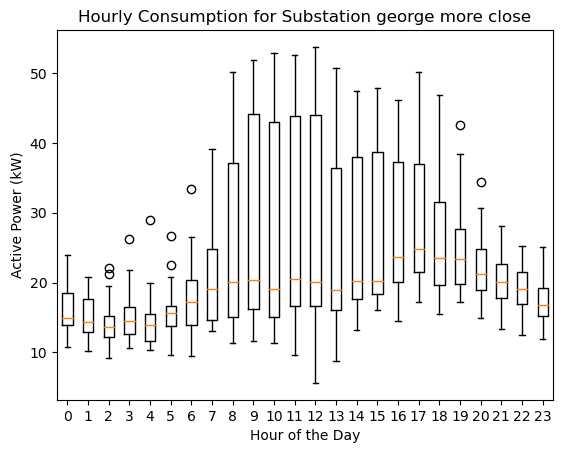

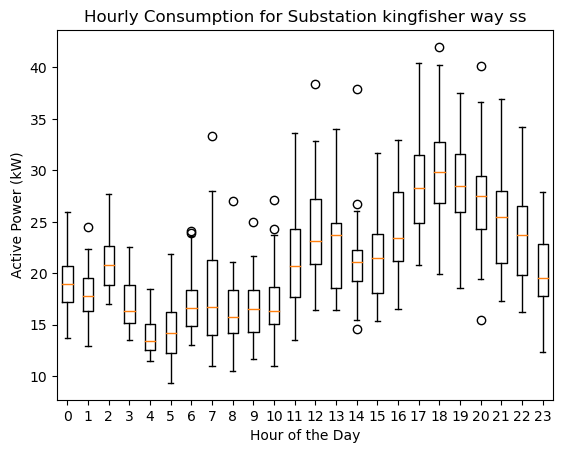

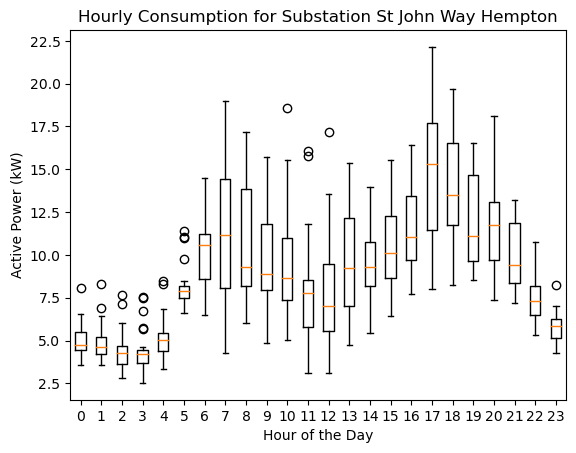

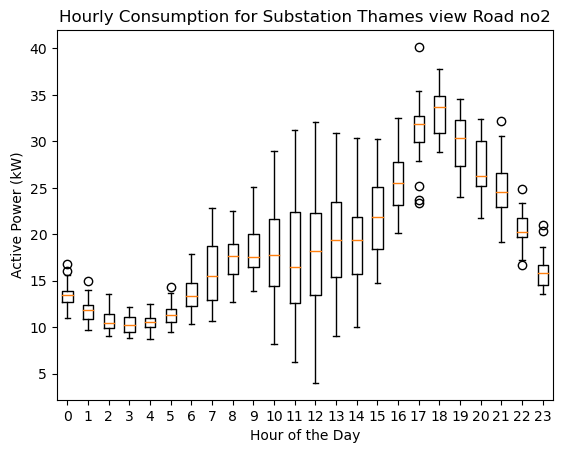

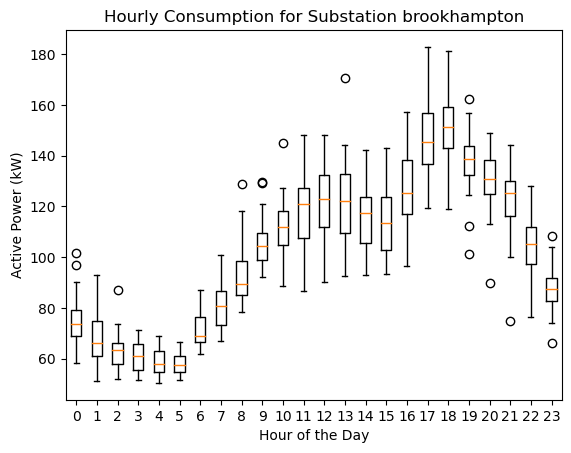

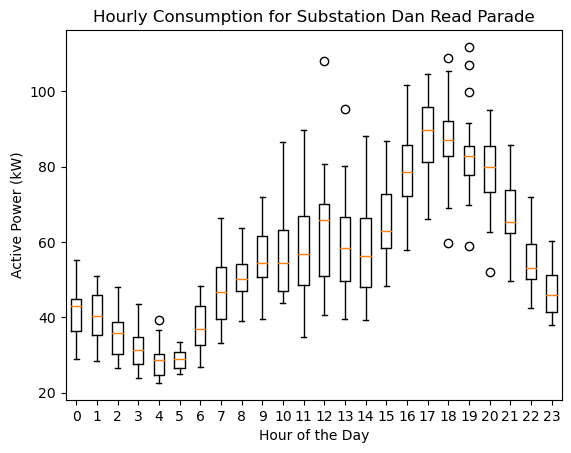

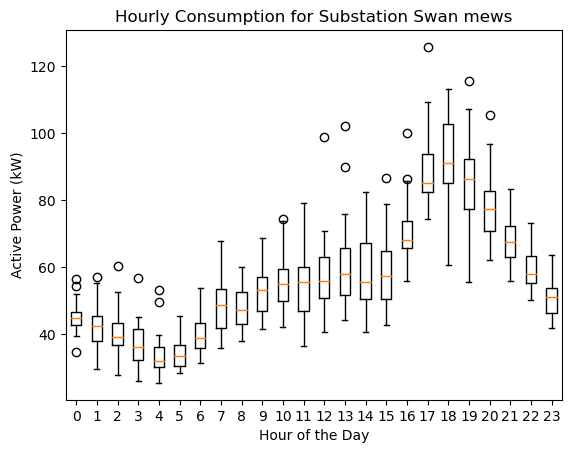

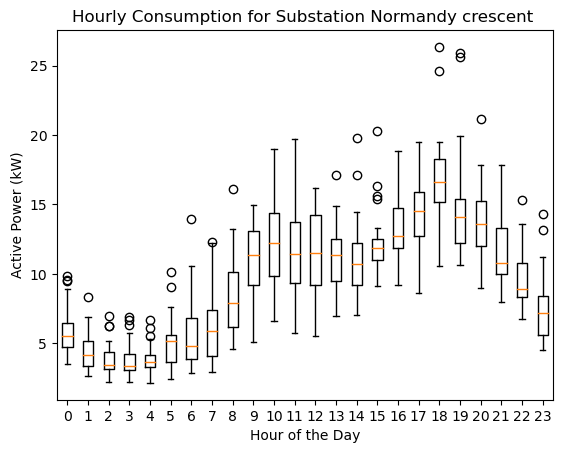

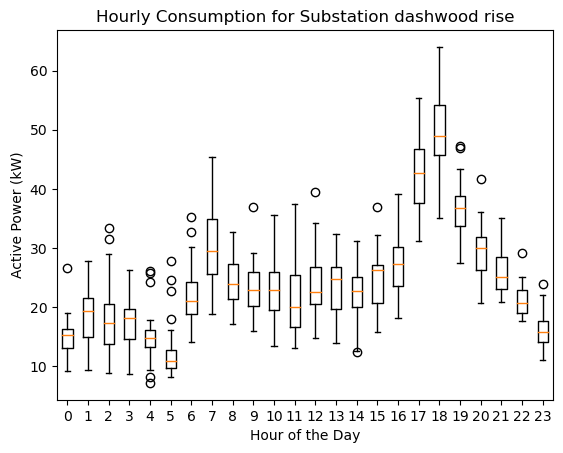

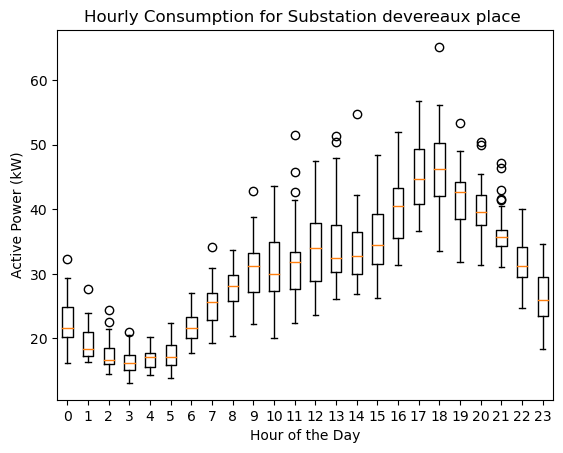

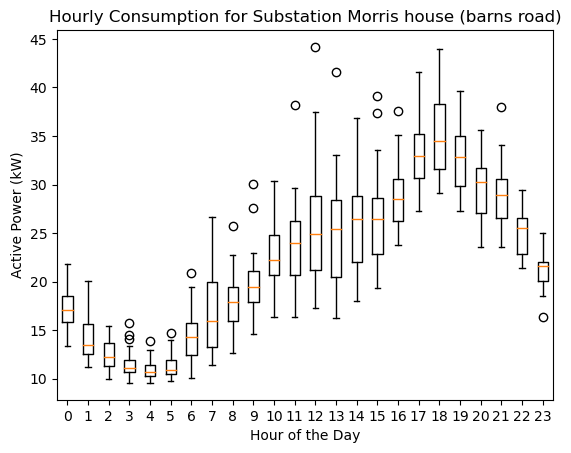

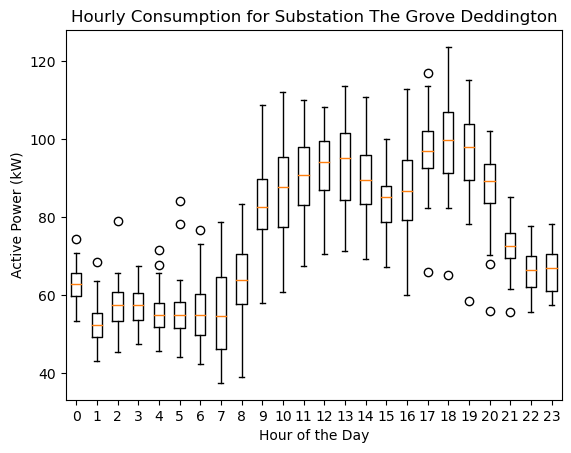

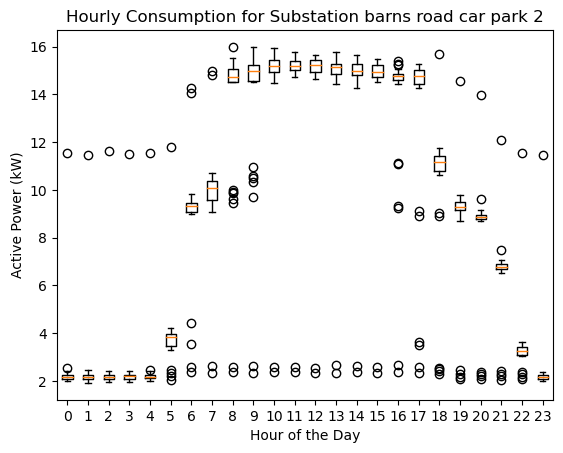

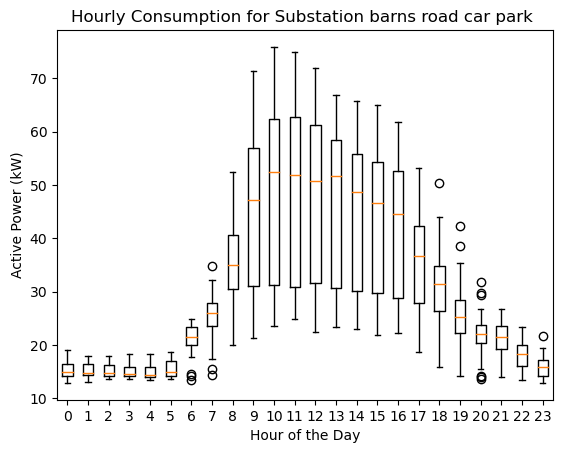

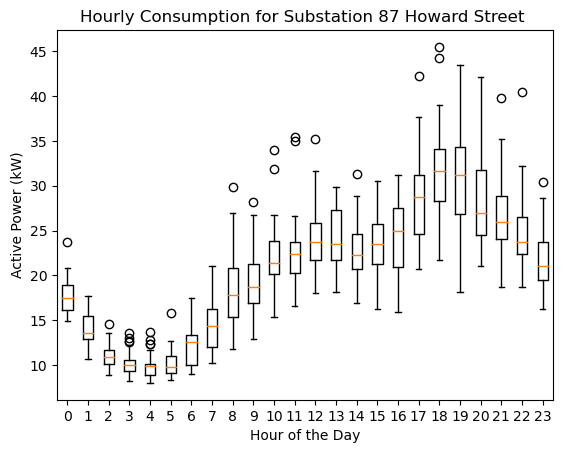

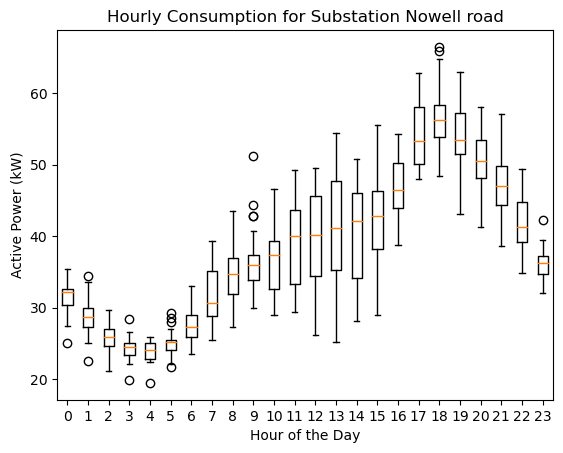

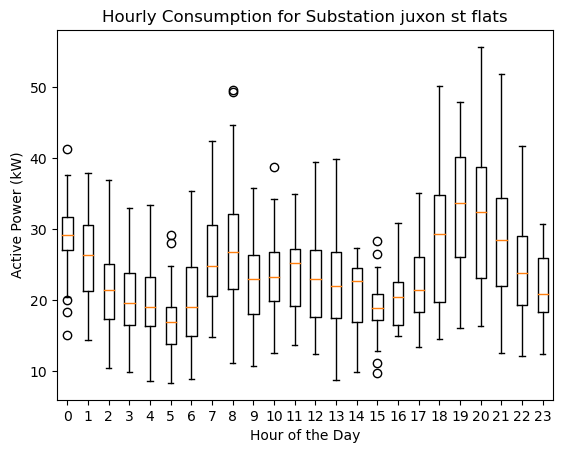

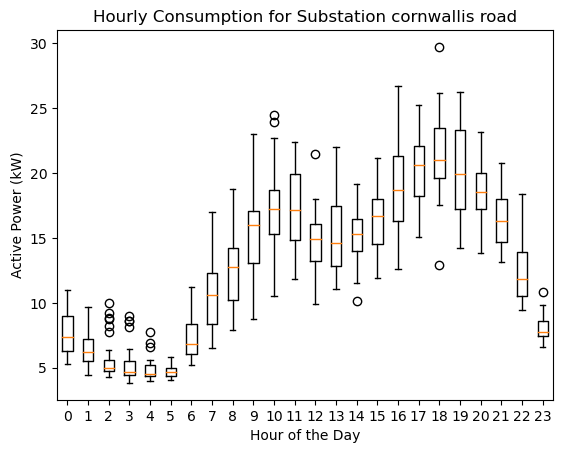

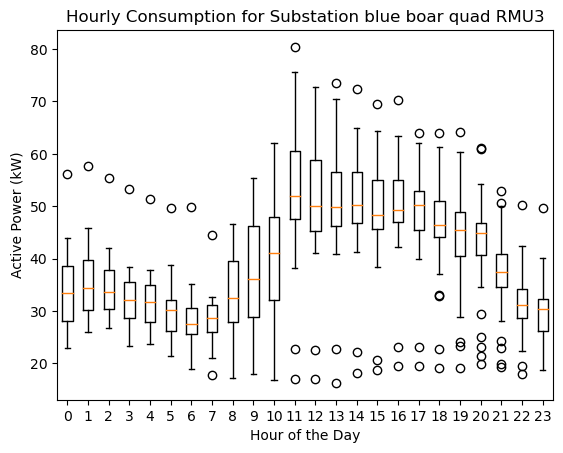

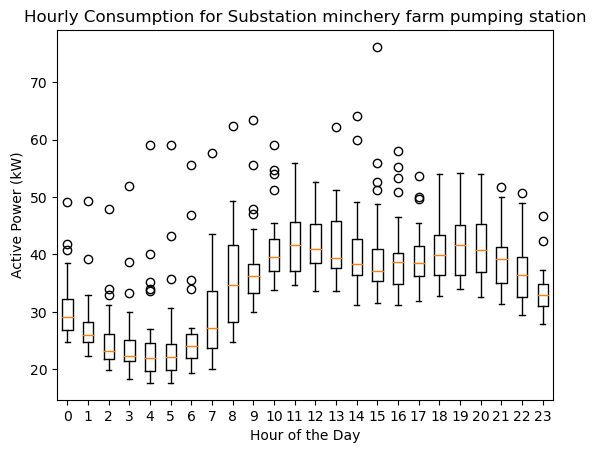

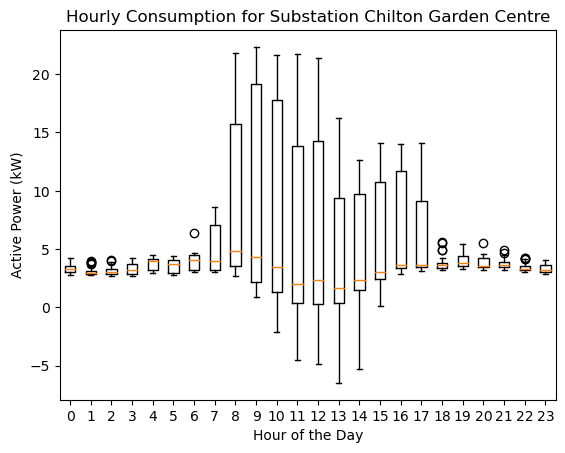

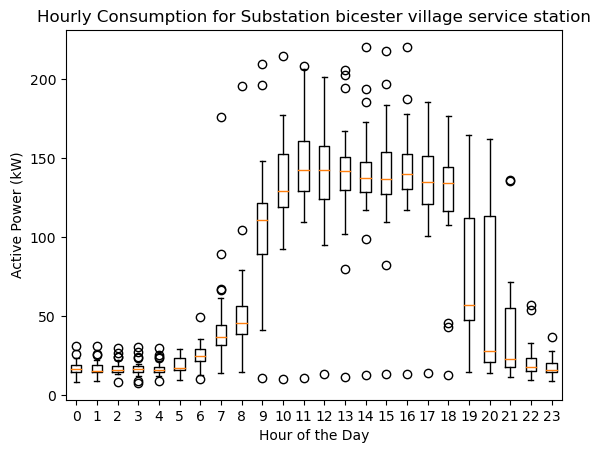

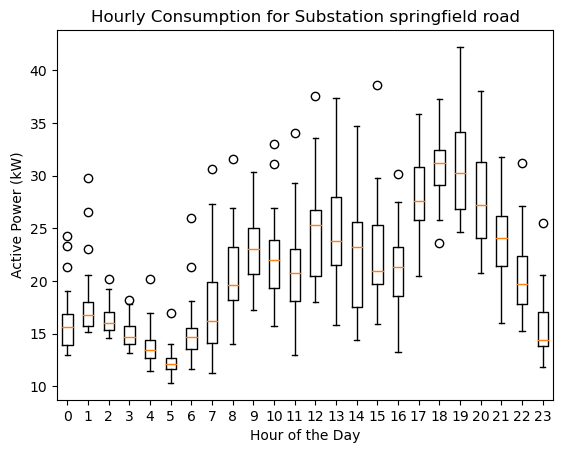

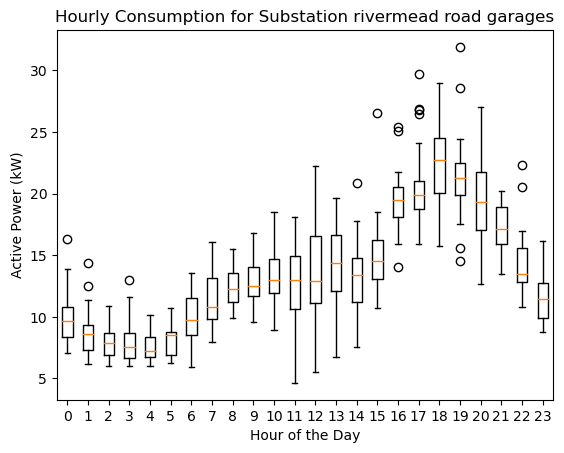

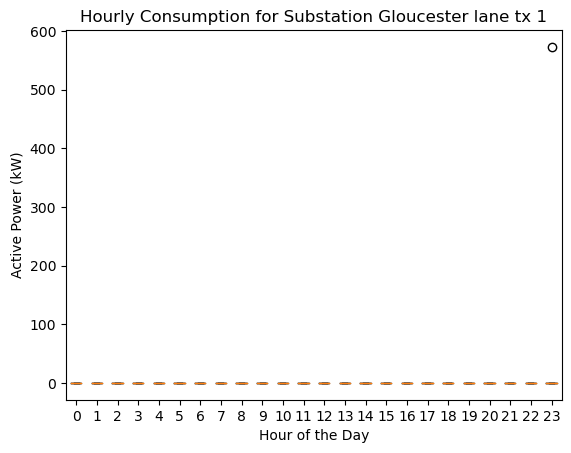

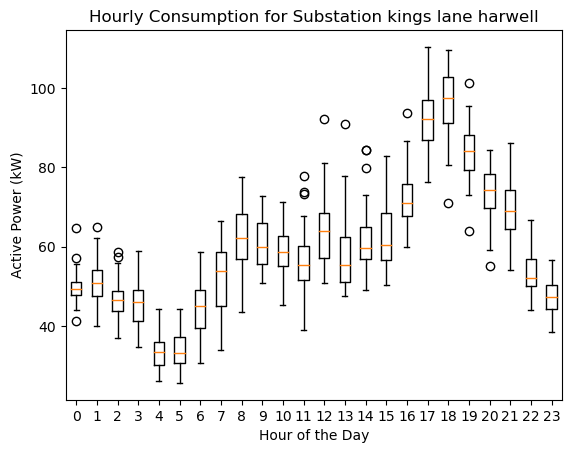

In [270]:
'''
This function takes in a dictionary of substation dataframes and plots a boxplot with hour of the day on the x-axis and active power (kW) on the y-axis for each substation
'''

def plot_hourly_consumption(substation_data):
    for substation, df in substation_data.items():
        # Extract the hour of the day from the timestamp
        df['hour'] = df['Datetime'].dt.hour
        
        # Create an empty list to store the data for each hour
        hourly_data = [[] for i in range(24)]
        # Add the active power (kW) data to the corresponding hour list
        for i, row in df.iterrows():
            hourly_data[row['hour']].append(row['Active Power [kW]'])

        # Create a box plot of the hourly data
        plt.boxplot(hourly_data,labels=range(24))
        plt.title(f'Hourly Consumption for Substation {substation}')
        plt.xlabel('Hour of the Day')
        plt.ylabel('Active Power (kW)')
        plt.show()
plot_hourly_consumption(dataframes)


### TODO: Distribution of peak hours for each substation separately </br>

For reactive power, separate substations based on positive / negative ones? 

### Clustering 

K-means: Clustering on Active Power and Reactive Power and Silhouette analysis to determine number of clusters

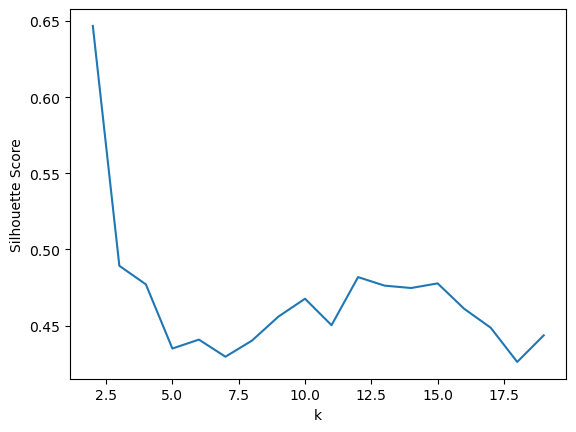

Clusters based on Active and Reactive Power
{'4618007040': 0, '4618006200': 2, '4605005013': 9, '4618006140': 0, '4606004360': 4, '4618003040': 4, '4626006080': 4, '4626001020': 16, '4614005070': 0, '4618002050': 16, '4618002020': 0, '4618008040': 4, '4618001080': 3, '4618005300': 4, '4626003090': 4, '4618003100': 18, '4618005120': 3, '4626003020': 10, '4904020100': 13, '4610003070': 14, '4618002030': 0, '4618007020': 13, '4618001220': 17, '4904022150': 0, '4626001360': 18, '4618002100': 0, '4911006040': 15, '4618005280': 3, '4626004180': 7, '4618002025': 0, '4614006040': 1, '4606002080': 7, '4618001020': 14, '4640005010': 3, '4618005240': 7, '4626001280': 4, '4606002020': 4, '4605002060': 6, '4626006020': 7, '4626004340': 14, '4626002080': 3, '4600006400': 4, '4600007020': 5, '4911006100': 0, '4626006150': 14, '4904001020': 3, '4602003070': 0, '4911006020': 14, '4011002280': 14, '4606001050': 3, '4907006120': 3, '4006003015': 16, '4910011180': 1, '4618003160': 14, '4605017240': 14, '4

In [190]:
# Define the number of clusters to test 
k_range = range(2, 20)


features_of_interest = []
for substation, substation_df in dataframes.items():
    # Extract features
    features_of_interest.append([substation_df['Active Power [kW]'].mean(),
              substation_df['Reactive Power [kVAr]'].mean()])

silhouette_scores = []
for k in k_range:
    # Perform K-means clustering
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(features_of_interest)
    
    # Calculate silhouette score for this k
    silhouette_scores.append(silhouette_score(features_of_interest, kmeans.labels_))

# Plot the silhouette scores
plt.plot(k_range, silhouette_scores)
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.show()

# Assign cluster labels to substations
substation_clusters = {}
for i, substation in enumerate(dataframes.keys()):
    substation_clusters[substation] = kmeans.labels_[i]

# Print the cluster assignments
print("Clusters based on Active and Reactive Power")
print(substation_clusters)
    

K-means: Clustering based on RMS, Variance, Kurtosis, and STFT Smoothness and Silhouette analysis to determine number of clusters

RMS Clustering


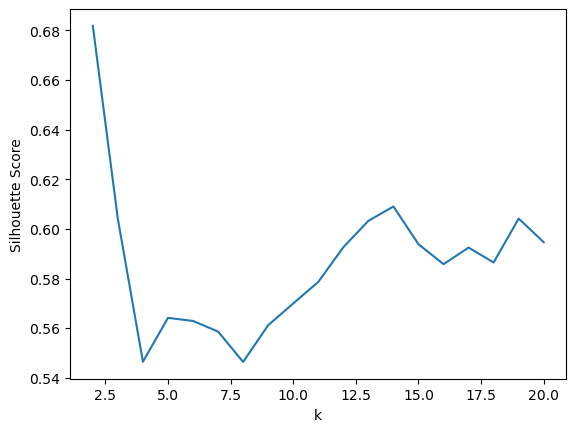

Variance Clustering


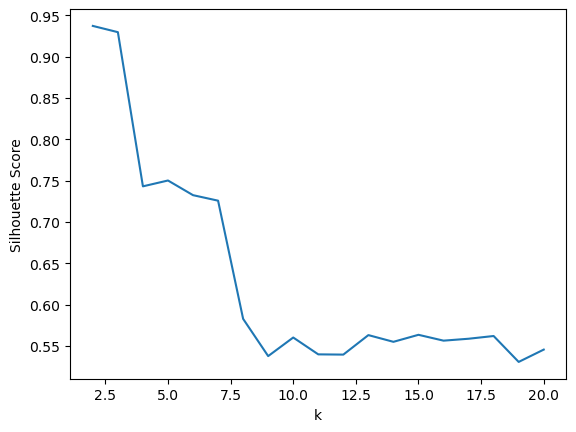

Kurtosis Clustering


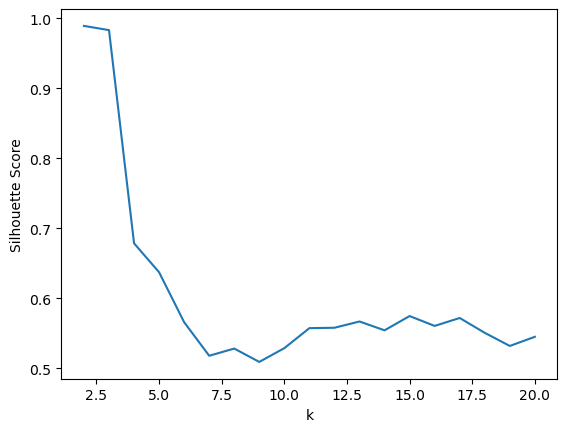

STFT Clustering


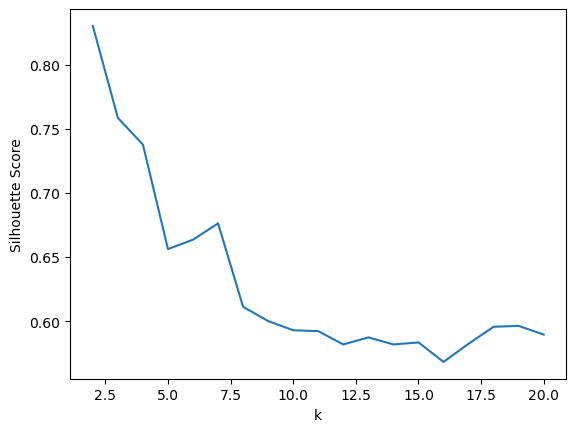

In [209]:

def k_means(substation_dataframes, k_range):
    
    features_of_interest = []
    
    
    for substation, metric in substation_dataframes.items():
        # Extract features - there is only one value per dataframe for each of the smoothness metrics, so we can just use the entire object 
        features_of_interest.append([metric])

    all_substation_clusters = {}
    silhouette_scores = []
    for k in k_range:
        # Perform K-means clustering
        kmeans = KMeans(n_clusters = k)
        kmeans.fit(features_of_interest)
        
        # Calculate silhouette score for this k
        silhouette_scores.append(silhouette_score(features_of_interest, kmeans.labels_))

        # Assign cluster labels to substations
        substation_clusters = {}
        for i, substation in enumerate(substation_dataframes.keys()):
            substation_clusters[substation] = kmeans.labels_[i]

        # Save the cluster assignments 
        all_substation_clusters[k] = substation_clusters
        
    # Plot the silhouette scores
    plt.plot(k_range, silhouette_scores)
    plt.xlabel("k")
    plt.ylabel("Silhouette Score")
    plt.show()
    
    
    return all_substation_clusters

k_range = range(2,21)

print("RMS Clustering")
rms_clusters = k_means(rms, k_range)

print("Variance Clustering")
var_clusters =k_means(var, k_range)

print("Kurtosis Clustering")
kur_clusters =k_means(kur, k_range)

print("STFT Clustering")
stft_clusters =k_means(stft_smoothness, k_range)





Comparing cluster outputs

In [268]:
# NOTE: This approach assumes the keys are in the same order for all dictionaries (which I think actually works here, since even though the are hashed it was run the same way and it gives the same answers every time it is run)

# TODO: Save these values in a dictionary and compare between k's 

for k in k_range:
    print("k = ", k)
    
    # Compare count and percentage of matching cluster assignments between RMS and Variance
    print("# matching between RMS and Var:", sum(a == b for a,b in zip(rms_clusters[k].values(), var_clusters[k].values())))
    print("% matching between RMS and Var:", round(sum(a == b for a,b in zip(rms_clusters[k].values(), var_clusters[k].values())) / len(var_clusters[k].values()), 3))

    # Compare count and percentage of matching cluster assignments between all lists
    print("# matching between all lists:", sum(a == b and b == c and c == d for a,b,c,d in zip(rms_clusters[k].values(), var_clusters[k].values(), kur_clusters[k].values(), stft_clusters[k].values())))
    print("# matching between all lists:", round(sum(a == b and b == c and c == d for a,b,c,d in zip(rms_clusters[k].values(), var_clusters[k].values(), kur_clusters[k].values(), stft_clusters[k].values())) / len(var_clusters[k].values()), 3))
    
    print("\n")



k =  2
# matching between RMS and Var: 67
% matching between RMS and Var: 0.859
# matching between all lists: 63
# matching between all lists: 0.808


k =  3
# matching between RMS and Var: 21
% matching between RMS and Var: 0.269
# matching between all lists: 11
# matching between all lists: 0.141


k =  4
# matching between RMS and Var: 37
% matching between RMS and Var: 0.474
# matching between all lists: 27
# matching between all lists: 0.346


k =  5
# matching between RMS and Var: 16
% matching between RMS and Var: 0.205
# matching between all lists: 0
# matching between all lists: 0.0


k =  6
# matching between RMS and Var: 7
% matching between RMS and Var: 0.09
# matching between all lists: 1
# matching between all lists: 0.013


k =  7
# matching between RMS and Var: 13
% matching between RMS and Var: 0.167
# matching between all lists: 1
# matching between all lists: 0.013


k =  8
# matching between RMS and Var: 14
% matching between RMS and Var: 0.179
# matching between al

### Plot substations on a map

In [ ]:
# get location data 

Next steps:
Analyze the substations that are outliers on the peak hours histogram

# 25/01/2023

Goal: Identify weird substations

### Distribution of peak hours for each substation separately 



Active / Reactive Power

In [210]:
def plot_peak_hour_distributions(dataframes, active):
    for substation, substation_data in dataframes.items():
        substation_data['Date'] = substation_data['Datetime'].dt.date
        substation_data['Hour'] = substation_data['Datetime'].dt.hour
        
        # Group the data by date
        daily_groups = substation_data.groupby(['Date'])

        if active:
        # Find the hour of peak Active Power for each date 
            peak_hour = daily_groups['Active Power [kW]'].idxmax().map(lambda x: substation_data.loc[x, 'Hour'])
                        # Count the number of times each hour appears as the peak hour for each day
            peak_counts = peak_hour.value_counts()
            
            plt.bar(peak_counts.index, peak_counts.values)
            plt.xlabel('Hour of the day')
            plt.ylabel('Frequency of being peak hour')
            plt.title(f'Peak Hour Distribution for {substation}')
            plt.show()
            
        else:
                # Find the hour of peak positive and negative Reactive power for each day
            peak_hour_max = daily_groups['Reactive Power [kVAr]'].idxmax().map(lambda x: substation_data.loc[x, 'Hour'])
            peak_hour_min = daily_groups['Reactive Power [kVAr]'].idxmin().map(lambda x: substation_data.loc[x, 'Hour'])
            
                # Count the number of times each hour appears as the peak hour for each day
            peak_counts_max = peak_hour_max.value_counts()
            peak_counts_min = peak_hour_min.value_counts()
            
            plt.bar(peak_counts_max.index, peak_counts_max.values)
            plt.xlabel('Hour of the day')
            plt.ylabel('Frequency of being peak hour')
            plt.title(f'Positive Reactive Power Peak Hour Distribution for {substation}')
            plt.show()
            plt.bar(peak_counts_min.index, peak_counts_min.values)
            plt.xlabel('Hour of the day')
            plt.ylabel('Frequency of being peak hour')
            plt.title(f'Negative Reactive Power Peak Hour Distribution for {substation}')
            plt.show()



Reactive Power

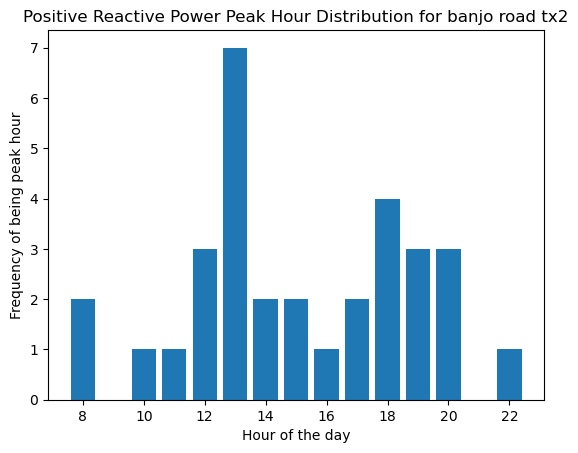

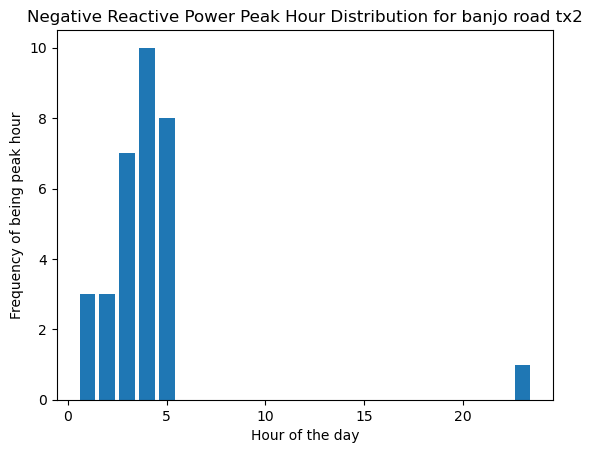

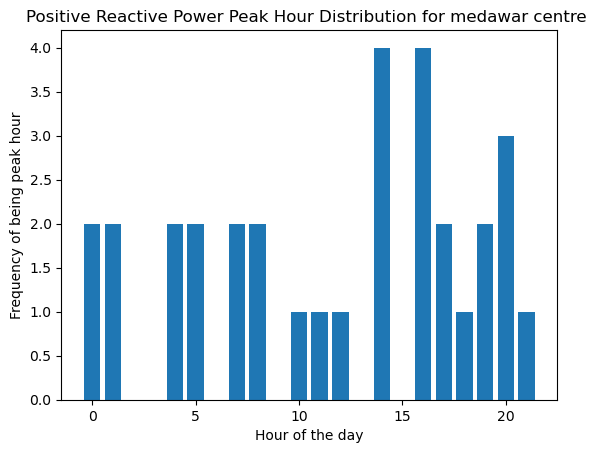

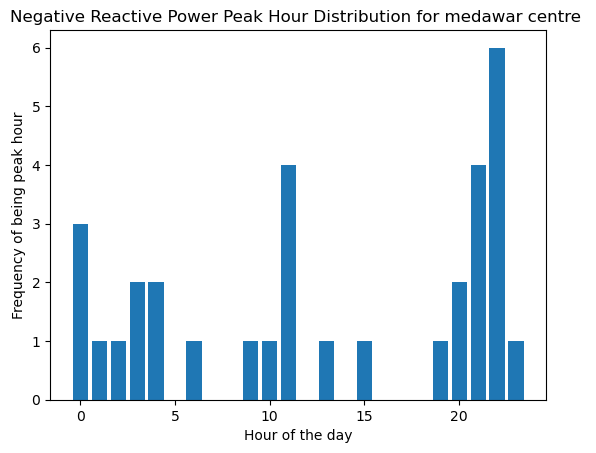

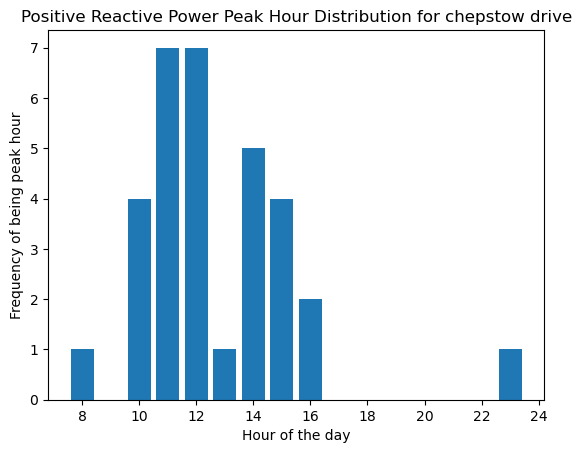

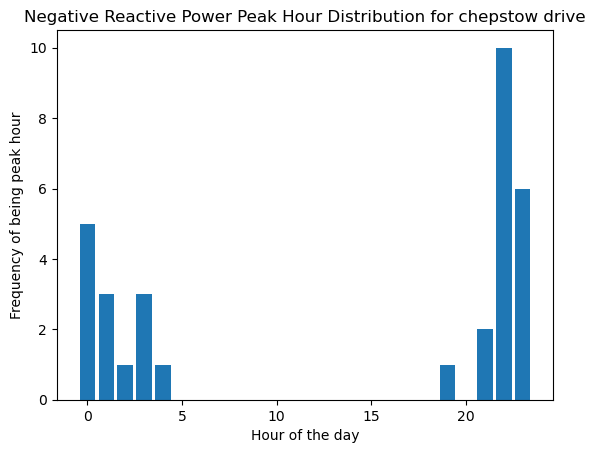

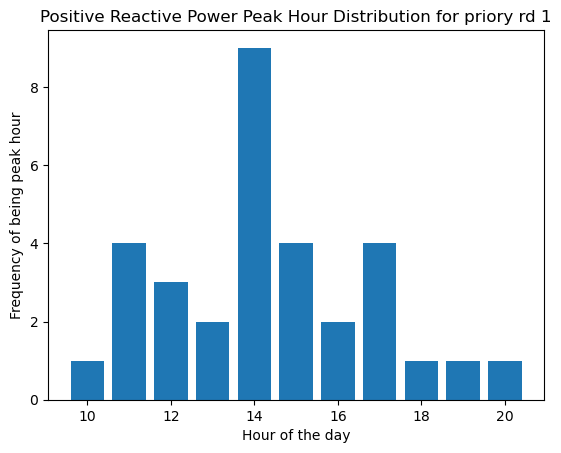

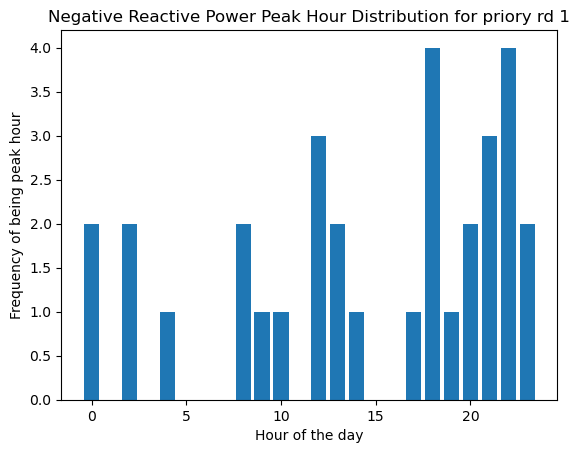

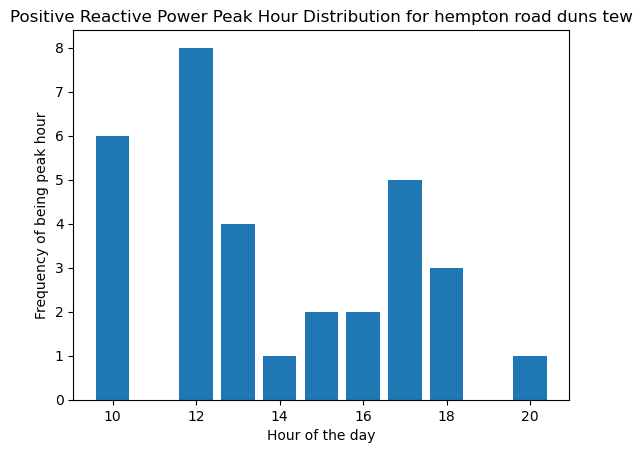

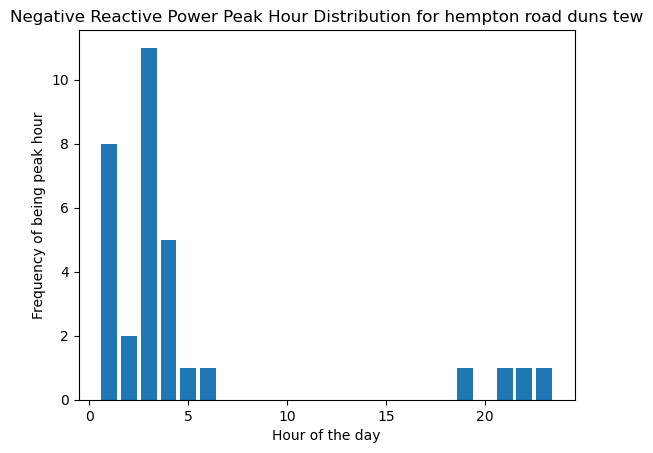

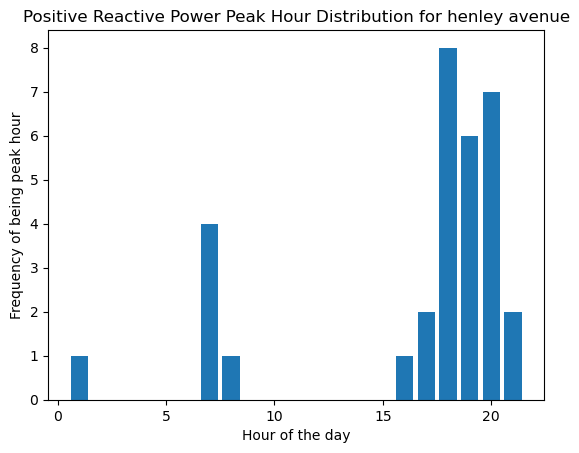

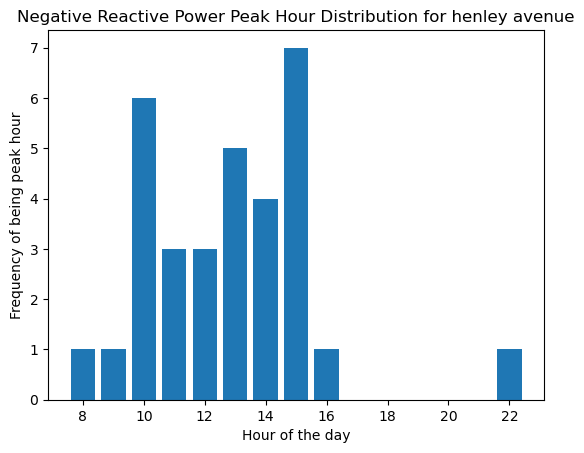

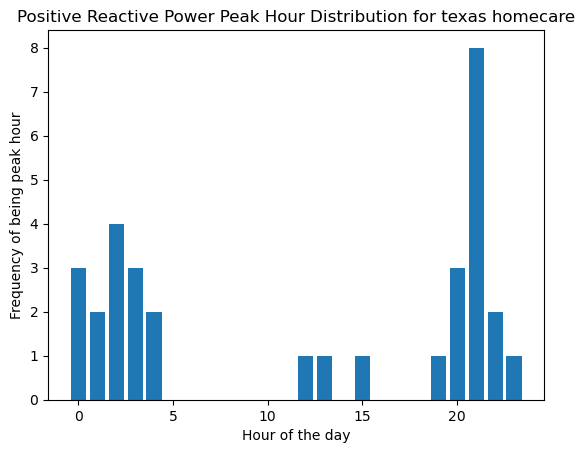

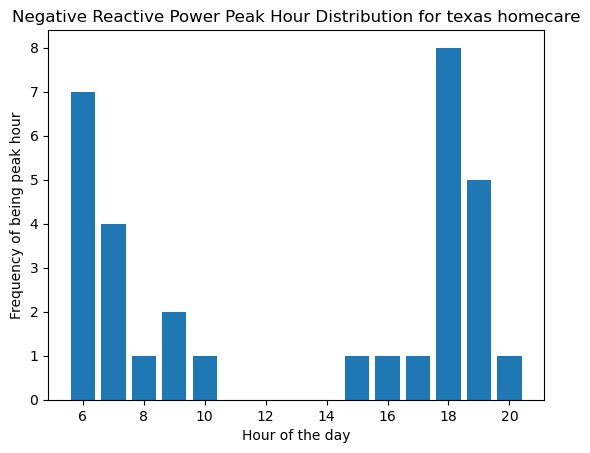

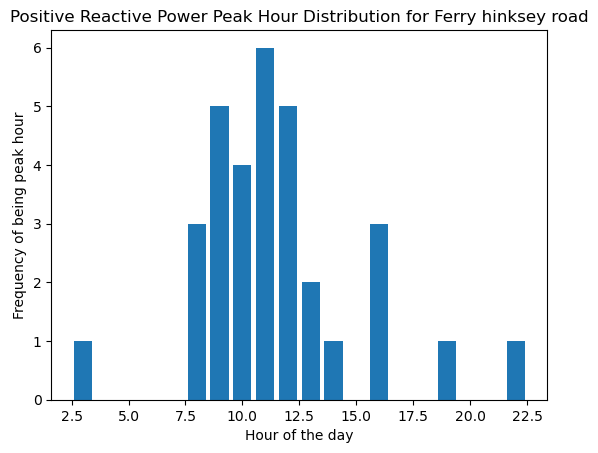

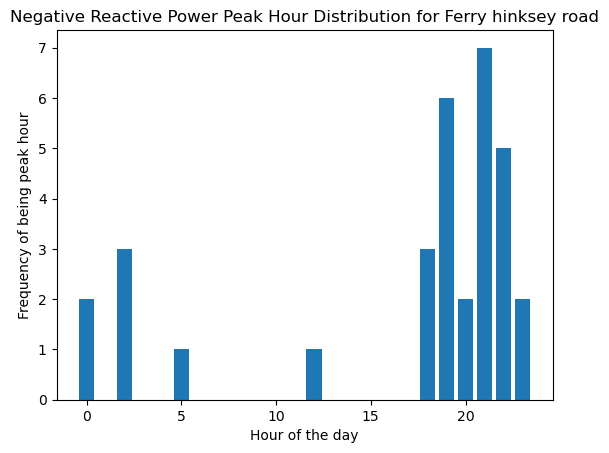

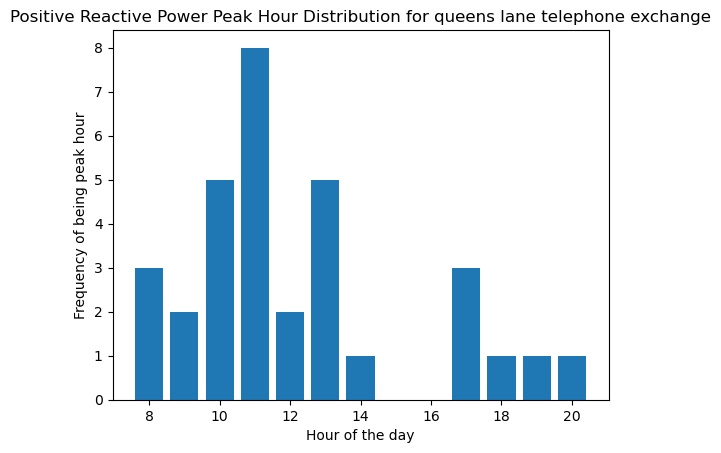

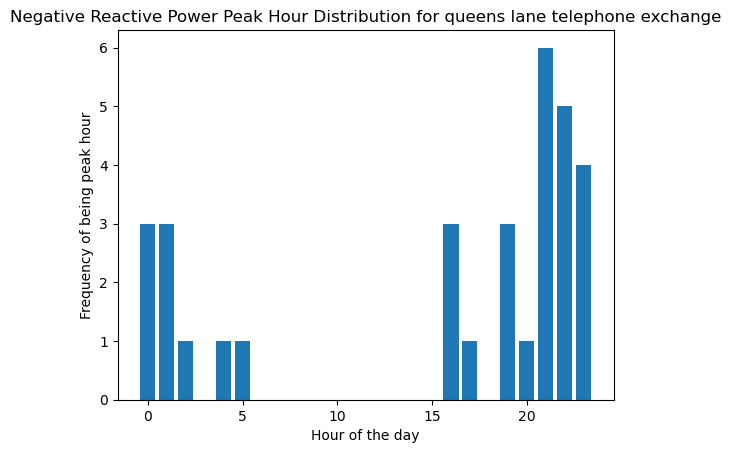

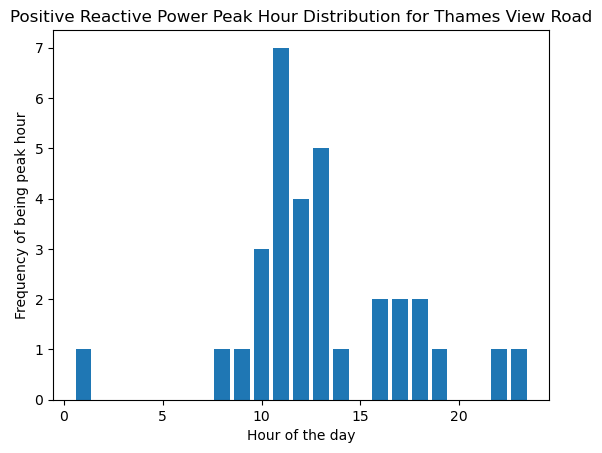

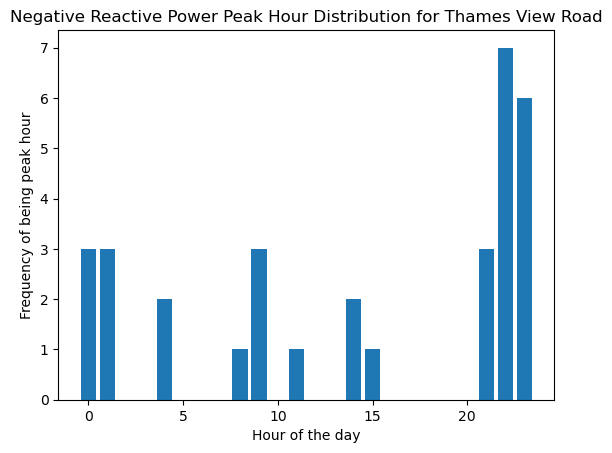

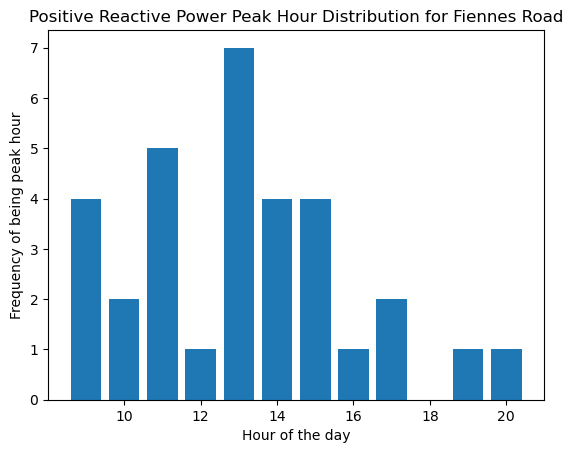

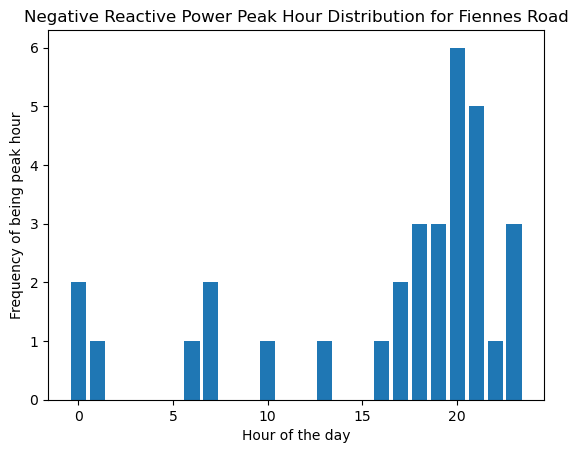

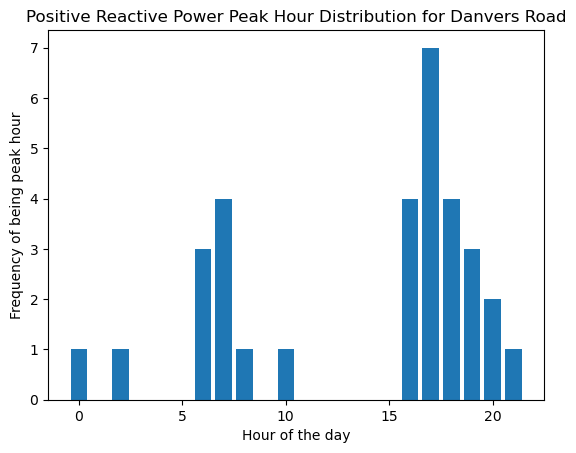

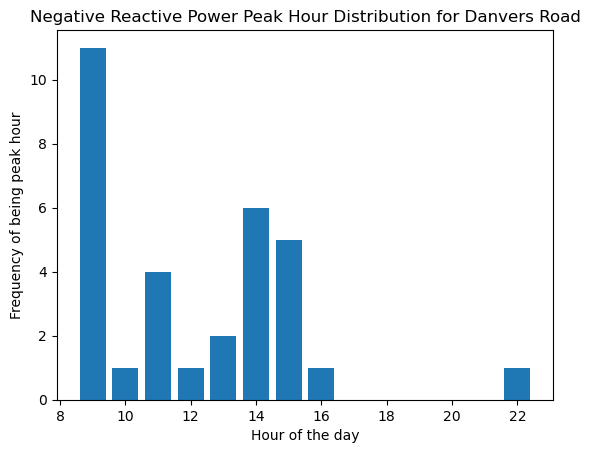

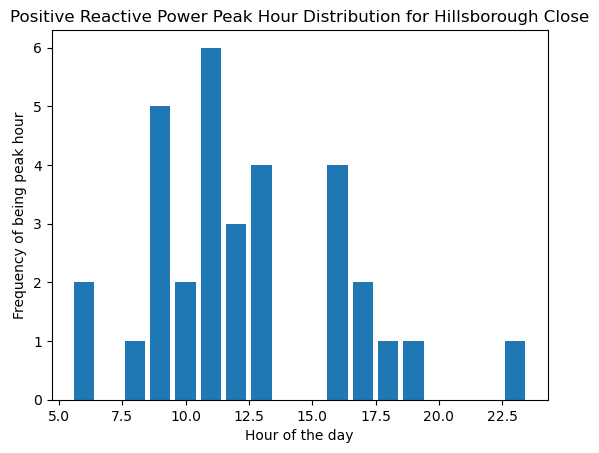

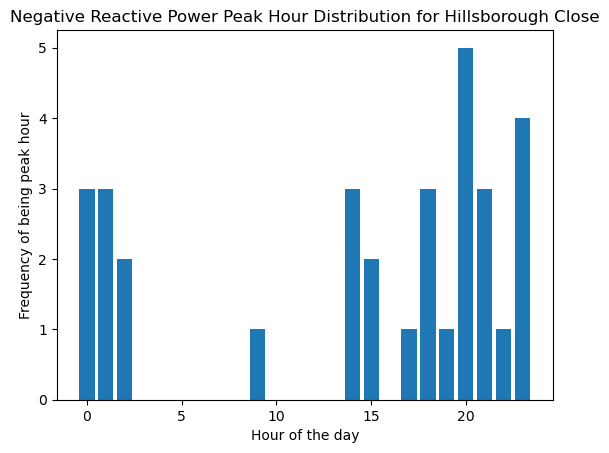

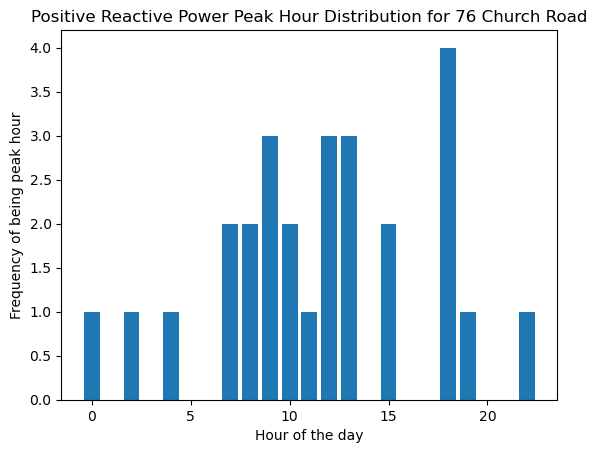

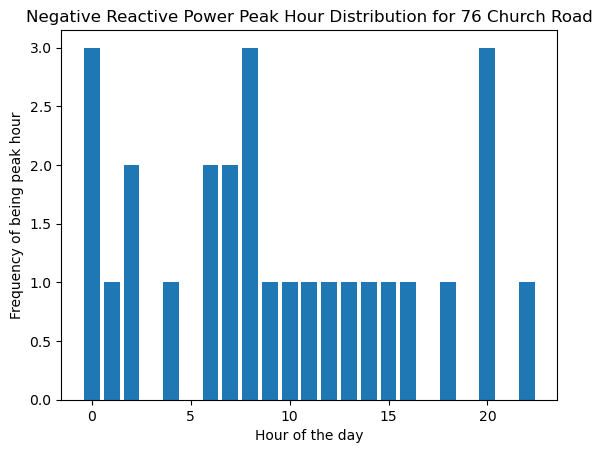

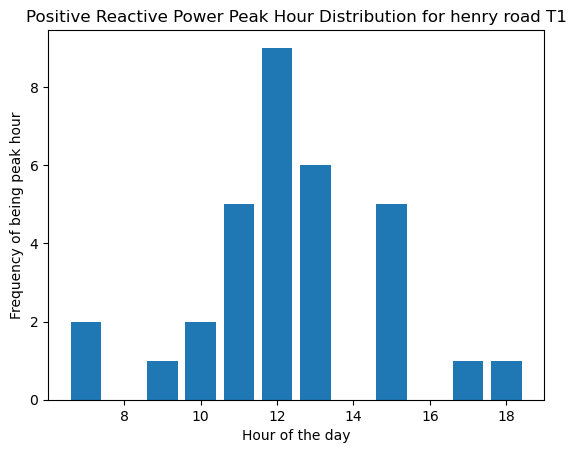

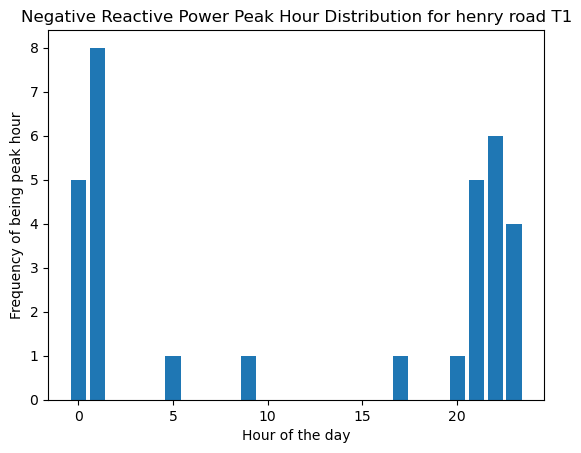

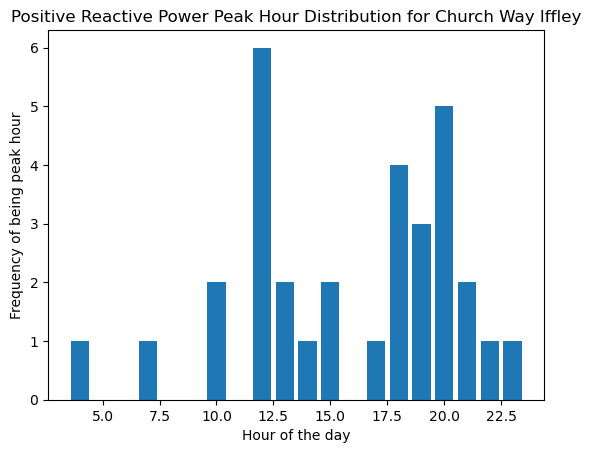

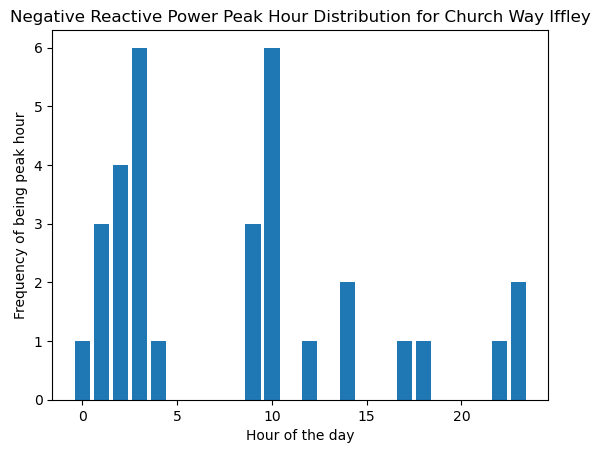

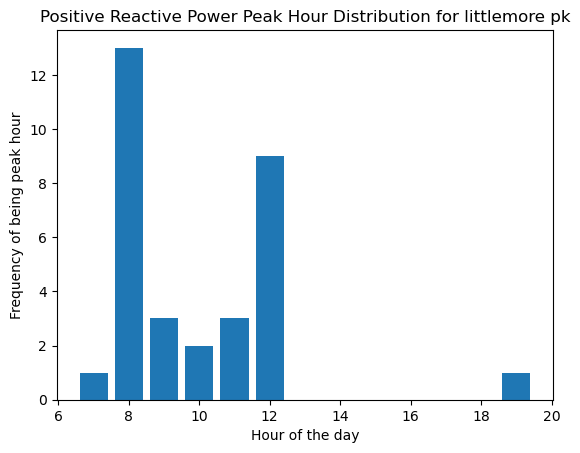

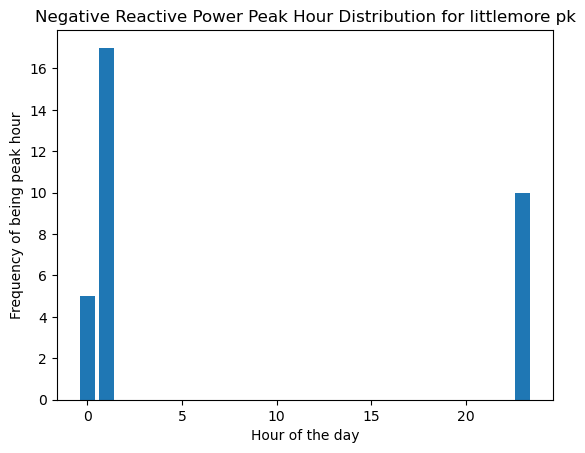

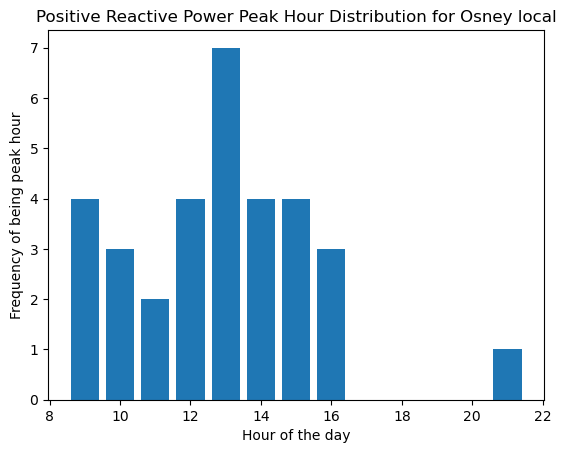

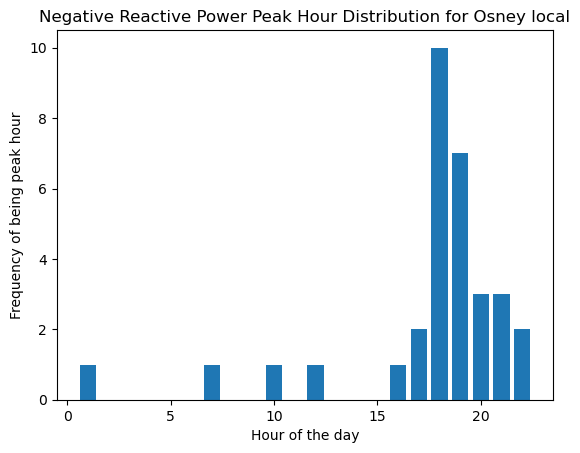

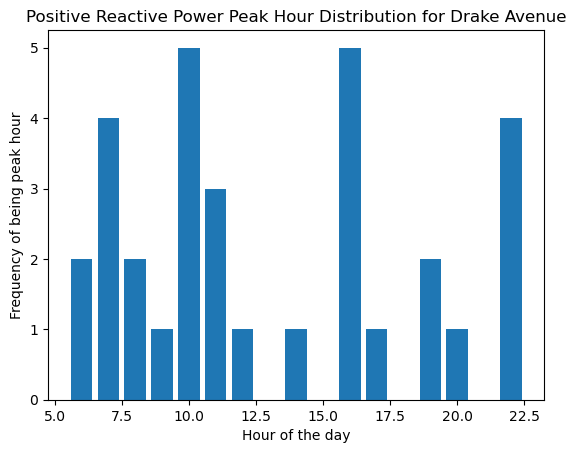

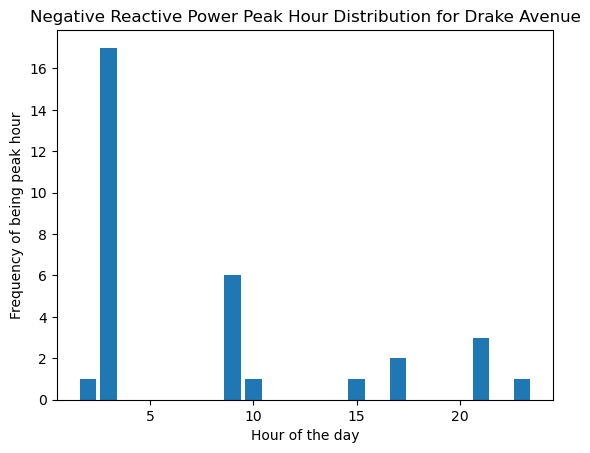

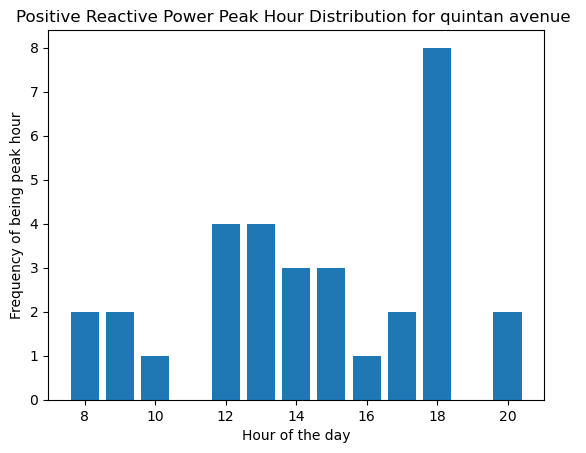

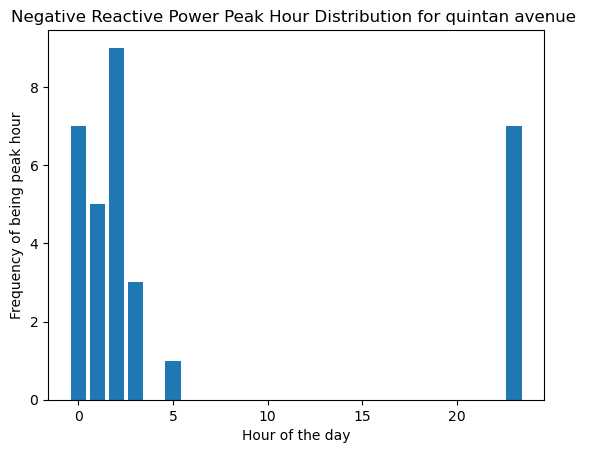

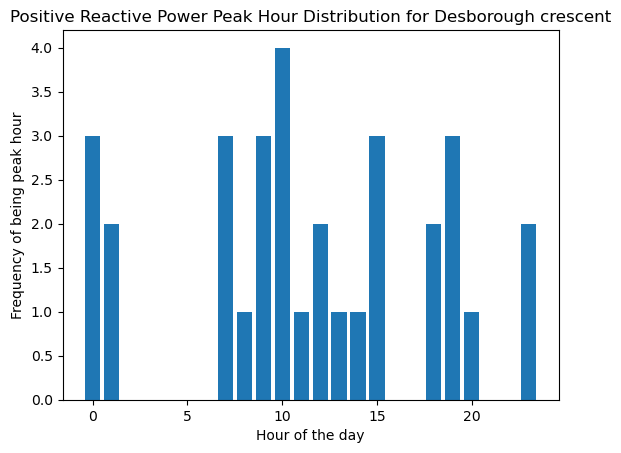

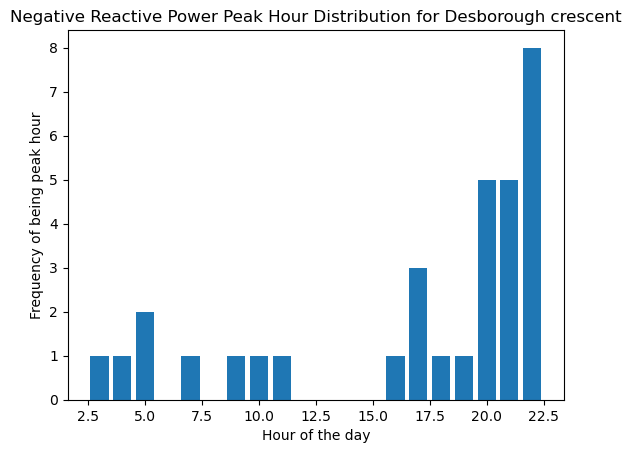

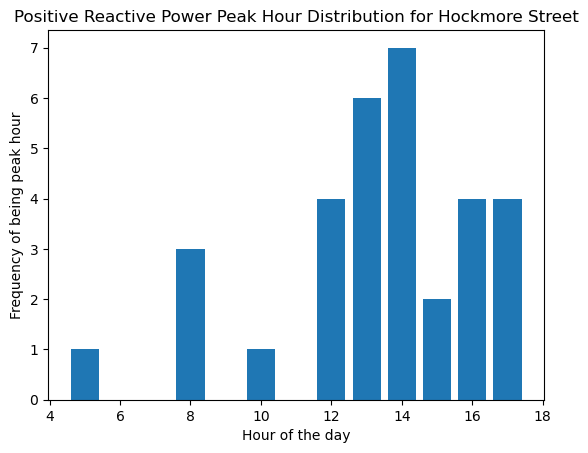

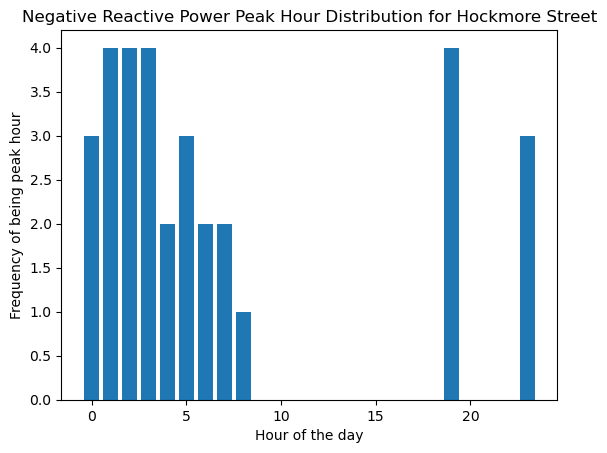

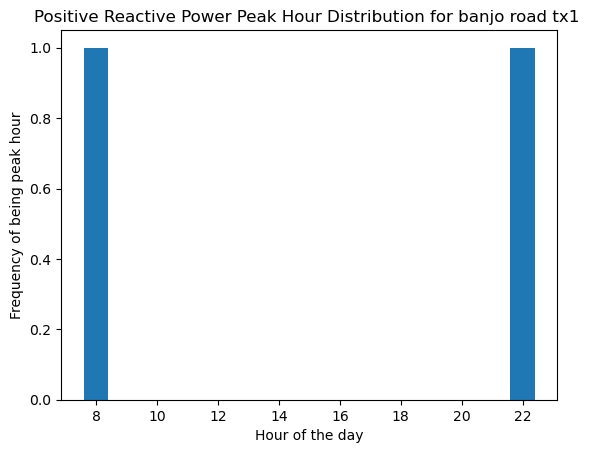

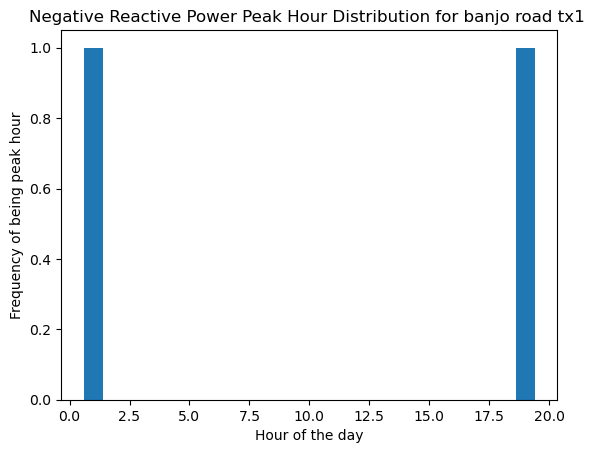

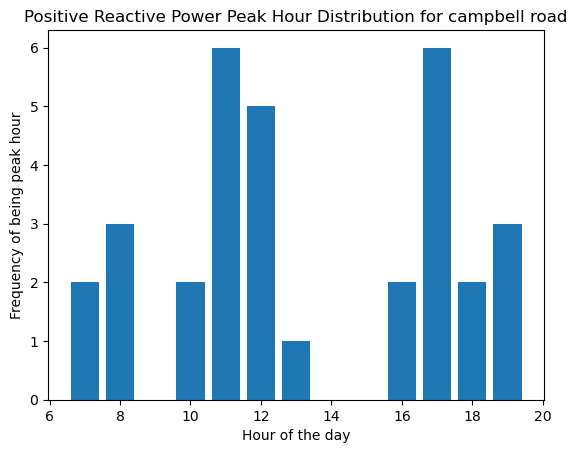

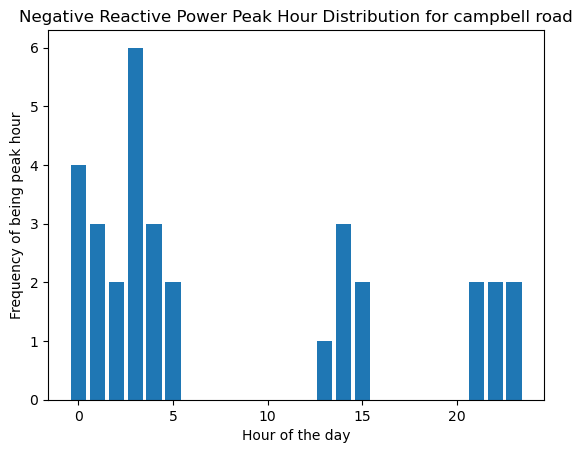

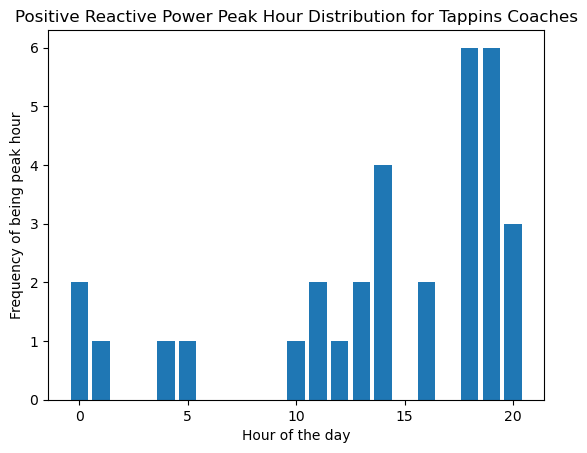

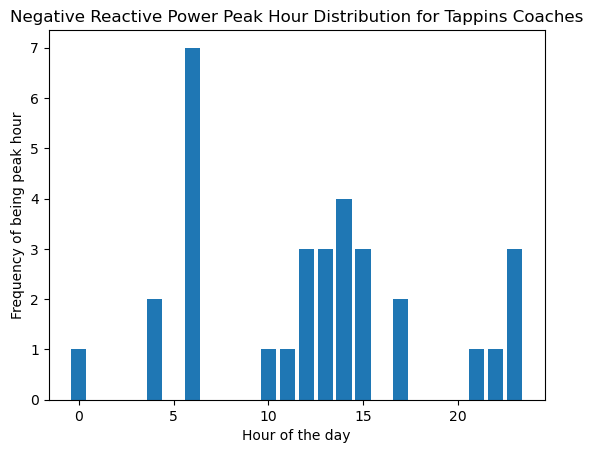

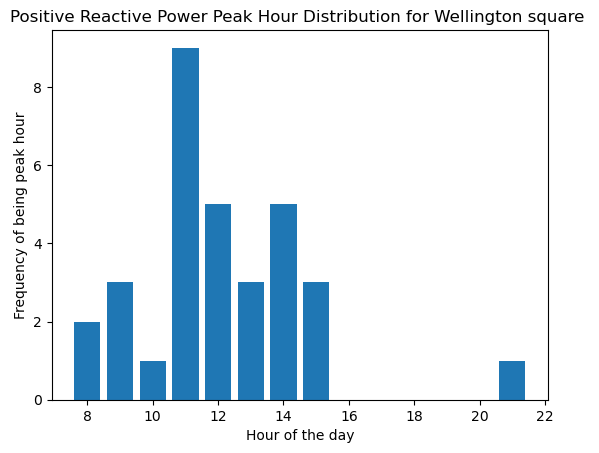

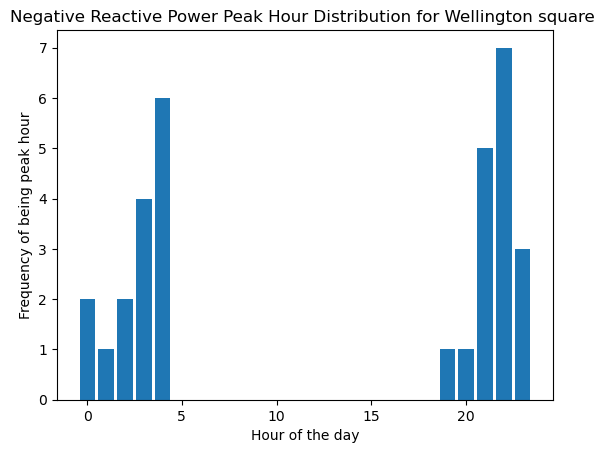

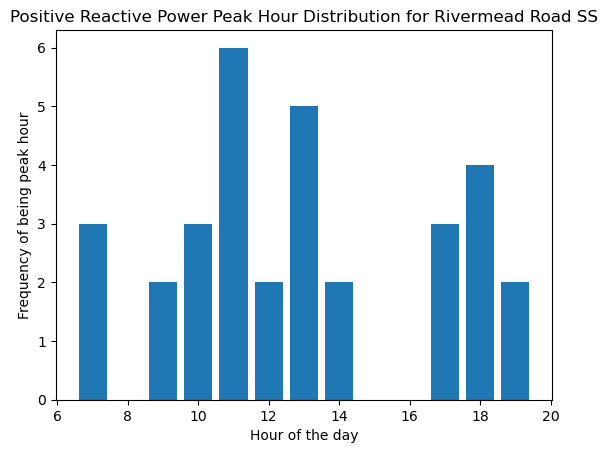

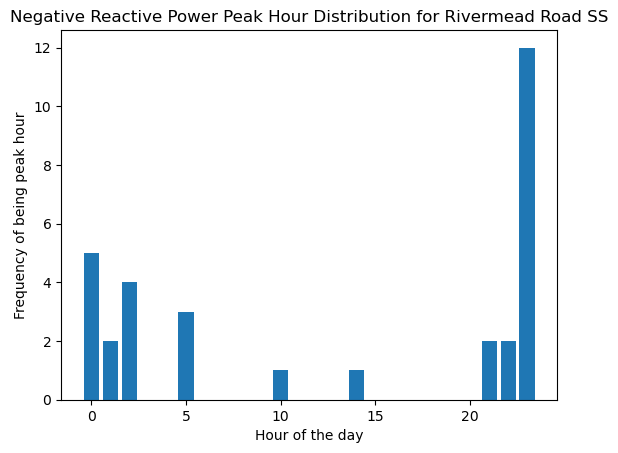

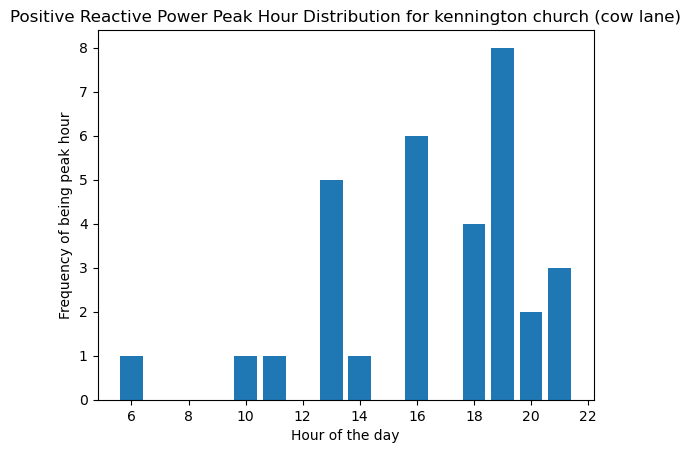

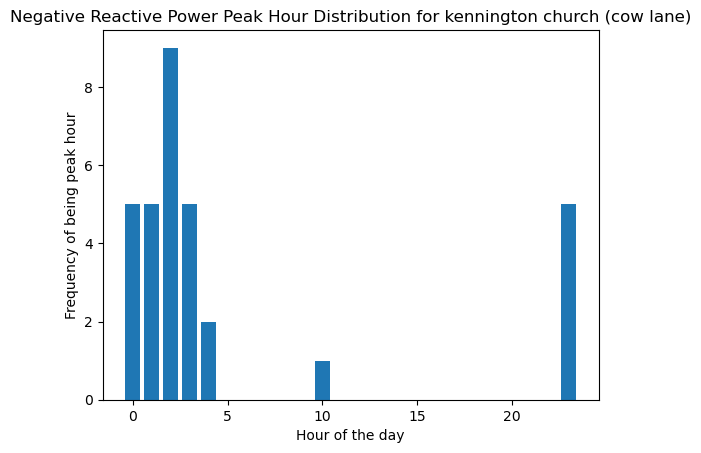

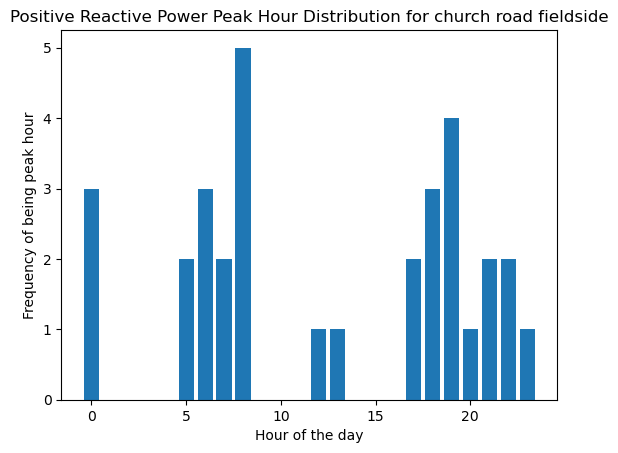

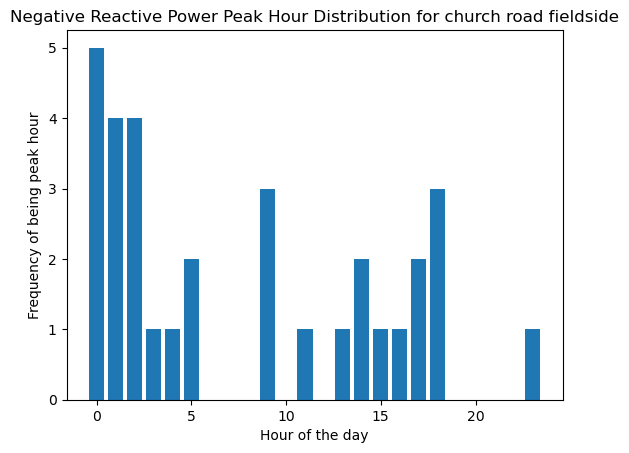

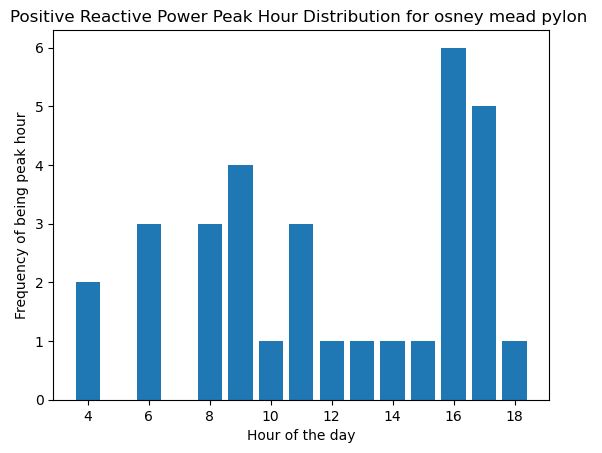

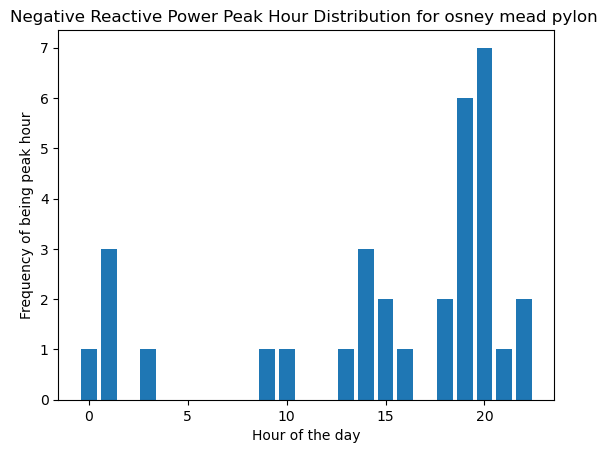

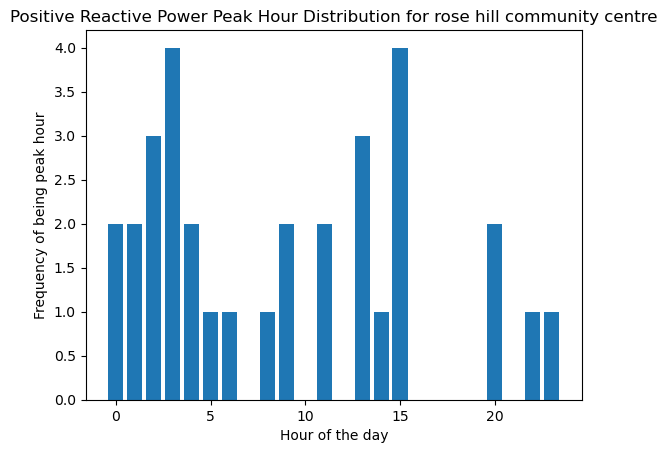

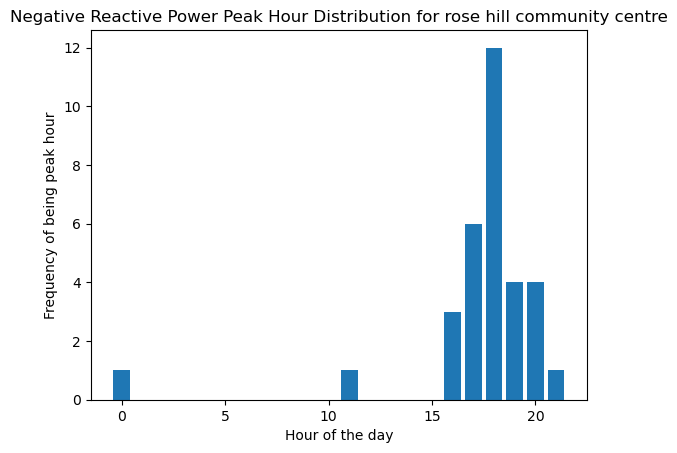

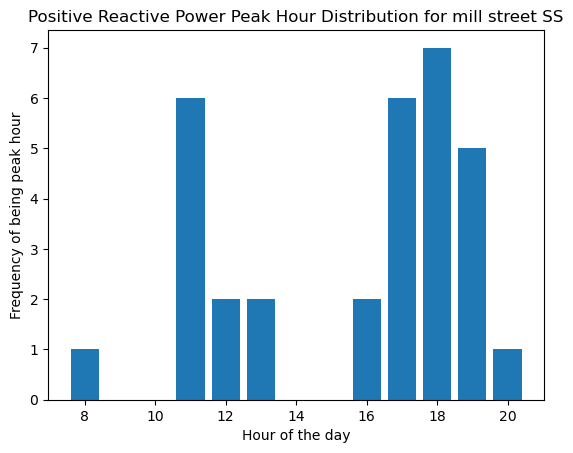

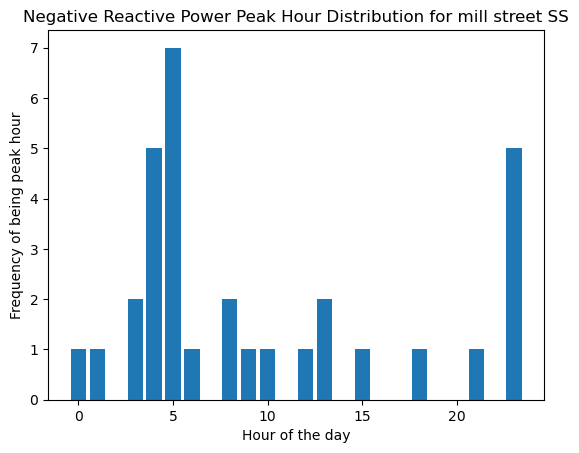

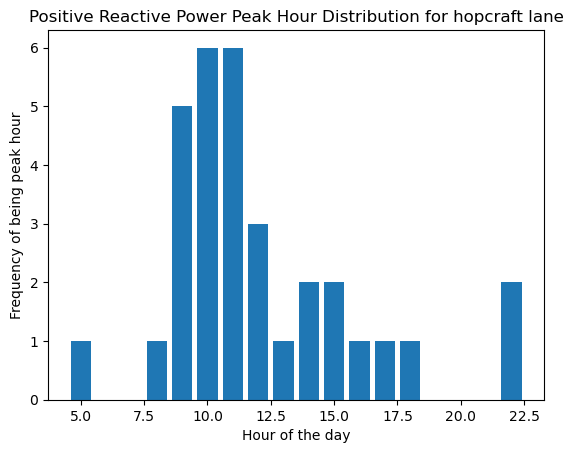

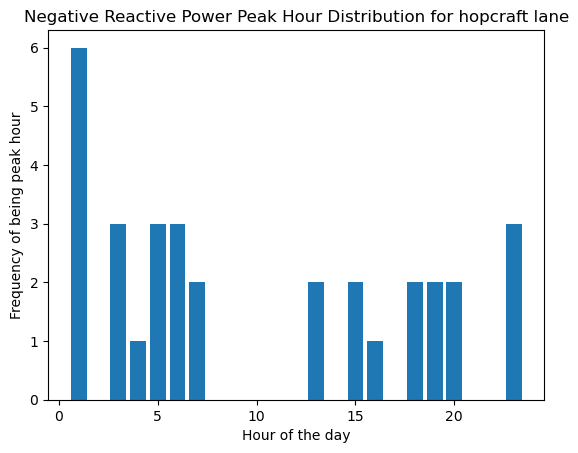

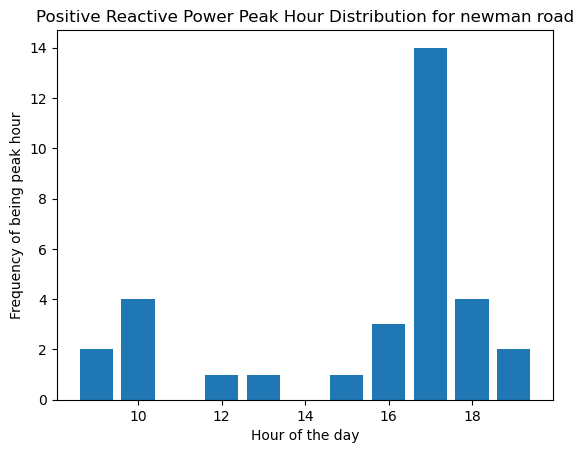

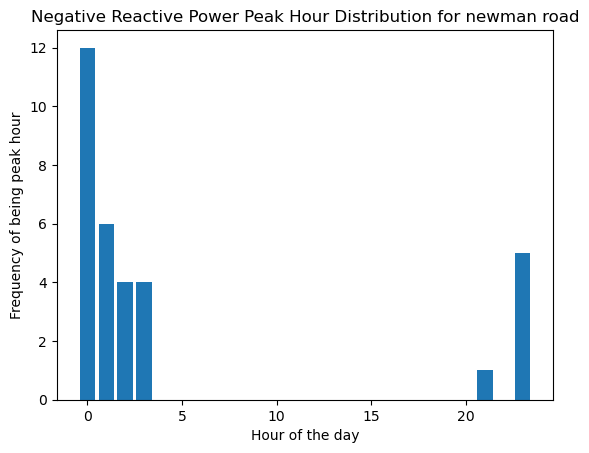

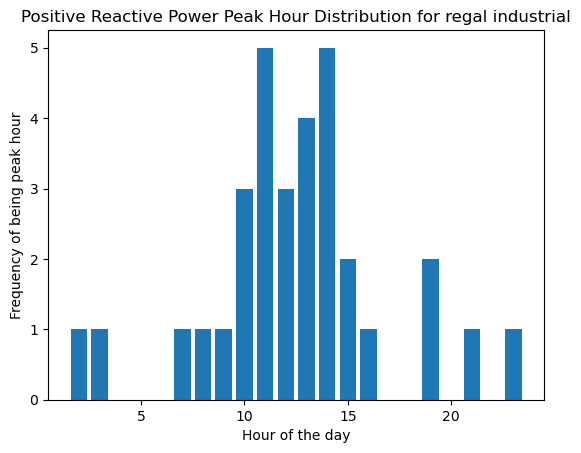

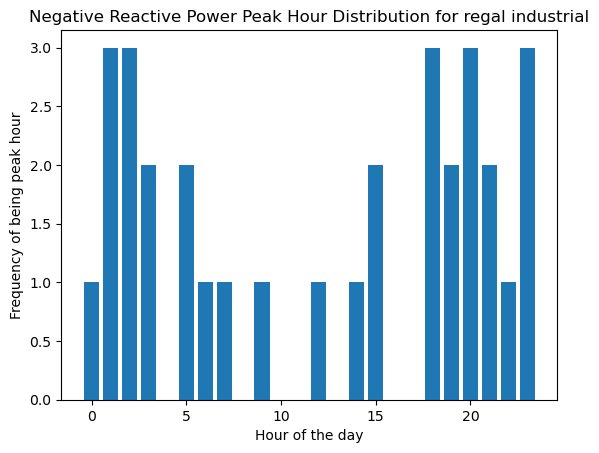

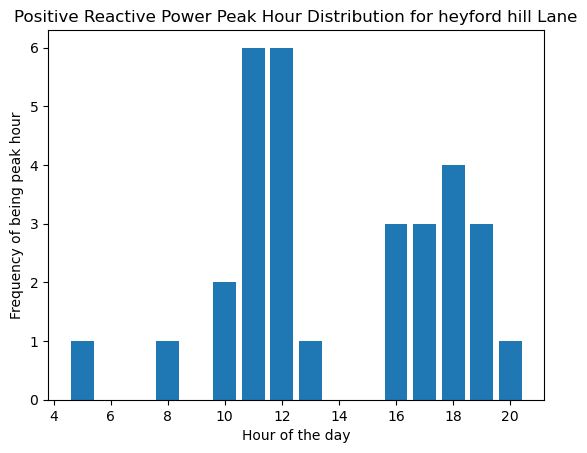

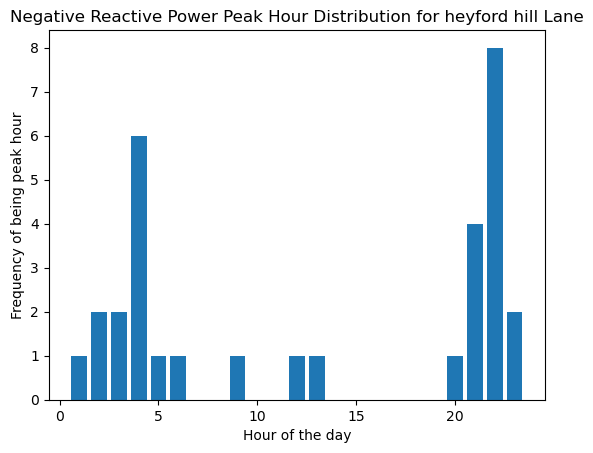

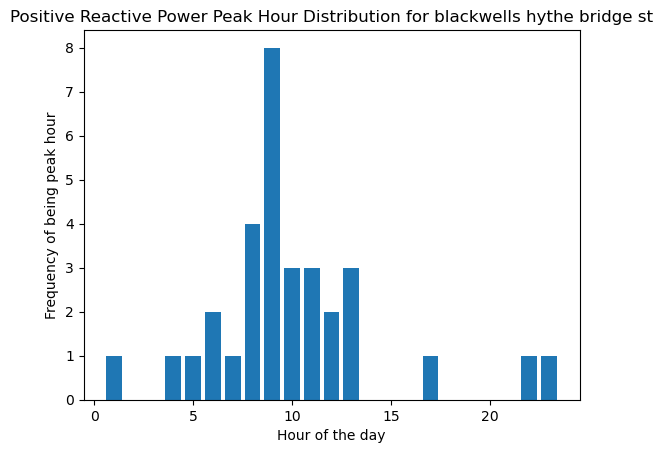

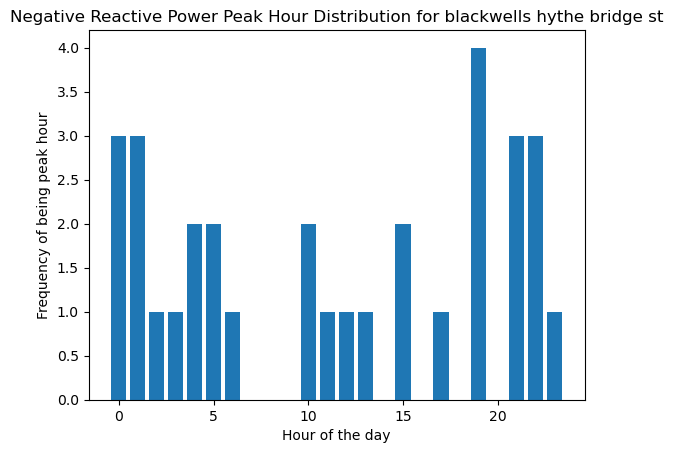

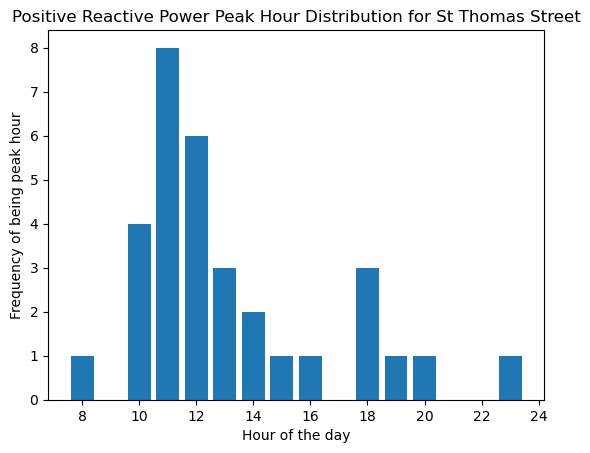

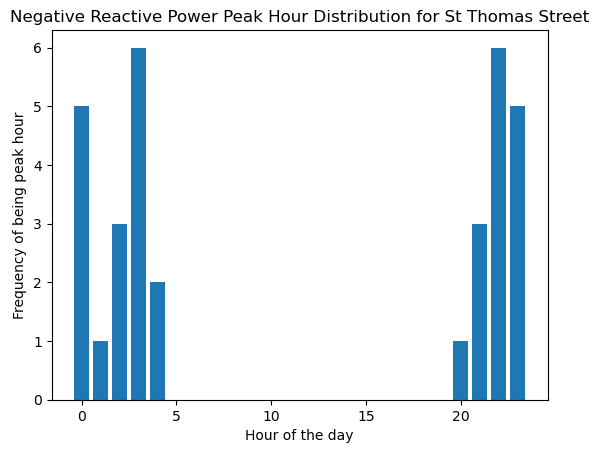

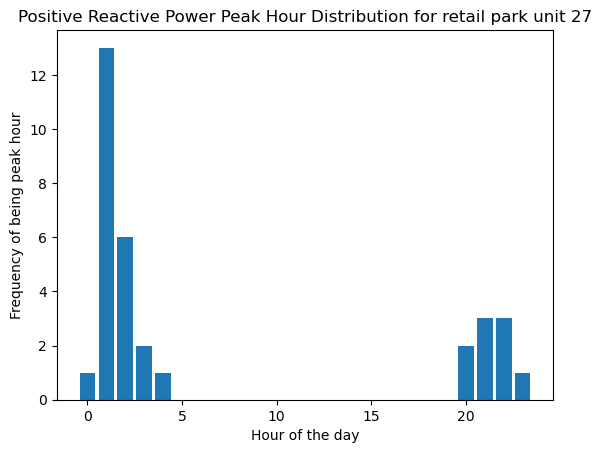

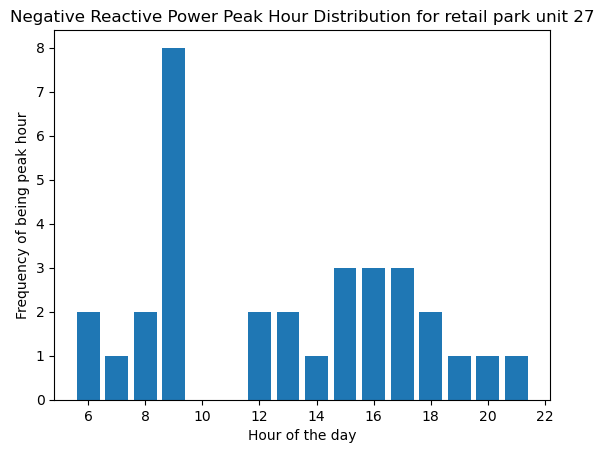

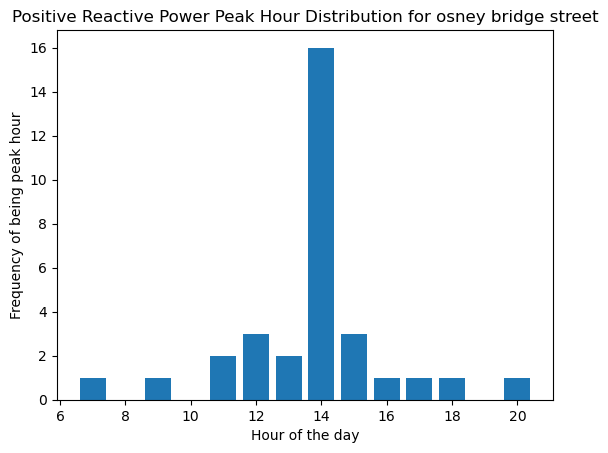

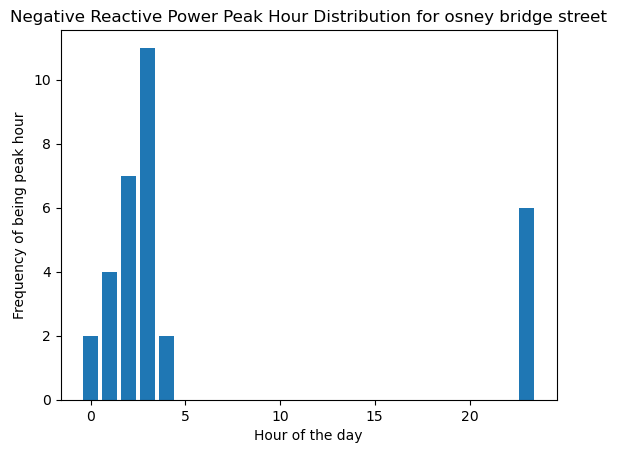

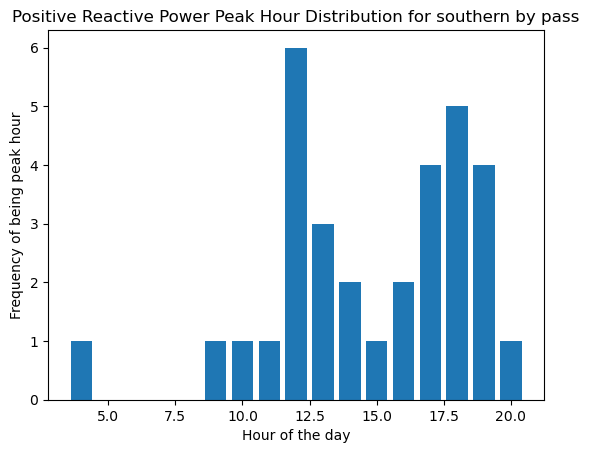

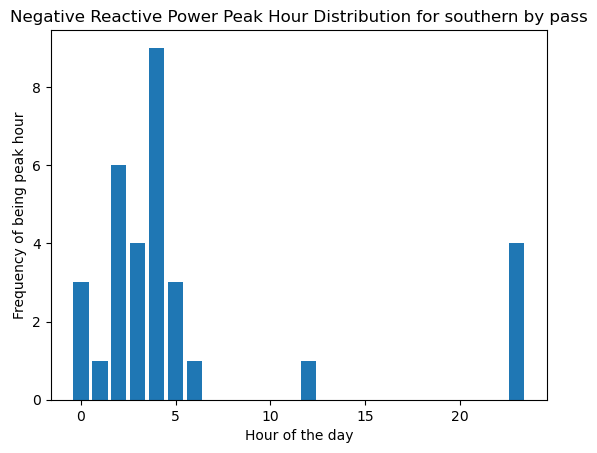

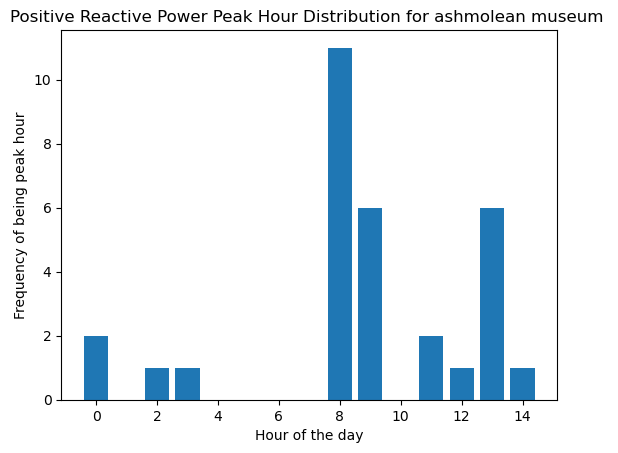

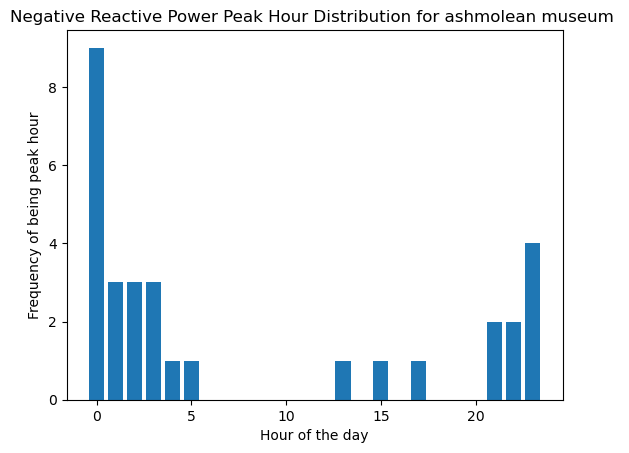

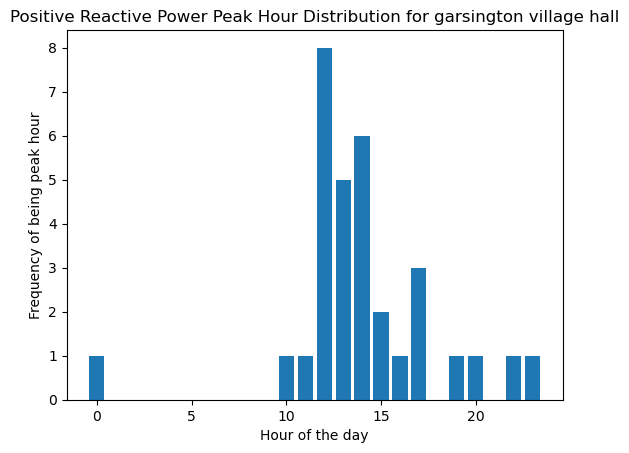

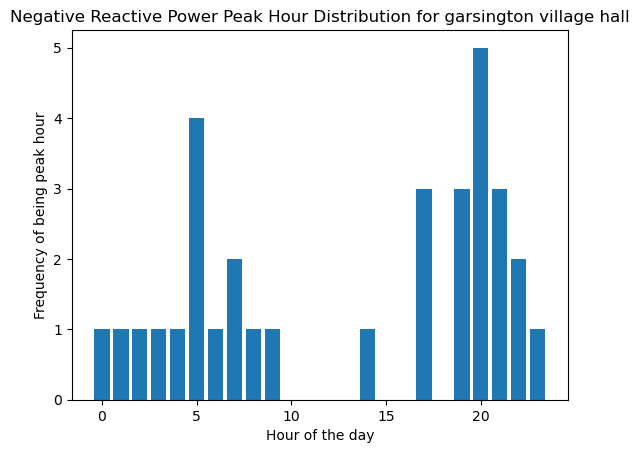

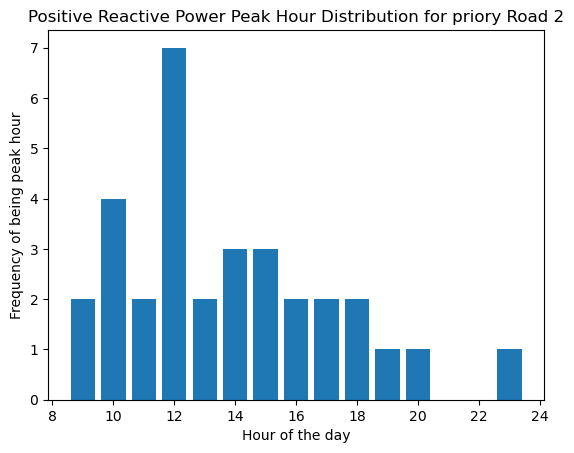

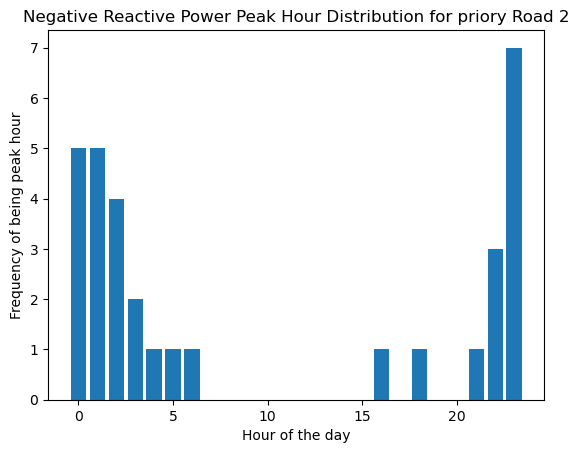

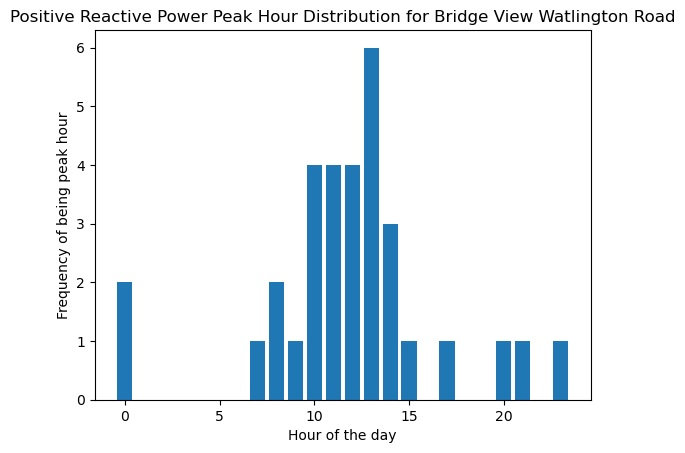

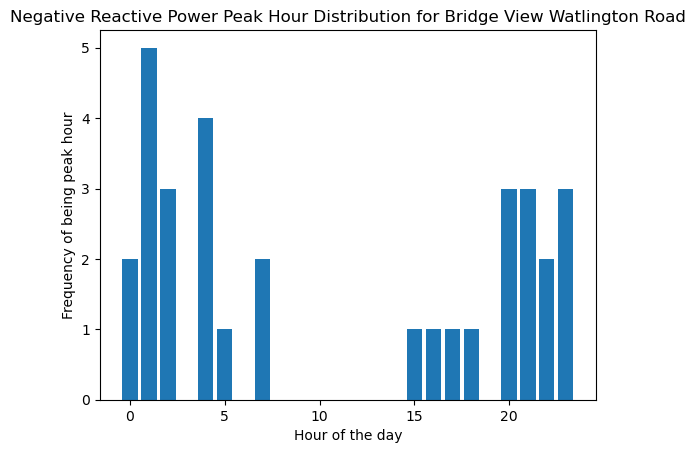

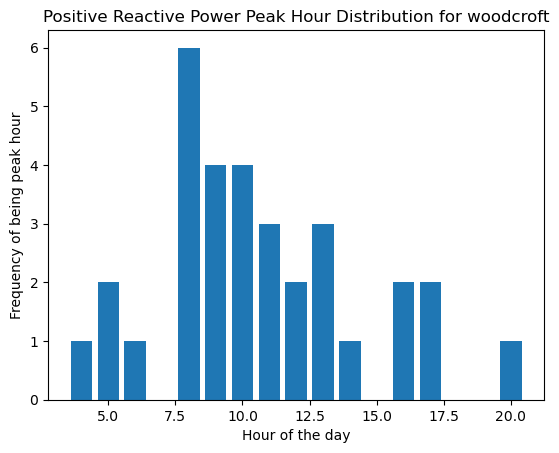

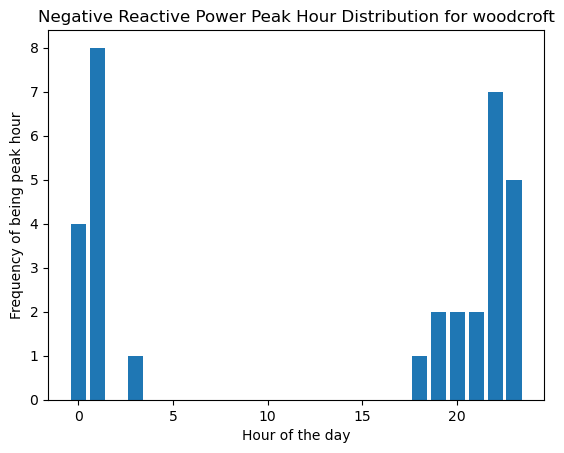

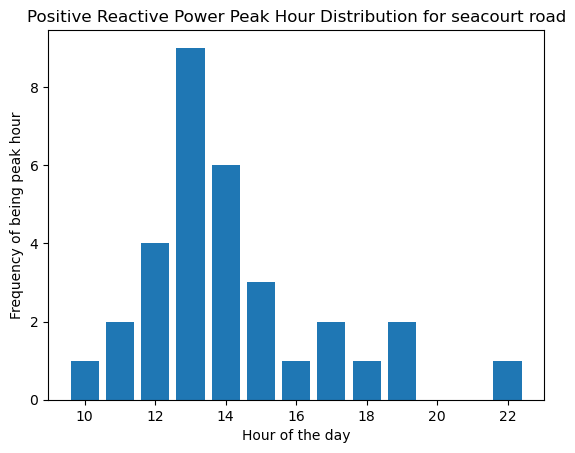

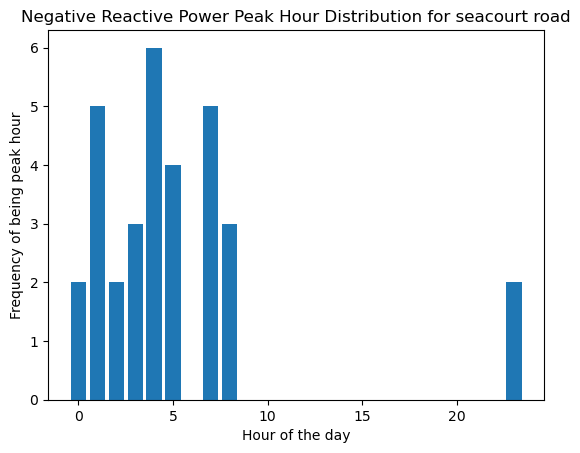

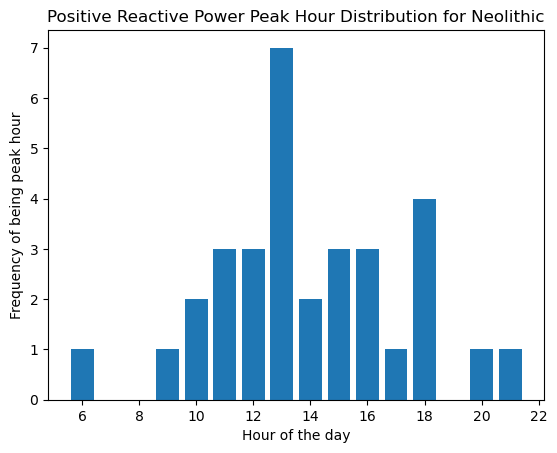

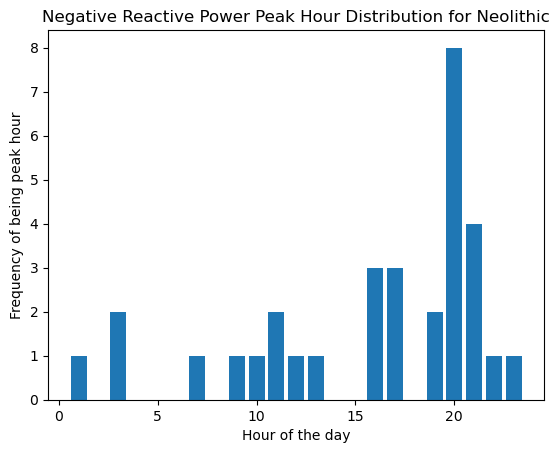

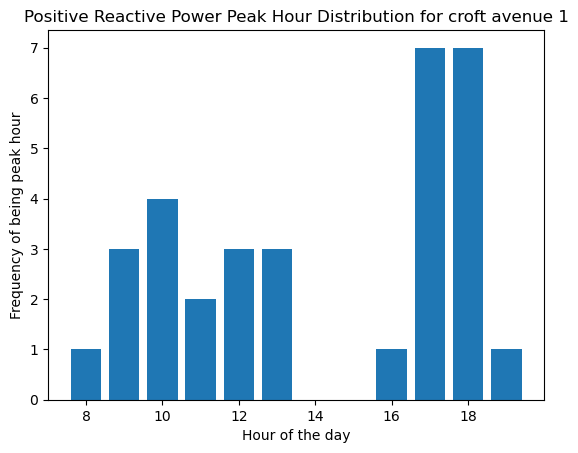

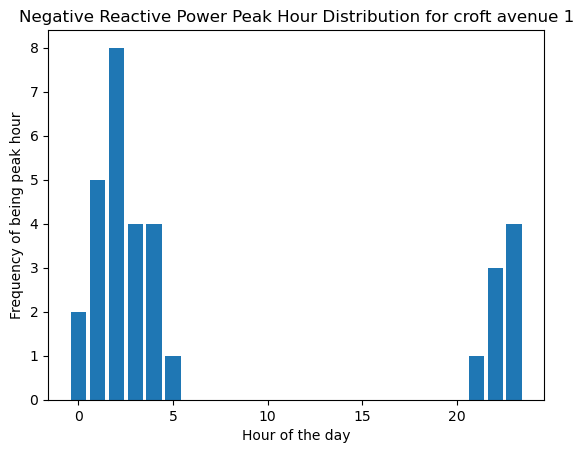

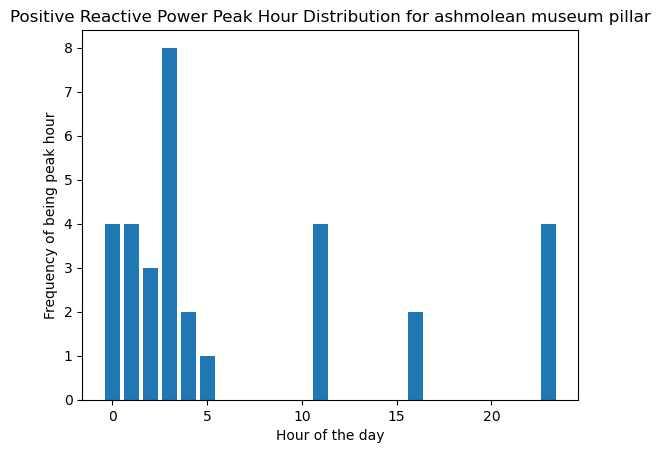

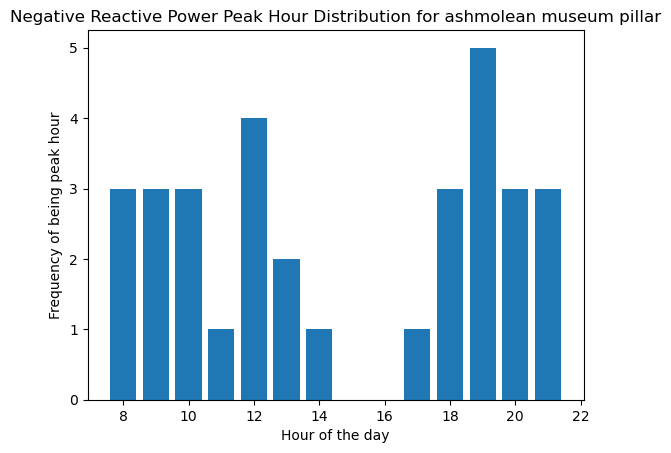

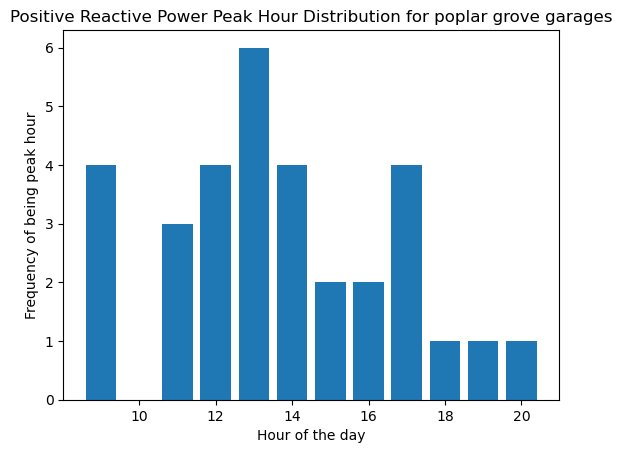

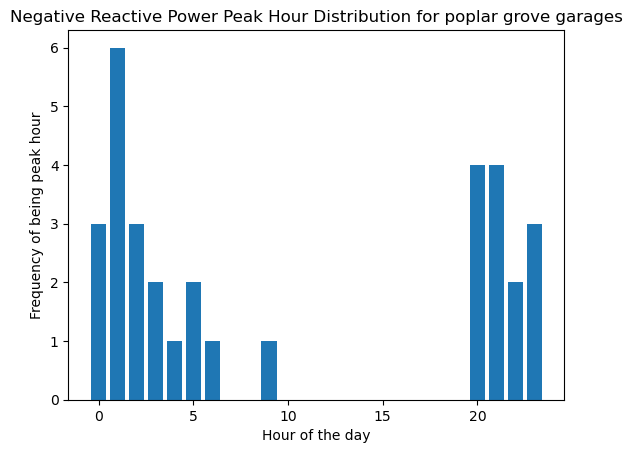

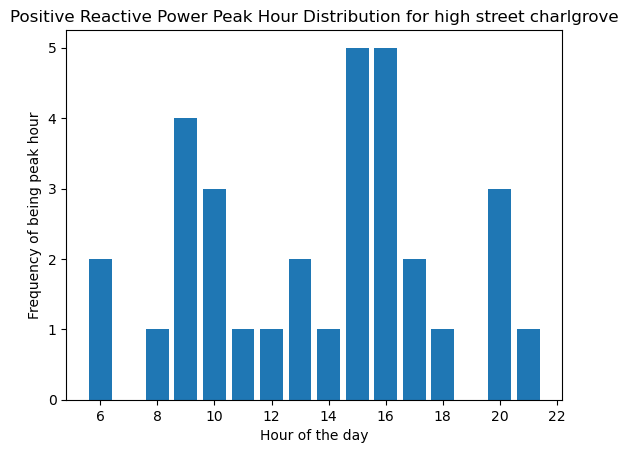

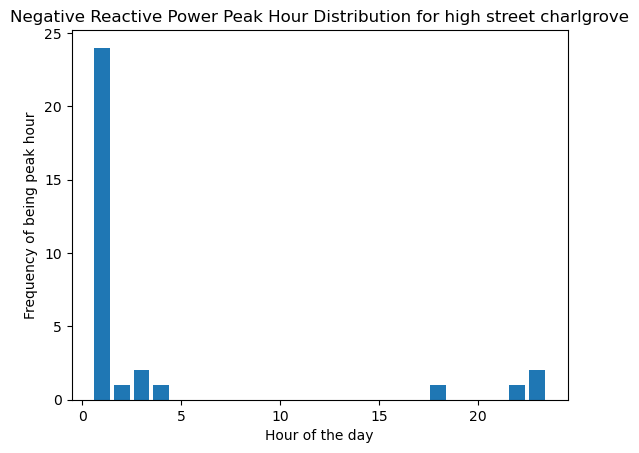

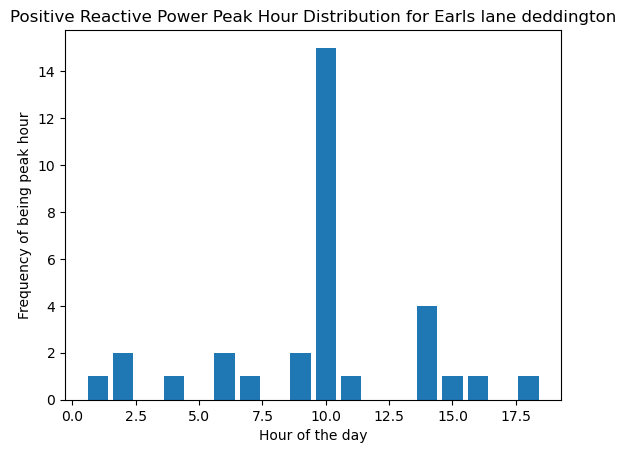

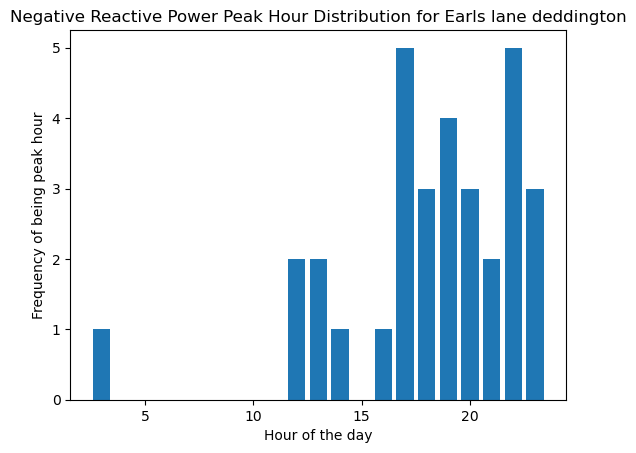

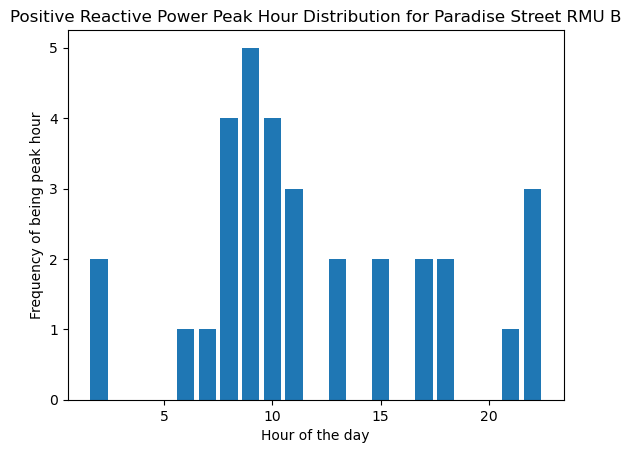

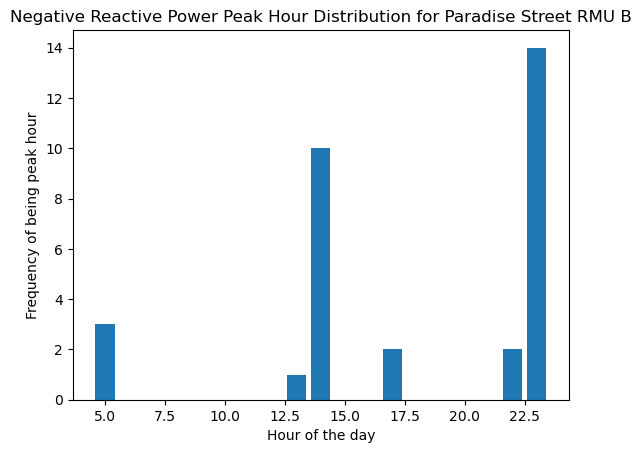

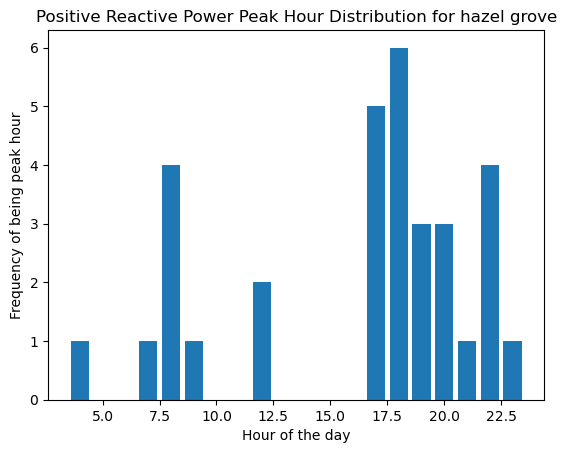

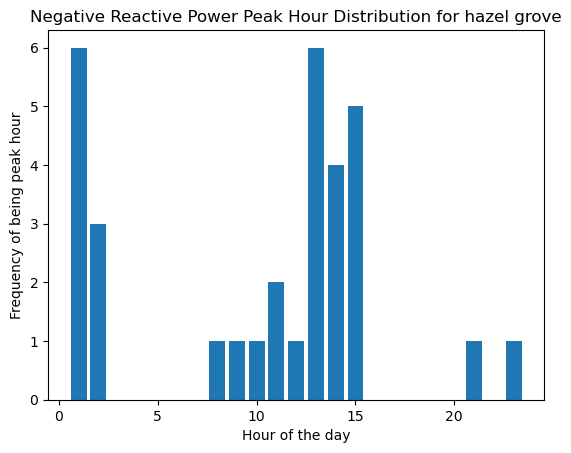

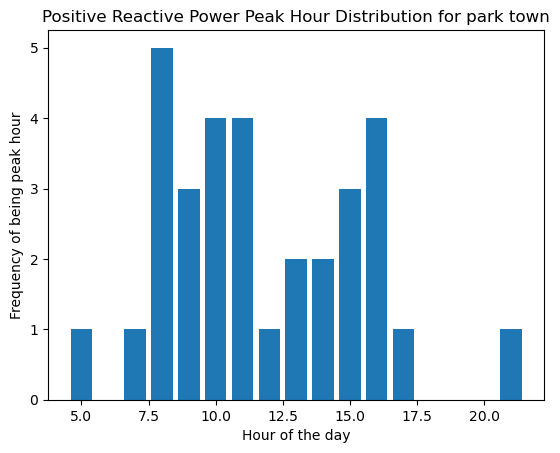

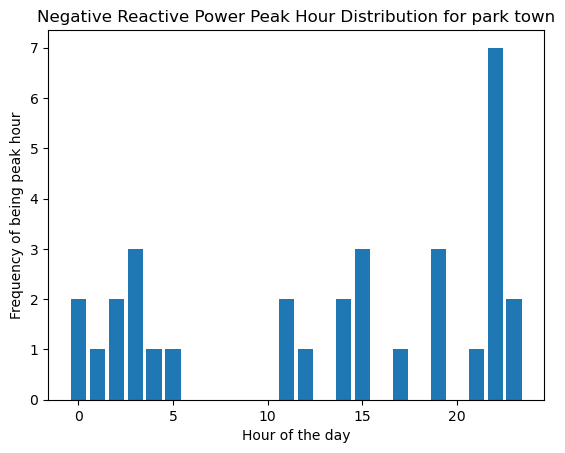

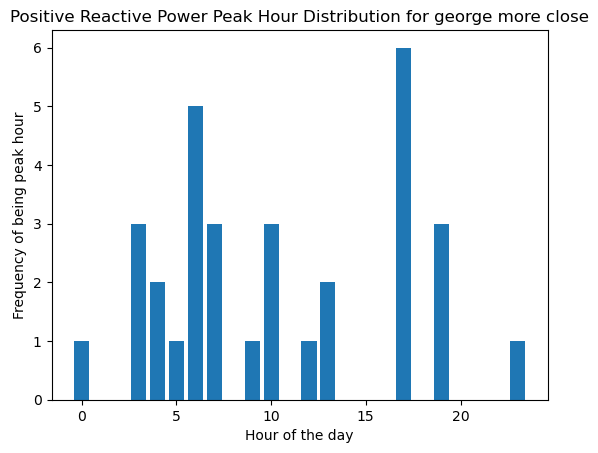

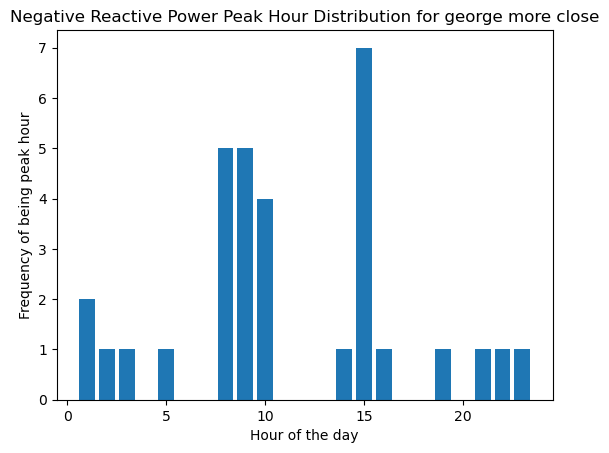

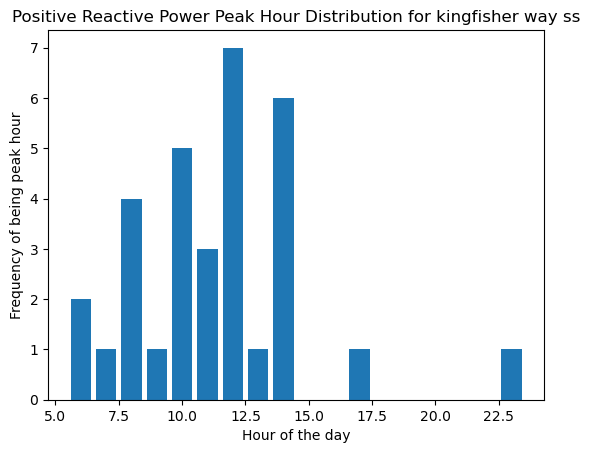

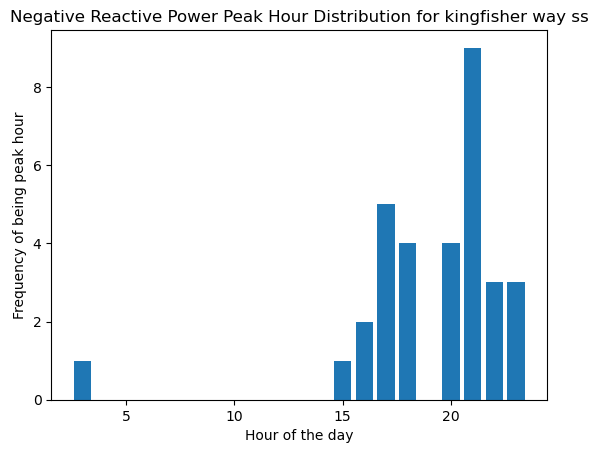

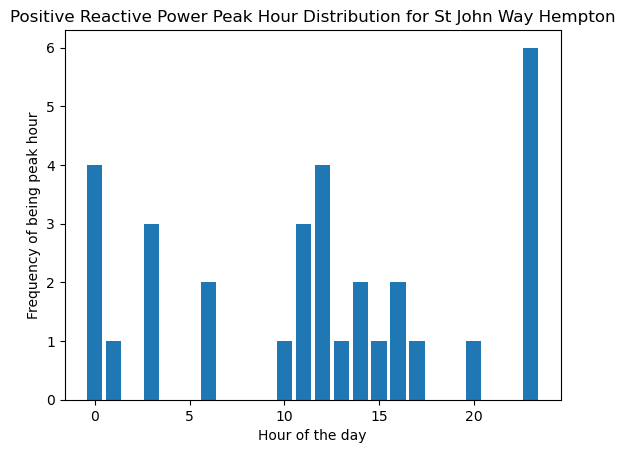

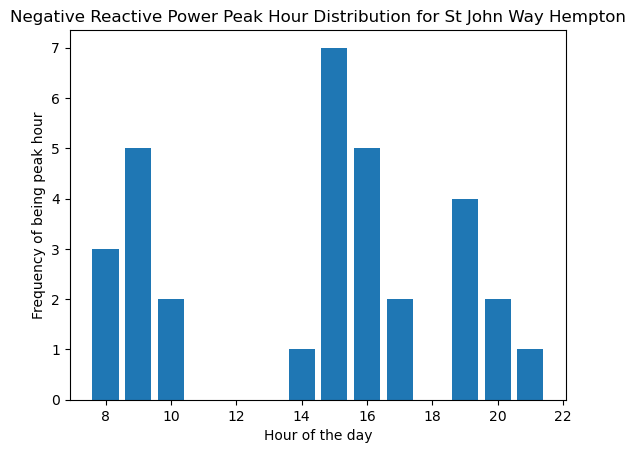

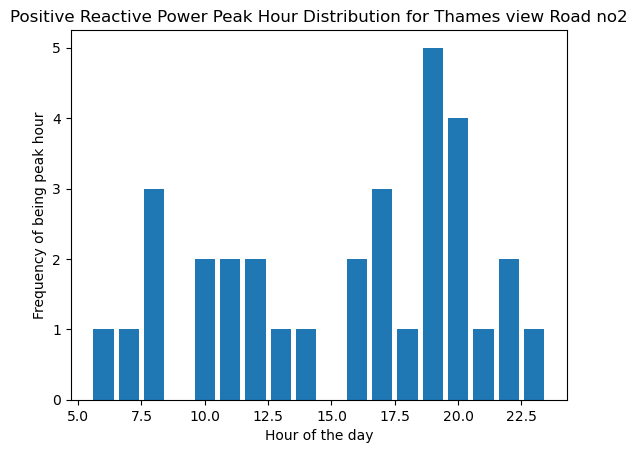

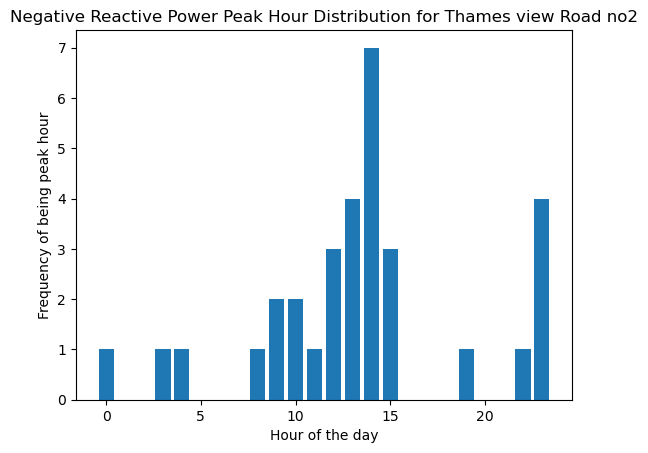

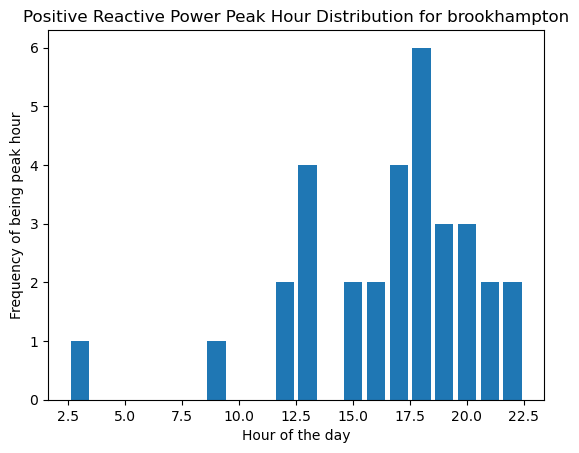

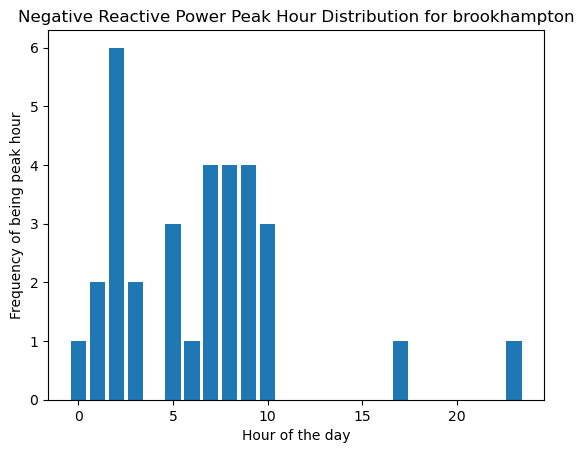

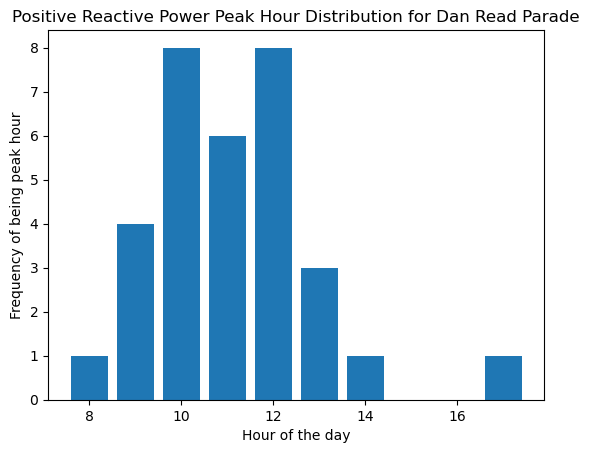

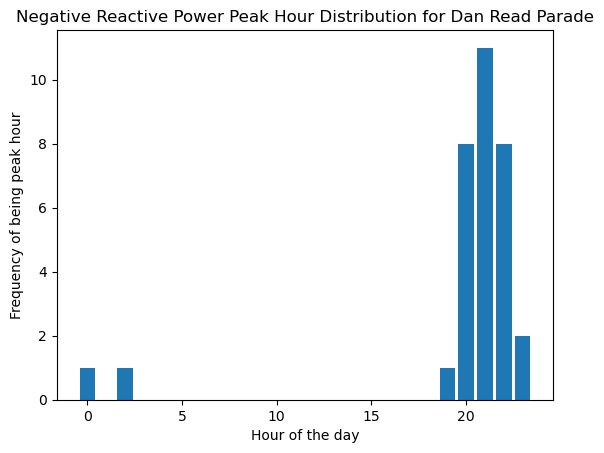

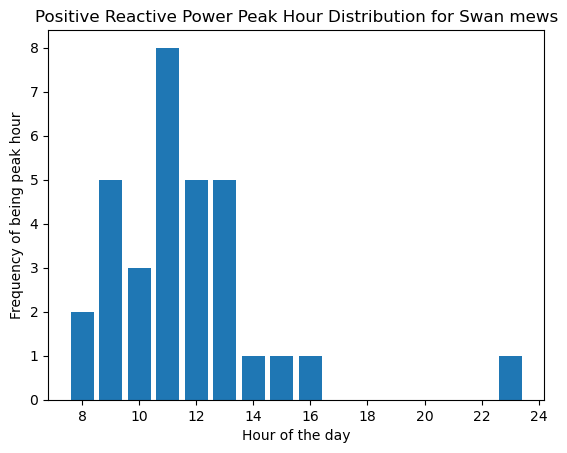

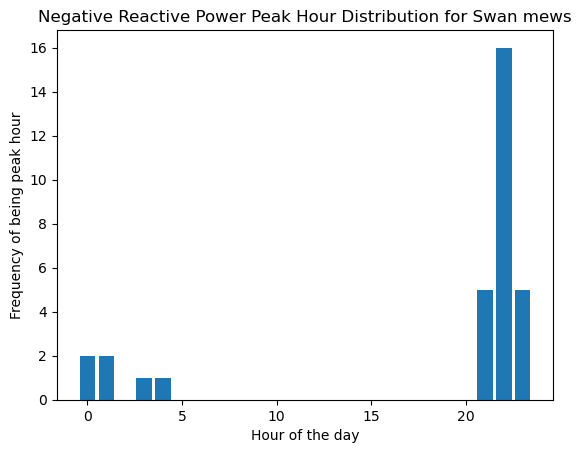

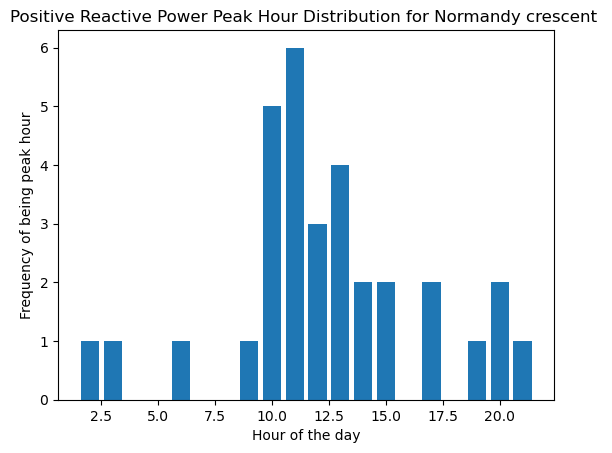

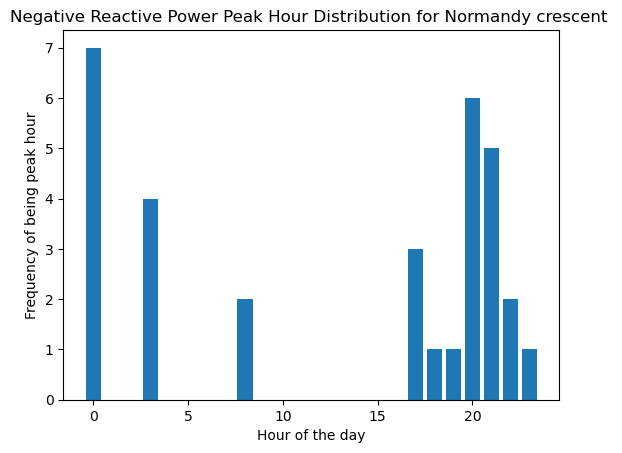

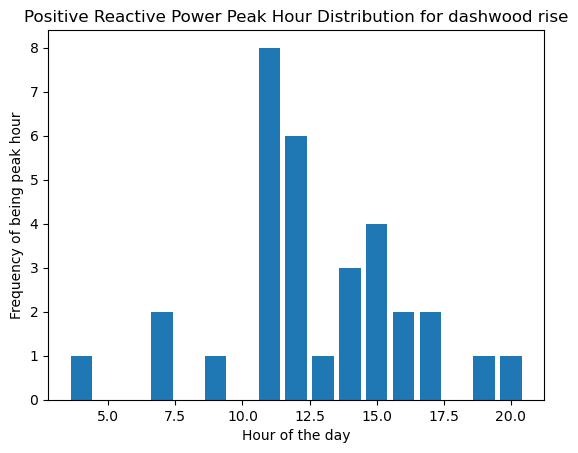

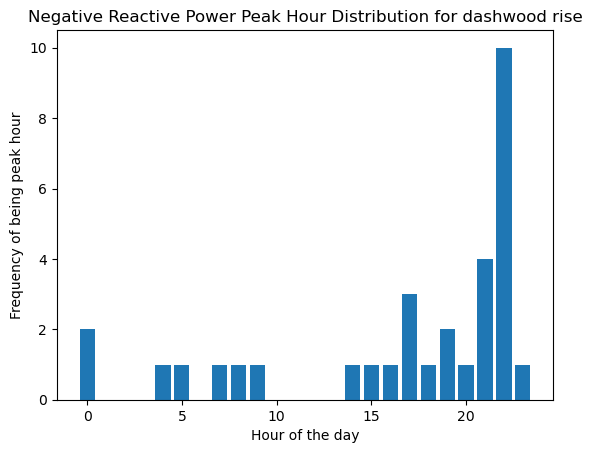

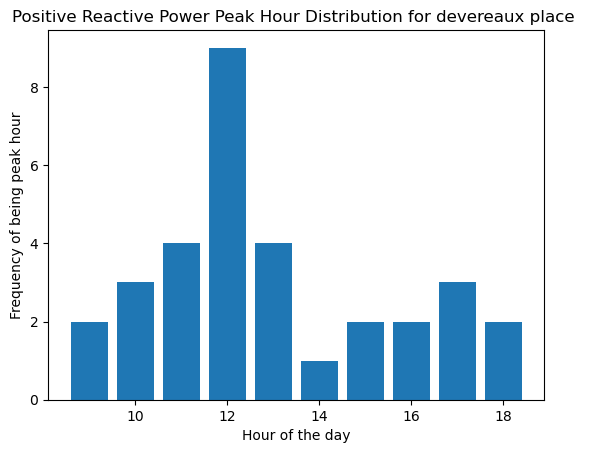

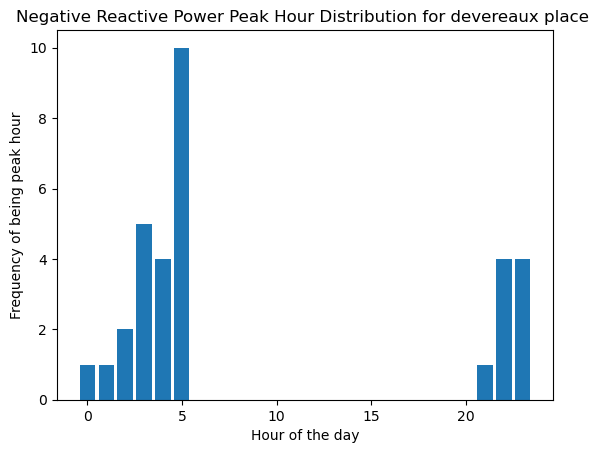

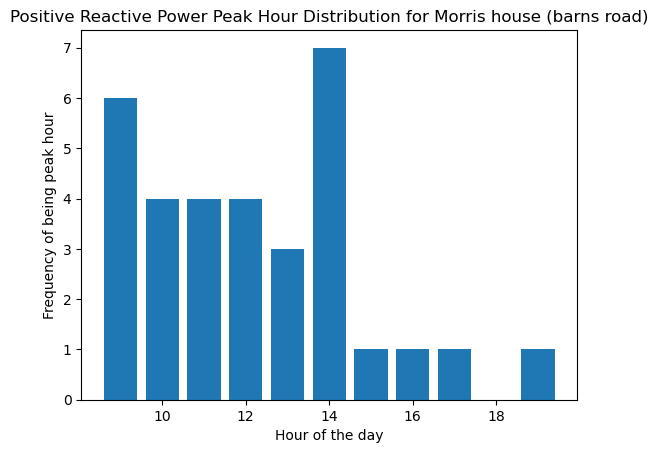

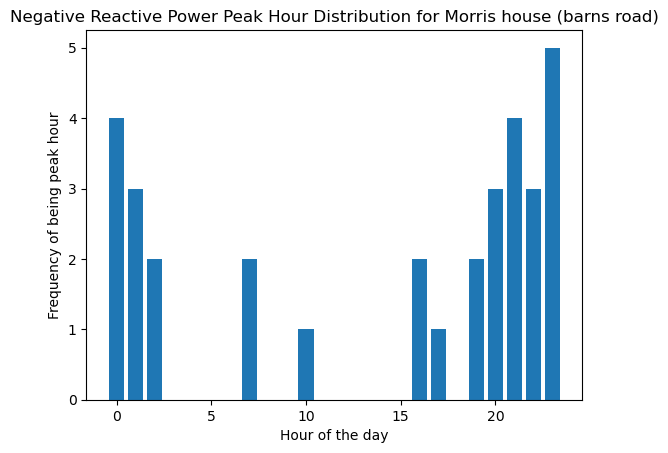

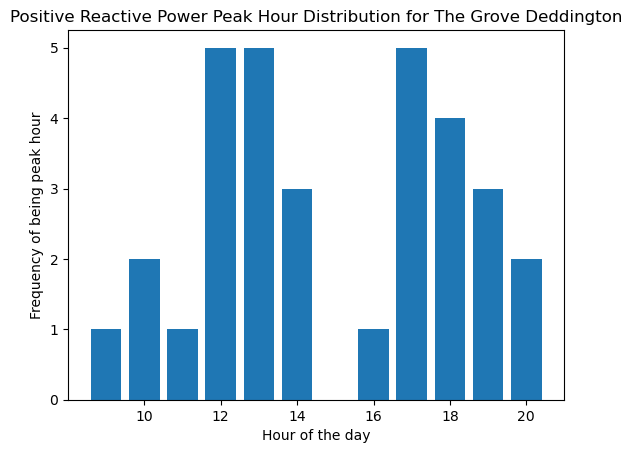

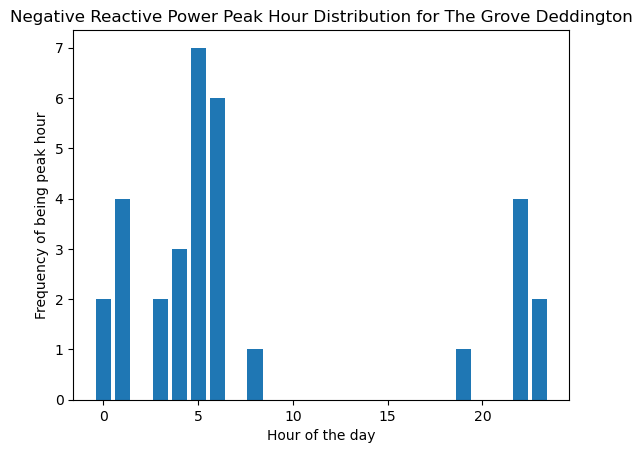

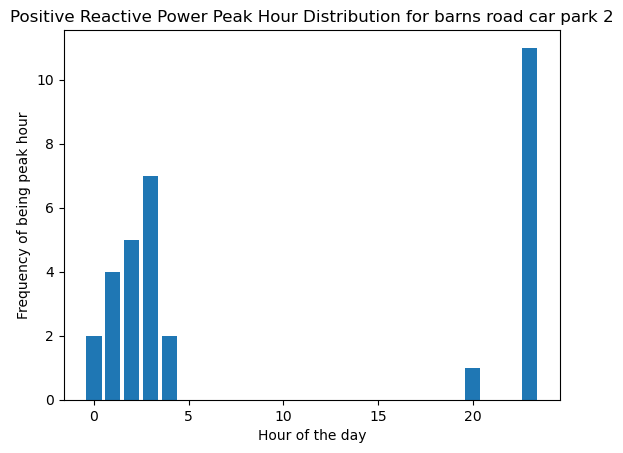

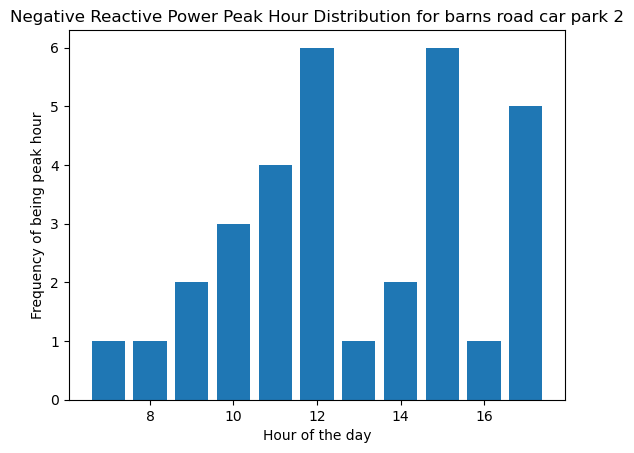

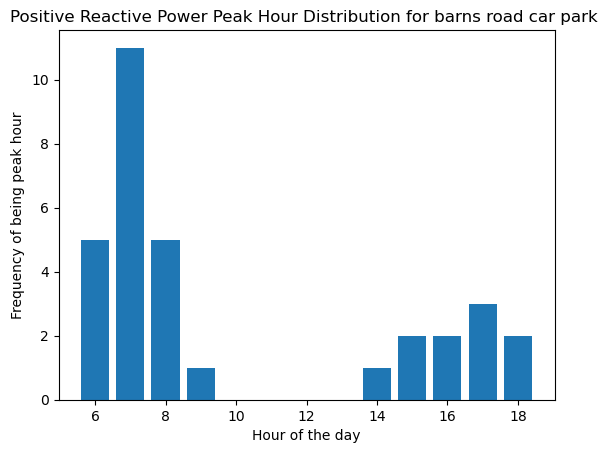

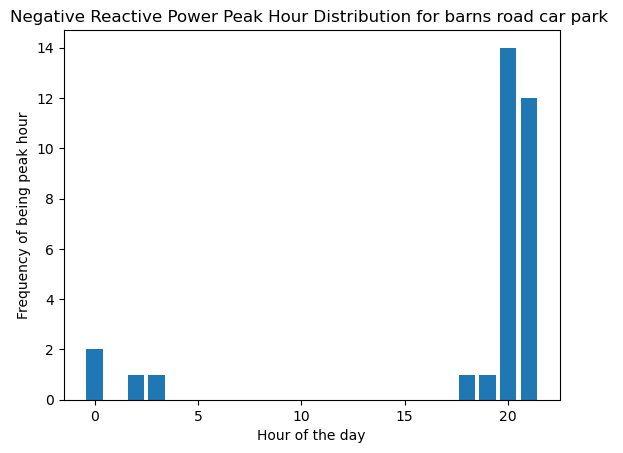

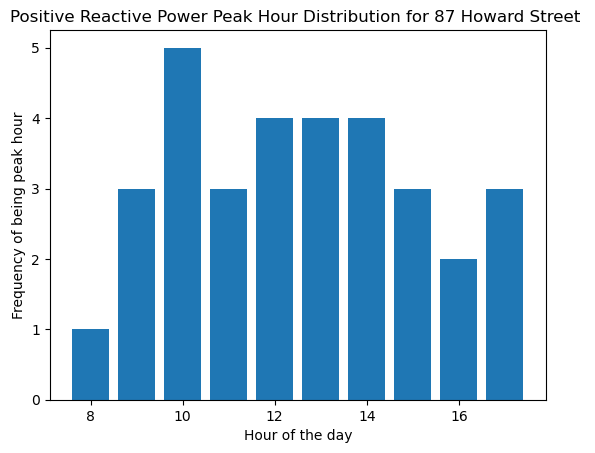

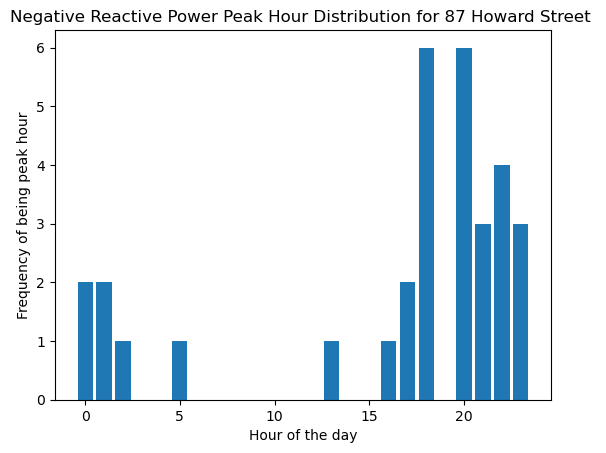

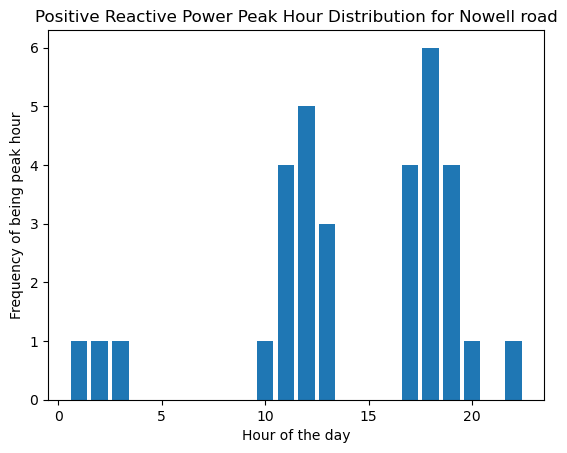

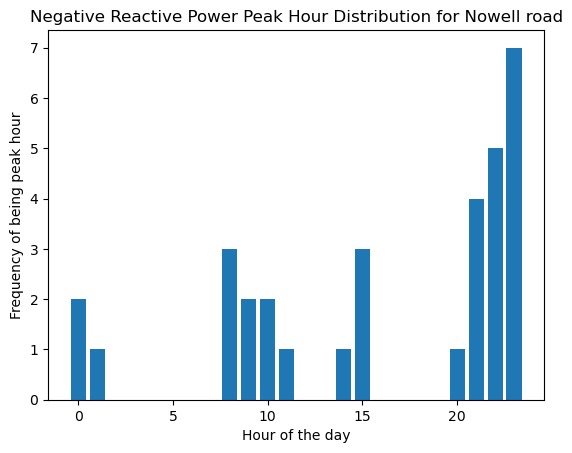

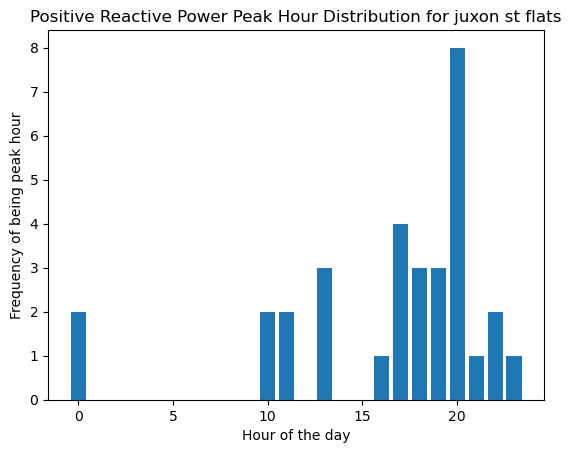

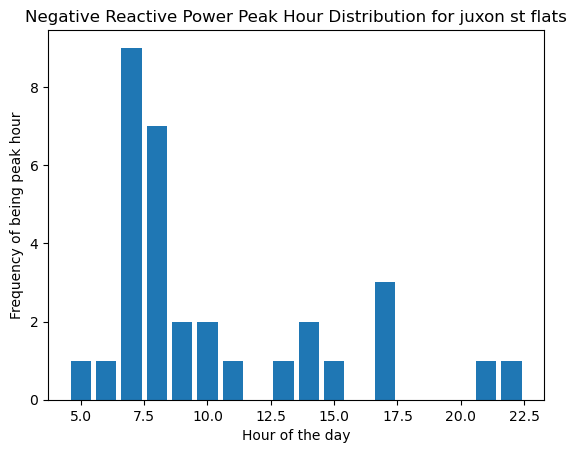

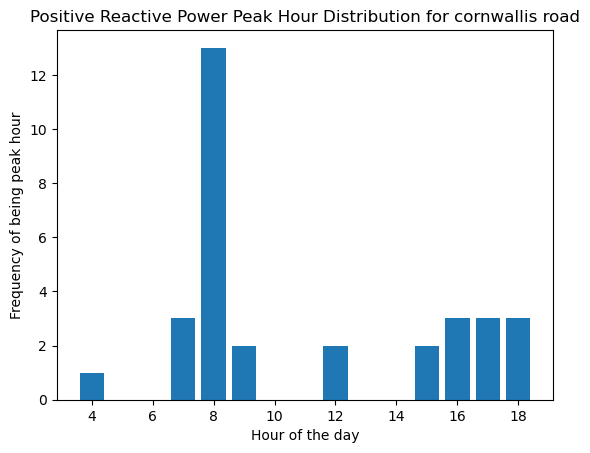

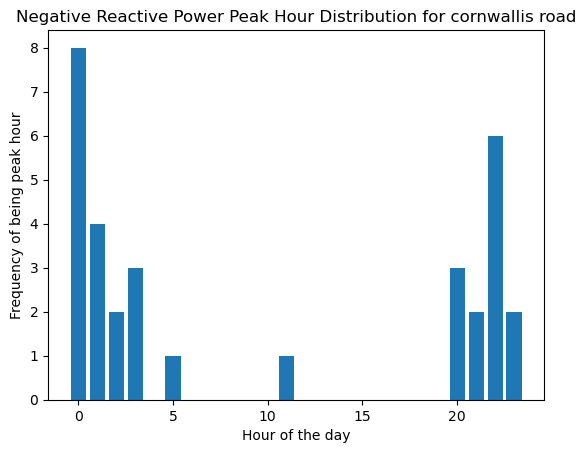

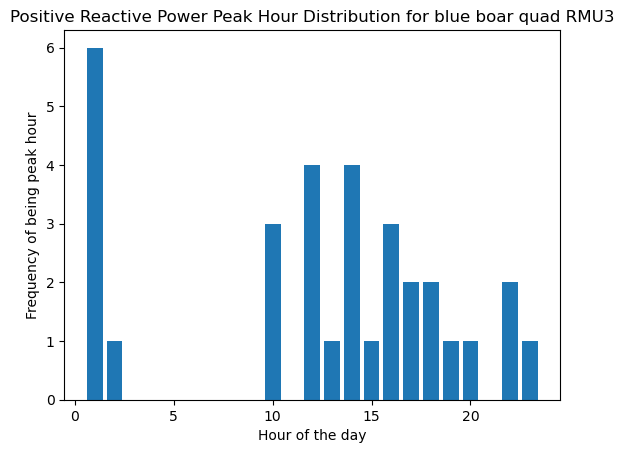

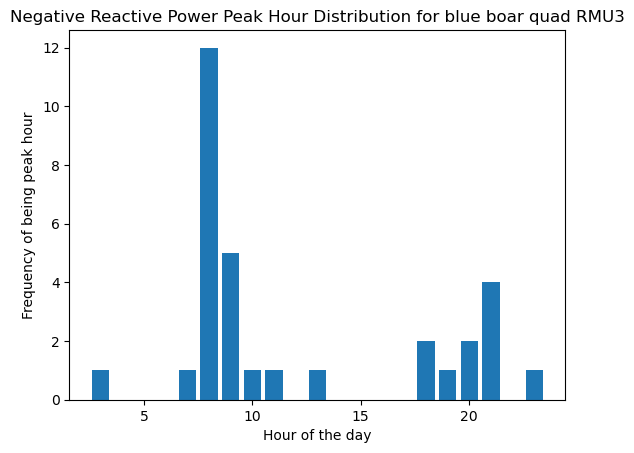

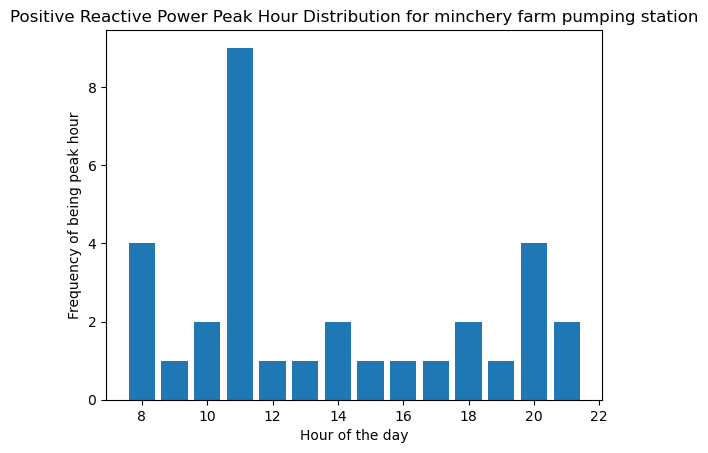

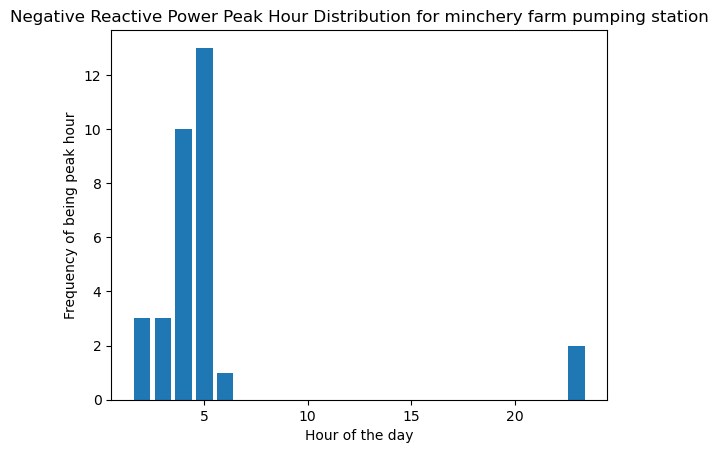

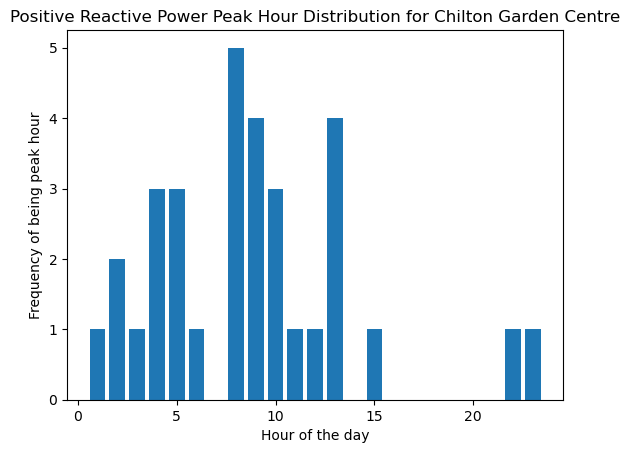

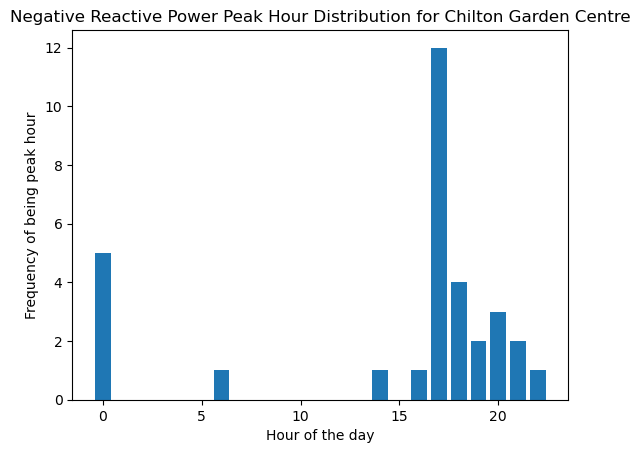

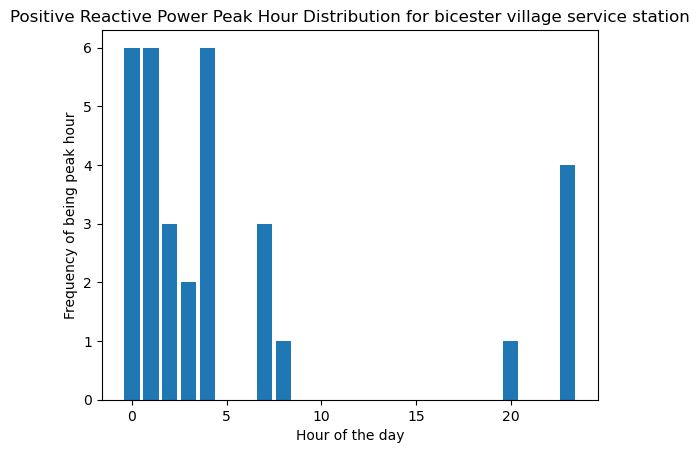

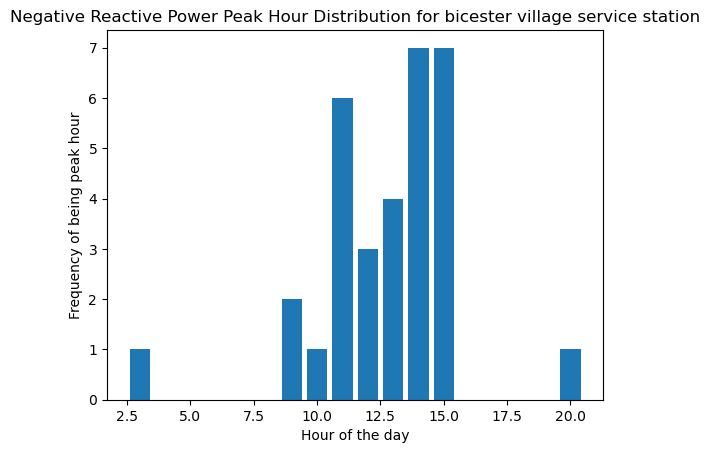

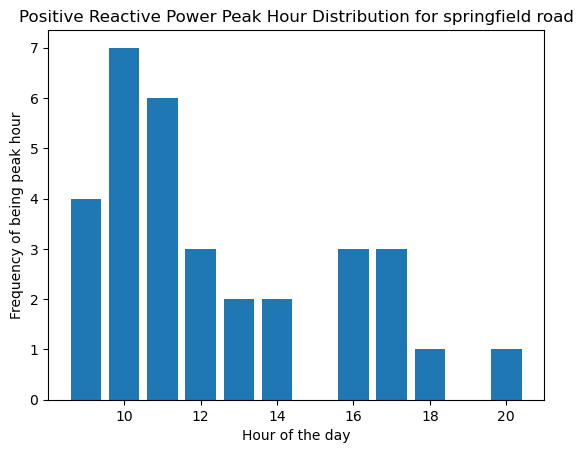

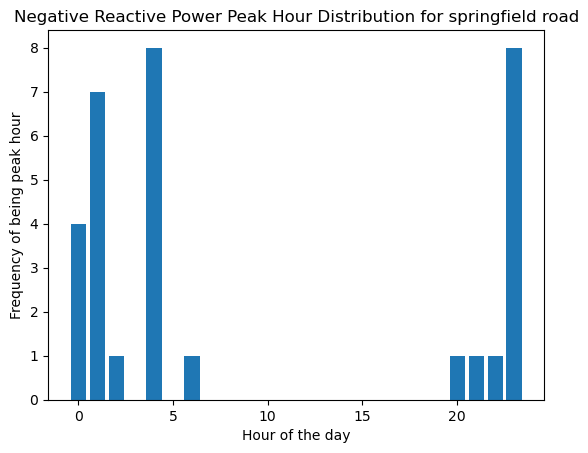

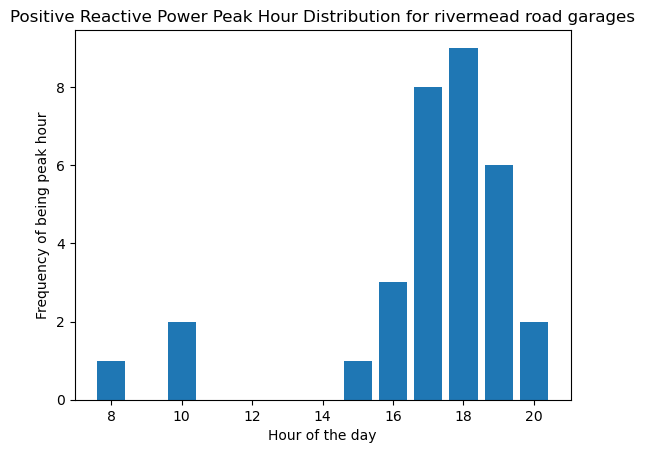

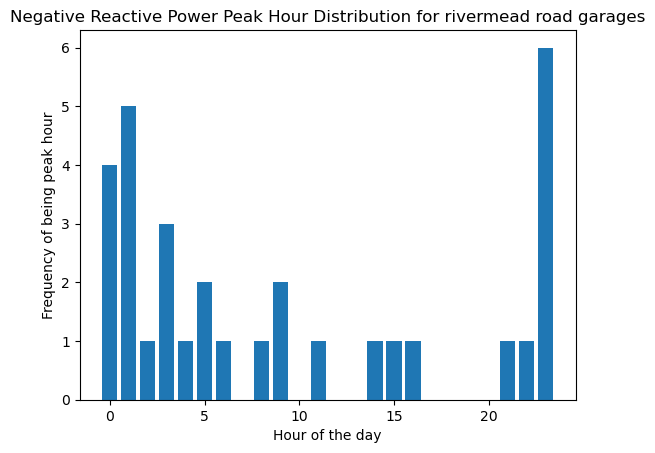

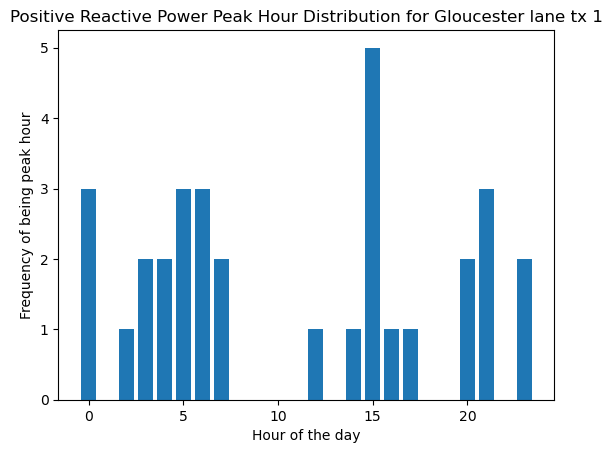

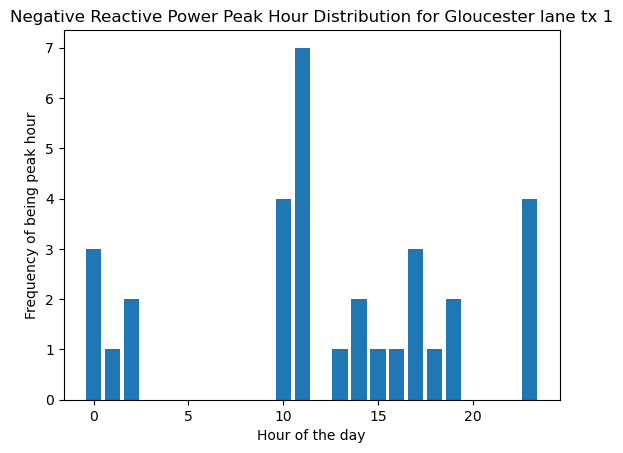

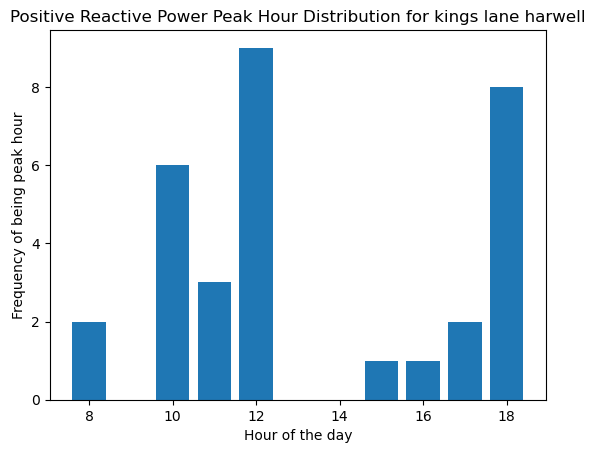

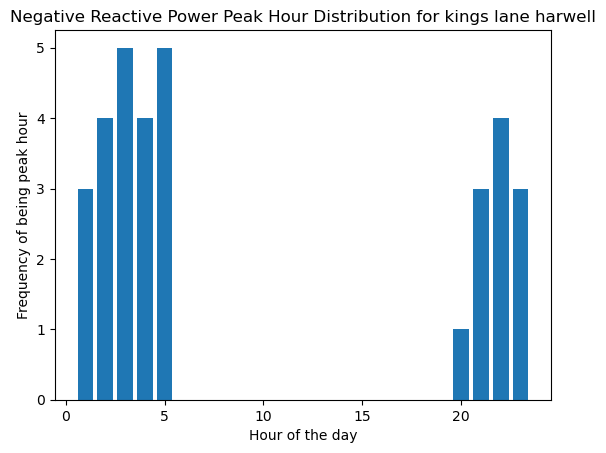

In [4]:
for substation, substation_data in dataframes.items():
    substation_data['Date'] = substation_data['Datetime'].dt.date
    substation_data['Hour'] = substation_data['Datetime'].dt.hour
    
    # Group the data by date
    daily_groups = substation_data.groupby(['Date'])

    # Find the hour of peak positive and negative Reactive power for each day
    peak_hour_max = daily_groups['Reactive Power [kVAr]'].idxmax().map(lambda x: substation_data.loc[x, 'Hour'])
    peak_hour_min = daily_groups['Reactive Power [kVAr]'].idxmin().map(lambda x: substation_data.loc[x, 'Hour'])
    
    # Count the number of times each hour appears as the peak hour for each day
    peak_counts_max = peak_hour_max.value_counts()
    peak_counts_min = peak_hour_min.value_counts()
    
    plt.bar(peak_counts_max.index, peak_counts_max.values)
    plt.xlabel('Hour of the day')
    plt.ylabel('Frequency of being peak hour')
    plt.title(f'Positive Reactive Power Peak Hour Distribution for {substation}')
    plt.show()
    plt.bar(peak_counts_min.index, peak_counts_min.values)
    plt.xlabel('Hour of the day')
    plt.ylabel('Frequency of being peak hour')
    plt.title(f'Negative Reactive Power Peak Hour Distribution for {substation}')
    plt.show()

# <font color ='orange'> 31/01/23 - Moving on to Yearly Substation Data </font>

### <font color='lightgreen'> Read Data </font>

Feeder level

In [335]:

# Define the folder path
folder_path = "Yearly Substation Data/"

# Create an empty dictionary to store the dataframes
dataframes = {}

# Iterate through all files in the folder
for file_name in os.listdir(folder_path):
    # Check if the file is a CSV file
    if file_name.endswith(".csv"):
        # Extract the substation name from the file name
        substation_name = file_name.split(" ")[2:]
        substation_name = substation_name[:substation_name.index("POWER")]
        substation_name = " ".join(substation_name)
        
        # Read the CSV file into a pandas dataframe
        df = pd.read_csv(os.path.join(folder_path, file_name))
        # Convert date column to datetime -- using this as opportunity to skip over empty dataframes (if you don't want this, add "errors = 'ignore'" to the to_datetime command)
        try:
            df['Datetime'] = pd.to_datetime(df['Date (Dublin. Edinburgh. Lisbon. London)']) 
        except:
            continue
        # Drop old date column 
        df.drop('Date (Dublin. Edinburgh. Lisbon. London)', axis=1, inplace=True)
        # Add the dataframe to the dictionary with the substation ID as the key
        dataframes[substation_name] = df

# Print the dataframe keys to check that the IDs processed appropriately
print(dataframes.keys())


dict_keys(['Gloucester lane tx 1', 'croft avenue 1', 'park town', 'Osney local', 'hopcraft lane', 'devereaux place ', 'george more close', 'dashwood rise', 'retail park unit 27', 'poplar grove garages', 'Earls lane deddington', 'Swan mews', 'Thames view Road no2', 'medawar centre ', 'Paradise Street RMU B', 'hazel grove', 'high street charlgrove', 'cornwallis road', 'queens lane telephone exchange', 'Bridge View Watlington Road', 'Thames View Road', 'Barry Avenue', 'henry road T2', 'Hillsborough Close', 'priory Road 2', 'barns road car park ', 'Danvers Road', 'henley avenue', 'osney mead pylon ', 'ashmolean museum ', 'southern by pass', 'Tappins Coaches', 'Mill St flats', 'woodcroft', 'rivermead road garages', 'kingfisher way ss', 'edinburgh drive pillar 2', 'sutton courtenay road', 'Desborough crescent', 'hempton road gm', 'henry road T1', 'barns road car park 2', 'campbell road', 'windmill st deddington', 'regal industrial', 'priory rd 1', 'Hockmore Street', 'Fiennes Road', 'juxon st

Busbar level

## Data Cleaning (last updated 14/02/23)

### <font color='lightgreen'> Handle Missing Values </font>

In [304]:
############################################################
######Check for dataframes with missing values
############################################################
empty_substations = []
for substation, df in dataframes.items():
    if df.isna().sum().sum() > 0:
        empty_substations.append(substation)

if not empty_substations:
    print("No missing values")


# ############################################################
# ###### Drop substations with no active power data ###### ######  TODO: Get rid of this, it's covered by the below
# ############################################################ 
# empty_substations = []
# for substation, df in dataframes.items():
#     if abs(df['Active Power [kW]']).sum() == 0 or abs(df['Reactive Power [kVAr]']).sum() == 0:
#         empty_substations.append(substation)
        
# # Drop substations without any active power data (Heny Road T2 and Edinburgh Drive 1)
# for substation in empty_substations:
#     print(f"Substation {substation} has no active power data. Dropping from dataframe.")
#     del dataframes[substation]
    


########################################################################
### Drop substations with less than 50% available active power data ####
########################################################################
threshold = 0.50 # 50% threshold
substations_below_threshold = []
for substation, df in dataframes.items():
    count_zero = (df['Active Power [kW]'] == 0).sum()
    if count_zero > (len(df) * threshold):
        substations_below_threshold.append(substation)
        
for substation in substations_below_threshold:
    print(f"Substation {substation} has less than 50% available active power data. Dropping from dataframe.")
    del dataframes[substation]


# No missing values
# Substation Thames view Road no2 has less than 50% available active power data. Dropping from dataframe.
# Substation henry road T2 has less than 50% available active power data. Dropping from dataframe.
# Substation the perch binsey has less than 50% available active power data. Dropping from dataframe.
# Substation edinburgh drive 1 has less than 50% available active power data. Dropping from dataframe.
    
        

No missing values
Substation Thames view Road no2 has less than 50% available active power data. Dropping from dataframe.
Substation henry road T2 has less than 50% available active power data. Dropping from dataframe.
Substation the perch binsey has less than 50% available active power data. Dropping from dataframe.
Substation edinburgh drive 1 has less than 50% available active power data. Dropping from dataframe.


For all substations, drop days with any missing data
Missing data is defined as observations where active power is 0</BR>
DON'T RUN - NOT NEEDED ANYMORE

In [104]:
# '''
# This function takes in a dict of substation dataframes, and for each substation drops all days of data where 0 active power is observed. 
# The assumption is that 0 active power should never happen so this is a good way to remove days where the data is missing.
# '''
# def remove_days_with_missing_data(dataframes):
#     for substation, df in dataframes.items():
#         # Get the dates of days with 0 active power
#         df['Date'] = df['Datetime'].dt.date
#         zero_dates = df[df['Active Power [kW]'] == 0]['Date'].unique()
#         # Drop those dates from the dataframe
#         dataframes[substation] = df[~df['Date'].isin(zero_dates)]  
        
#     return dataframes
        
# dataframes = remove_days_with_missing_data(dataframes)



### <font color='lightgreen'> Data transformation: by season and time of week </font> 
### <font color='lightblue'> NB: Output from this block used in next chonk!! "chopped_substation_dfs" dict </font> 

Split by season

In [348]:
def split_by_season(df):
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df['Month'] = df['Datetime'].dt.month
    
    spring = df[(df['Month'] >= 3) & (df['Month'] <= 5)]
    summer = df[(df['Month'] >= 6) & (df['Month'] <= 8)]
    fall = df[(df['Month'] >= 9) & (df['Month'] <= 11)]
    winter = df[(df['Month'] == 12) | ((df['Month'] >= 1) & (df['Month'] <= 2))]
    
    return spring, summer, fall, winter

substation_dataframes = {}
for substation, df in dataframes.items():
    spring, summer, fall, winter = split_by_season(df)
    substation_dataframes[substation] = {'spring': spring, 'summer': summer, 'fall': fall, 'winter': winter}



Split the season dataframes by time of week

In [349]:
# Split seasonal dataframes into week and week-end dataframes
def split_weekend_week(df):
    df['weekday'] = df['Datetime'].dt.weekday
    week_df = df[df['weekday'].isin([0,1,2,3,4])]
    weekend_df = df[df['weekday'].isin([5,6])]
    return week_df, weekend_df

chopped_substation_dfs = {}
for substation, season_dict in substation_dataframes.items():
    chopped_substation_dfs[substation] = {}
    for season, df in season_dict.items():
        week_df, weekend_df = split_weekend_week(df)
        chopped_substation_dfs[substation][season] = {}
        chopped_substation_dfs[substation][season]['week'] = week_df
        chopped_substation_dfs[substation][season]['weekend'] = weekend_df
        

/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_18535/4011766680.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weekday'] = df['Datetime'].dt.weekday
/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_18535/4011766680.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weekday'] = df['Datetime'].dt.weekday
/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_18535/4011766680.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

# <font color='orange'> Next to do (read this chunk) </font>
Split the datafrmaes

In [328]:
spring = substation_dataframes_szn_weekend_week['spring']
summer = substation_dataframes_szn_weekend_week['summer']
fall = substation_dataframes_szn_weekend_week['fall']
winter =  substation_dataframes_szn_weekend_week['winter']


### <font color = 'lightgreen'> Post-transformation: Check size of datasets, filter out ones that are too short </font>

In [ ]:
def get_substation_df_lengths(dataframes):
    dflengths = []
    names = []
    for substation, df in dataframes.items():
        names.append(substation)
        dflengths.append(len(df))
    return pd.DataFrame(list(zip(names, dflengths)), columns = ['Substation', 'Length'])



Plan: 
Split the main dataframe up into season, week, week-end, so that I have 8 dataframes total

### <font color='yellow'> Detect Outliers </font> (check with elnaz if needs to be done at this stage?)

Plot histograms??

In [206]:
plot_peak_hour_distributions(dataframes, active = True)

NameError: name 'plot_peak_hour_distributions' is not defined

### <font color ='yellow'> Extract Features for Clustering </font>

Global features  </br>

Mean value of daily load pattern </br>
SD of daily load pattern </br>
Max power consumption during a day  </br>
Min power consumption during a day  </br>
Range power consumption during a day (max - min) </br>
Perc values above mean val  </br>
Sum of net loads during business hours (9am-6pm) </br>
Sum of net loads during non-business hours </br>
Skewness of the distribution of a daily load pattern  </br>
Kurtosis of distribution of a daily load pattern  </br>
Mode of 5-bin histogram for daily load pattern   </br>
Longest sub-sequence where consecutive value above mean value  </br>
Longest period of successive increase  </br>

Global features for daily load pattern collected 2 ways... 

1. Get as statistical features for the distribution of total daily loads across the year </br>


In [326]:
'''
This function (v1) extracts the global features for a distribution of total daily loads within the measured dataset for each substation
'''

def extract_global_features(df):
    # convert datetime column to datetime type
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    
    df['Date'] = df['Datetime'].dt.date
    df['Hour'] = df['Datetime'].dt.hour
    
    # set datetime column as index
    df = df.set_index('Datetime')
    
    # group data by day to get daily load pattern (total energy consumed in a day)
    daily_loads = df.resample('D').sum()
    
    # Mean daily power consumption 
    mean_daily_load_pattern = daily_loads['Active Power [kW]'].mean()
    
    # Std deviation of daily power consumption
    sd_daily_load_pattern = daily_loads['Active Power [kW]'].std()
    
    # Max power consumption during a day
    max_power_consumption = daily_loads['Active Power [kW]'].max()
    
    # Min power consumption during a day
    min_power_consumption = daily_loads['Active Power [kW]'].min()
    
    # Range of power consumption during a day
    range_power_consumption = max_power_consumption - min_power_consumption

    # Maximum within-day power consumption range 
    (daily_groups['Active Power [kW]'].max() - daily_groups['Active Power [kW]'].min()).max()
    
    # Percent values above mean value
    percent_values_above_mean = (daily_loads > mean_daily_load_pattern).mean() * 100
    
    # Sum of net loads during business hours (9am-6pm)
    business_hours = (df.index.hour >= 9) & (df.index.hour < 18)
    sum_net_loads_business_hours = df[business_hours].sum()
    
    # Sum of net loads during non-business hours
    non_business_hours = ~business_hours
    sum_net_loads_non_business_hours = df[non_business_hours].sum()
    
    # kewness of the distribution of a daily load pattern
    skewness_daily_load_pattern = daily_loads.skew()
    
    # kurtosis of distribution of a daily load pattern
    kurtosis_daily_load_pattern = daily_loads.kurtosis()
    
    # mode of 5-bin histogram for daily load pattern
    hist, bin_edges = np.histogram(daily_loads, bins=5)
    mode_5_bin_histogram = bin_edges[np.argmax(hist)]
    
    # longest sub-sequence where consecutive value above mean value
    # above_mean = daily_load_pattern > mean_daily_load_pattern
    # longest_subseq_above_mean = above_mean.astype(int).diff().ne(0).cumsum()
    # group = longest_subseq_above_mean.groupby(longest_subseq_above_mean).cumcount()
    # longest_subseq_above_mean = (group + 1).max()
    
    # longest sub-sequence where consecutive value above mean value
   # longest_subseq_above_mean = ((daily_load_pattern > mean_daily_load_pattern).astype(int)
                       #           .groupby((~daily_load_pattern.astype(int)).cumsum()).sum().max())

    # longest period of successive increases
    # increase = (daily_load_pattern.diff() > 0).astype(int)
    # longest_period_successive_increases = increase.astype(int).diff().ne(0).cumsum()
    # group = longest_period_successive_increases.groupby(longest_period_successive_increases).cumcount()
    # longest_period_successive_increases = (group + 1).max()
    
    features = {
        'Mean value of daily load pattern (kW)': mean_daily_load_pattern,
        'SD of daily load pattern (kW)': sd_daily_load_pattern,
        'Max power consumption during a day (kW)': max_power_consumption,
        'Min power consumption during a day (kW)': min_power_consumption,
        'Range of power consumption during a day (max - min) (kW)': range_power_consumption,
        'Percent values above mean val (%)': percent_values_above_mean,
        'Sum of net loads during business hours (9am-6pm)': sum_net_loads_business_hours,
        'Sum of net loads during non-business hours': sum_net_loads_non_business_hours,
        'Skewness of the distribution of a daily load pattern': skewness_daily_load_pattern,
        'Kurtosis of distribution of a daily load pattern': kurtosis_daily_load_pattern,
        'Mode of 5-bin histogram for daily load pattern': mode_5_bin_histogram
        #'Longest sub-sequence where consecutive value above mean value': longest_subseq_above_mean,
       # 'Longest period of successive increases': longest_period_successive_increases
    }
    
    return pd.DataFrame(features, index=[0])

# extract features for all dataframes
all_features = []
for substation, df in dataframes.items():
    features = extract_global_features(df)
    features['Substation'] = substation
    all_features.append(features)
    
# concatenate all features into one dataframe
all_features_concat = pd.concat(all_features)



/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_18535/674128202.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily_loads = df.resample('D').sum()
/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_18535/674128202.py:41: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sum_net_loads_business_hours = df[business_hours].sum()
/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_18535/674128202.py:45: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, speci

2. Get as average of the values of these statistical features for each daily load in the year (i.e. for statistical feature i in I SUM(i,d=1...365)SF_n,i/365))  [so here the distribution is the distribution of values that each feature takes across the whole year]. 

In [305]:
'''
This function (v2) gets a distrigbution statistical features for each daily load in dataset, and returns them in a 
'''

def extract_global_features_v2(substation, df):
    # convert datetime column to datetime type
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    
    df['Date'] = df['Datetime'].dt.date
    df['Hour'] = df['Datetime'].dt.hour
    
    # set datetime column as index
    df = df.set_index('Datetime')
    
    # group data by day to get daily load pattern (total energy consumed in a day)
   # daily_loads = df.resample('D').sum()
    
    # # group data by day to extract any staistical features across all days
    daily_groups = df.groupby(df['Date'])

    # # Peak power consumption
    # peak_power_conumption = df['Active Power [kW]'].max()
    
    # Mean daily power consumption 
    mean_powers = daily_groups['Active Power [kW]'].mean()
    
    # Std deviation of daily power consumption
    sd_powers = daily_groups['Active Power [kW]'].std()
    
    # Max power consumption during a day
    max_powers = daily_groups['Active Power [kW]'].max()
    
    # Min power consumption during a day
    min_powers = daily_groups['Active Power [kW]'].min()
    
    # Range of power consumption during a day
    range_powers = max_powers - min_powers
    
    # Percent values above mean value in each day
    above_mean_counts = [(df[(df['Date'] == date) & (df['Active Power [kW]'] > mean)]).shape[0] for date, mean in mean_powers.iteritems()]
    percentage_above_mean = [above_mean_count / 24 * 100 for i, above_mean_count in enumerate(above_mean_counts)]

    # Filter the dataframe to include only the hours between 9 and 17
    filtered_business_hours = df[(df['Hour'] >= 9) & (df['Hour'] <= 18)]
    # Group by date
    grouped_business_hours = filtered_business_hours.groupby(by=['Date'])
    # Sum of net loads during business hours (9am-6pm)
    business_hour_loads = grouped_business_hours['Active Power [kW]'].sum()
    
    ####################### Now for non-business hours (the opposite) #############################
    filtered_non_business_hours = df[(df['Hour'] < 9) & (df['Hour'] > 18)]
    grouped_non_business_hours = filtered_non_business_hours.groupby(by=['Date'])
    non_business_hour_loads = grouped_non_business_hours['Active Power [kW]'].sum()
    
    # Skewness 
    skewness_daily_load_pattern = daily_groups['Active Power [kW]'].sum().skew()
    
    # Kurtosis 
    kurtosis_daily_load_pattern = daily_groups['Active Power [kW]'].sum().kurtosis()
    
    # Mode of 5-bin histogram for daily load pattern
    hist, bin_edges = np.histogram(daily_groups['Active Power [kW]'].sum(), bins=5)
    mode_5_bin_histogram = bin_edges[np.argmax(hist)]
    
    
    features = {
        'Mean value of daily load pattern (kW)': mean_powers,
        'SD of daily load pattern (kW)': sd_powers,
        'Max power consumption during a day (kW)': max_powers,
        'Min power consumption during a day (kW)': min_powers,
        'Range of power consumption during a day (max - min) (kW)': range_powers,
        'Percent values above mean val (%)': above_mean_counts,
        'Sum of net loads during business hours (9am-6pm)': business_hour_loads,
        'Sum of net loads during non-business hours': non_business_hour_loads,
        'Skewness of the distribution of a daily load pattern': skewness_daily_load_pattern,
        'Kurtosis of distribution of a daily load pattern': kurtosis_daily_load_pattern,
        'Mode of 5-bin histogram for daily load pattern': mode_5_bin_histogram
        #'Longest sub-sequence where consecutive value above mean value': longest_subseq_above_mean,
       # 'Longest period of successive increases': longest_period_successive_increases
    }
    
    
    return features

# dictinonary to store each substation's dictionary of distributions of each feature
all_substation_features = {}

for substation, df in dataframes.items():
    features = extract_global_features_v2(substation, df)
    all_substation_features[substation] = features
    



/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_18535/3990431116.py:40: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  above_mean_counts = [(df[(df['Date'] == date) & (df['Active Power [kW]'] > mean)]).shape[0] for date, mean in mean_powers.iteritems()]
/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_18535/3990431116.py:40: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  above_mean_counts = [(df[(df['Date'] == date) & (df['Active Power [kW]'] > mean)]).shape[0] for date, mean in mean_powers.iteritems()]
/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_18535/3990431116.py:40: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  above_mean_counts = [(df[(df['Date'] == date) & (df['Active Power [kW]'] > mean)]).shape[0] for date, mean in mean_powers.iteritems()]
/var/folders/pb/drvp7crx7qn3x5331z925m1c

Get part of day in which peak hour occurs

In [306]:
def get_peak_hour_distributions(dataframes, active):
    
    distributions = {}
    for substation, substation_data in dataframes.items():
        # Extract Date and Hour columns from Datetime column 
        substation_data['Date'] = substation_data['Datetime'].dt.date
        substation_data['Hour'] = substation_data['Datetime'].dt.hour
        
        # Group the data by Date
        daily_groups = substation_data.groupby(['Date'])
        

        if active: # active power 
            # Find the hour of peak Active Power for each date 
            peak_hour = daily_groups['Active Power [kW]'].idxmax().map(lambda x: substation_data.loc[x, 'Hour'])
            
            # Count the number of times each hour appears as the peak hour for each day
            peak_counts = peak_hour.value_counts()
            
            # Add the distribution to the dictionary
            distributions[substation] = peak_counts
           
            
        else: # reactive power 
            # Find the hour of Peak positive and Valley negative Reactive power for each day
            peak_hour_max = daily_groups['Reactive Power [kVAr]'].idxmax().map(lambda x: substation_data.loc[x, 'Hour'])
            peak_hour_min = daily_groups['Reactive Power [kVAr]'].idxmin().map(lambda x: substation_data.loc[x, 'Hour'])
            
            # Count the number of times each hour appears as the peak hour for each day
            peak_counts_max = peak_hour_max.value_counts()
            peak_counts_min = peak_hour_min.value_counts()
            
            # Add the distributions to the dictionary
            distributions[substation] = {'max': peak_counts_max,
                                         'min': peak_counts_min}                                         
    return distributions 


In [307]:
# Define the time period labels
time_labels = ['night', 'morning', 'midday', 'afternoon', 'evening', 'night']

# Define the time period intervals
time_intervals = [(0, 5), (5, 11), (11, 14), (14, 17), (17, 22), (22, 24)]

peak_hour_distributions = get_peak_hour_distributions(dataframes,active = True)

peak_parts_of_day = {}

for substation, distribution in peak_hour_distributions.items():
    # Get the most common peak hour 
    most_common_peak = distribution.idxmax()
    for i, (start, end) in enumerate(time_intervals):
        if start <= most_common_peak < end:
            peak_parts_of_day[substation] = time_labels[i]

peak_parts_of_day_df = pd.DataFrame.from_dict([peak_parts_of_day]).T
peak_parts_of_day_df

0
Gloucester lane tx 1        night
croft avenue 1            evening
park town                  midday
Osney local               morning
hopcraft lane             evening
...                           ...
Sandford lane industrial  evening
Drake Avenue              morning
Gloucester Green           midday
Neolithic                 morning
Rivermead Road SS         evening

[98 rows x 1 columns]

Add peak hour distributions into all_features dict

In [309]:
for substation, df in all_substation_features.items():
    all_substation_features[substation]['Peak part of'] = peak_parts_of_day[substation]

Convert each substation sub-dictionary into a dataframe, and split by season

In [319]:
pd.DataFrame.from_dict(all_substation_features['Gloucester lane tx 1'])

Mean value of daily load pattern (kW)  \
Date                                                
2022-01-01                               0.152222   
2022-01-02                              -0.072500   
2022-01-03                               0.057292   
2022-01-04                              -0.051597   
2022-01-05                              -0.033333   
...                                           ...   
2022-12-28                               0.052778   
2022-12-29                              -0.026806   
2022-12-30                               0.037292   
2022-12-31                               0.059306   
2023-01-01                               0.090000   

            SD of daily load pattern (kW)  \
Date                                        
2022-01-01                       0.044341   
2022-01-02                       0.032161   
2022-01-03                       0.039978   
2022-01-04                       0.015088   
2022-01-05                       0.030696   
...                                   ...   
2022-12-28                       0.024894   
2022-12-29                       0.011525   
2022-12-30                       0.030652   
2022-12-31                       0.019987   
2023-01-01                            NaN   

            Max power consumption during a day (kW)  \
Date                                                  
2022-01-01                                 0.188333   
2022-01-02                                -0.023333   
2022-01-03                                 0.116667   
2022-01-04                                -0.023333   
2022-01-05                                -0.003333   
...                                             ...   
2022-12-28                                 0.093333   
2022-12-29                                -0.010000   
2022-12-30                                 0.106667   
2022-12-31                                 0.115000   
2023-01-01                                 0.090000   

            Min power consumption during a day (kW)  \
Date                                                  
2022-01-01                             3.833333e-02   
2022-01-02                            -1.500000e-01   
2022-01-03                            -4.625929e-18   
2022-01-04                            -7.833333e-02   
2022-01-05                            -1.066667e-01   
...                                             ...   
2022-12-28                            -2.166667e-02   
2022-12-29                            -5.000000e-02   
2022-12-30                            -2.833333e-02   
2022-12-31                             3.500000e-02   
2023-01-01                             9.000000e-02   

            Range of power consumption during a day (max - min) (kW)  \
Date                                                                   
2022-01-01                                           0.150000          
2022-01-02                                           0.126667          
2022-01-03                                           0.116667          
2022-01-04                                           0.055000          
2022-01-05                                           0.103333          
...                                                       ...          
2022-12-28                                           0.115000          
2022-12-29                                           0.040000          
2022-12-30                                           0.135000          
2022-12-31                                           0.080000          
2023-01-01                                           0.000000          

            Percent values above mean val (%)  \
Date                                            
2022-01-01                                 18   
2022-01-02                                 12   
2022-01-03                                 13   
2022-01-04                                 10   
2022-01-05                                 15   
...                     

### pk prd features (not used)

Peak period features </br>

No. of peak periods  </br>
Occurrence time (starting time) of each peak period </br>
Shortest time interval between peaks if more than one peak exists  </br>
Duration of each peak  </br>
Occurrence time of longest peak period  </br>
Duration longest peak period  </br>
Upward slope of longest peak  </br>
Downward slope of the longest peak

In [216]:

def find_peak_period_features(data, alphabet_size=3, window_size=30, threshold=0.2):
    """
    Identifies peak period features in a time series using Symbolic Aggregate Approximation (SAX).
    
    Parameters:
        - data: a list or numpy array containing the time series data
        - alphabet_size: the number of symbols to use in the SAX representation (default is 3)
        - window_size: the size of the sliding window to use (default is 30)
        - threshold: the threshold value used to identify peak periods (default is 0.2)
    
    Returns:
        - A list of tuples, where each tuple contains the start and end index of a peak period.
    """
    
    sax = SAX(wordSize=window_size//alphabet_size, alphabetSize=alphabet_size) # Initialize the SAX object
    
    # Transform the time series data into a SAX representation
    sax_data = sax.to_letter_rep(data)
    
    # Compute the frequencies of each symbol in the SAX representation
    freqs = [sax_data.count(sym) / len(sax_data) for sym in sax.get_symbols()]
    
    # Find the threshold value for identifying peak periods
    mean_freq = sum(freqs) / len(freqs)
    std_dev_freq = (sum((f - mean_freq)**2 for f in freqs) / len(freqs))**0.5
    peak_threshold = mean_freq + std_dev_freq * threshold
    
    # Find the indices of the start and end of each peak period
    peak_periods = []
    in_peak_period = False
    for i in range(len(sax_data)):
        if freqs[sax_data[i]] >= peak_threshold:
            if not in_peak_period:
                peak_start = i
                in_peak_period = True
        else:
            if in_peak_period:
                peak_periods.append((peak_start * window_size, i * window_size))
                in_peak_period = False
    
    if in_peak_period: # Handle the case where a peak period continues to the end of the data
        peak_periods.append((peak_start * window_size, len(data)))
    
    return peak_periods


In [229]:
from tslearn.piecewise import SymbolicAggregateApproximation
import numpy as np

# Create a random time series
X = np.array(dataframes['76 Church Road']['Active Power [kW]'])

# Define the SAX transformation parameters
n_bins = 4
strategy = 'uniform'
window_size = 20

# Create the SAX object and transform the time series
sax = SymbolicAggregateApproximation(n_segments=5, alphabet_size_avg=n_bins)
X_sax = sax.fit_transform(X.reshape(1, -1))

# Print the transformed time series
print(X_sax)



[[[3]
  [3]
  [3]
  [3]
  [3]]]


/Users/Orie4416/opt/anaconda3/lib/python3.9/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [ ]:


def sax(time_series, alphabet_size, n_segments):
    # Helper function to convert the time series into symbolic representations using SAX
    # Returns the symbolic representations
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(time_series.reshape(-1, 1))
    kmeans = KMeans(n_clusters=alphabet_size, random_state=0).fit(scaled_data)
    distances = np.min(cdist(scaled_data, kmeans.cluster_centers_, 'euclidean'), axis=1)
    thresholds = np.percentile(distances, np.linspace(0, 100, alphabet_size + 1)[1:-1])
    symbolic_representation = np.zeros(len(scaled_data))
    for i in range(1, alphabet_size):
        symbolic_representation[distances <= thresholds[i-1]] = i
    symbolic_representation = np.array_split(symbolic_representation, n_segments)
    symbolic_representation = [''.join([str(int(symbol)) for symbol in segment]) for segment in symbolic_representation]
    return symbolic_representation

# First, we need to group the data by day
grouped = substation_df.groupby(by=[substation_df['date'].dt.date])

# Next, we need to iterate through each day to convert the time series into symbolic representations using SAX
peak_periods = []
for date, group in grouped:
    symbolic_representation = sax(group['Active Power [kW]'].values, 5, 24)
    peak_periods.append({
        'date': date,
        'symbolic_representation': symbolic_representation,
    })

# Now we can extract the various peak period features from the symbolic representations
number_of_peak_periods = []
occurrence_time_of_peaks = []
shortest_time_interval_between_peaks = []
duration_of_peaks = []
occurrence_time_of_longest_peak = []
duration_longest_peak = []
for period in peak_periods:
    peaks = [i for i, symbol in enumerate(period['symbolic_representation']) if symbol.count('1') >= 4]
    if peaks:
        number_of_peak_periods.append(len(peaks))
        occurrence_time_of_peaks.append([substation_df[substation_df['date'].dt.date == period['date']].iloc[peak]['date'] for peak in peaks])
        shortest_time_interval_between_peaks.append(min
####

    shortest_interval = None
    for i in range(1, len(peaks)):
        interval = peaks[i] - peaks[i-1]
        if shortest_interval is None or interval < shortest_interval:
            shortest_interval = interval
    shortest_time_interval_between_peaks.append(shortest_interval)

    peak_durations = []
    for peak in peaks:
        start = peak
        end = peak
        while end < len(period['symbolic_representation']) - 1 and period['symbolic_representation'][end + 1] == '1':
            end += 1
        peak_durations.append(end - start + 1)
    duration_of_peaks.append(peak_durations)

    longest_peak_duration = 0
    longest_peak_occurrence = None
    for i, duration in enumerate(peak_durations):
        if duration > longest_peak_duration:
            longest_peak_duration = duration
            longest_peak_occurrence = occurrence_time_of_peaks[-1][i]
    occurrence_time_of_longest_peak.append(longest_peak_occurrence)
    duration_longest_peak.append(longest_peak_duration)

# To find the upward and downward slopes of the longest peak, we need to access the original time series data
upward_slope_longest_peak = []
downward_slope_longest_peak = []
for i, period in enumerate(peak_periods):
    date = period['date']
    group = substation_df[substation_df['date'].dt.date == date]
    longest_peak_start = group[group['date'] == occurrence_time_of_longest_peak[i]].index[0]
    longest_peak_end = longest_peak_start + duration_longest_peak[i] - 1
    longest_peak = group[longest_peak_start:longest_peak_end+1]['Active Power [kW]'].values
    upward_slope = (longest_peak[-1] - longest_peak[0]) / duration_longest_peak[i]
    downward_slope = (longest_peak[0] - longest_peak[-1]) / duration_longest_peak[i]
    upward_slope_longest_peak.append(upward_slope)
    downward_slope_longest_peak.append(downward_slope)


In [190]:
# substation_df = df
# def find_peaks(power_series):
#     # Helper function to find the peaks in a time series
#     # Returns a list of indeces of peak hours, where peak is defined as an hour with higher active power than both the previous and next hour  
#     peaks = []
#     for i in range(1, len(power_series) - 1):
#         if power_series[i] > power_series[i-1] and power_series[i] > power_series[i+1]:
#             peaks.append(i)
#     return peaks

# # Group data by day
# grouped = substation_df.groupby(by=[substation_df['Date']])

# # Next, we need to iterate through each day to find the peak periods
# peak_periods = []
# for date, group in grouped:
#     peaks = find_peaks(group['Active Power [kW]'].values)
#     if peaks:
#         peak_periods.append({
#             'date': date,
#             'peaks': peaks,
#         })

# # Now we can extract the various features for each day
# number_of_peak_periods = [len(period['peaks']) for period in peak_periods]
# occurrence_time_of_peaks = [substation_df.iloc[period['peaks'][0]]['Date'] for period in peak_periods]
# duration_of_peaks = []
# longest_peak_duration = []
# longest_peak_start = []
# longest_peak_end = []
# longest_peak_upward_slope = []
# longest_peak_downward_slope = []
# for period in peak_periods:
#     peaks = period['peaks']
#     date = period['date']
#     peak_durations = [peaks[i+1] - peaks[i] for i in range(len(peaks) - 1)]
#     duration_of_peaks.append(peak_durations)
#     if peak_durations:
#         longest_peak_index = np.argmax(peak_durations)
#         longest_peak_start.append(substation_df.iloc[peaks[longest_peak_index]]['Date'])
#         longest_peak_end.append(substation_df.iloc[peaks[longest_peak_index + 1]]['Date'])
#         longest_peak_duration.append(peak_durations[longest_peak_index])
#         longest_peak_values = group['Active Power [kW]'].iloc[peaks[longest_peak_index]:peaks[longest_peak_index + 1] + 1].values
#         longest_peak_upward_slope.append(np.polyfit(range(len(longest_peak_values)), longest_peak_values, 1)[0])
#         longest_peak_downward_slope.append(np.polyfit(range(len(longest_peak_values[::-1])), longest_peak_values[::-1], 1)[0])
#     else:
#         longest_peak_duration.append(None)
#         longest_peak_start.append(None)
#         longest_peak_end.append(None)
#         longest_peak_upward_slope.append(None)
       




# daily_groups =df.groupby(['Date'])
# peak_hour = daily_groups['Active Power [kW]'].idxmax().map(lambda x: substation_data.loc[x, 'Hour'])
# peak_hour

/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_18535/1960058148.py:16: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for date, group in grouped:


TypeError: expected non-empty vector for x

# <font color='orange'> To-Do: </font>
0. Drop substations with >50% missing data
1. Finish extracting features
2. Clustering on active power features
3. Get features for reactive power, and cluster on both of them
4. Get busbar data, repeat analysis